 <center>
    <h1><center>Microsoft malware classification</center></h1>
    <i>Klasifikacija zlonamjernog softvera</i> 
    <br><br><br>
    PRIRODOSLOVNO MATEMATIČKI FAKULTET - MATEMATIČKI ODSJEK <br>
    Projektni prijedlog iz kolegija Strojno učenje <br>
    <b>Travanj 2020.</b> 
    <br><br>
    <i>Stanišić Matea, Škrabo Petra, Terzanović Mateja, Tolja Margarita</i>  
</center>

***

<br>

Jedna od najfinanciranijih i bitnijih IT industrija današnjice zasigurno je ona koja se bavi _malwareima_. Kako se većina zlonamjernog softvera kreira konstantnim (<i>malicioznim</i>) mjenjanjem već postojećih <i>malwarea</i>, dolazi na važnost njihovo klasificiranje. 

Ideja za projekt dolazi sa [Kaggle natječaja](https://www.kaggle.com/c/malware-classification/overview) - <i>Microsoft malware classification</i>.<br>

U ovoj <i>Jupiter</i> bilježnici prikazati ćemo podatke koje je omogućio natječaj. Orginalni podaci veličine su oko pola TB te su podjeljeni u podatke za treniranje i testiranje. Podaci za treniranje algoritma za klasifikaciju imaju specificiranu klasu familije kojoj pripada svaki od <i>malwarea</i>. Moguće su sljedeće familije:
    1. Ramnit
    2. Lollipop
    3. Kelihos_ver3
    4. Vundo
    5. Simba
    6. Tracur
    7. Kelihos_ver1
    8. Obfuscator.ACY
    9. Gatak


In [2]:
# rječnik za pamćenje imena klasa malwarea
malware_dict = { 1 : 'Ramnit', 2 : 'Lollipop', 3 : 'Kelihos_ver3', 4 : 'Vundo', 5 : 'Simba', 
                 6 : 'Tracur', 7 : 'Kelihos_ver1', 8 : 'Obfuscator.ACY', 9 : 'Gatak'}

Potrebno je, za svaki <i>malware</i> identificiran jedinstvenim <i>hash</i> kodom iz podataka za testiranje, odrediti kojoj od navedenih klasa pripada. <br> 

Podaci za svaki _malware_ sastoje se od dvije datoteke:
 - __.bytes__ koja sadrži heksadecimalnu reprezentaciju binarnog sadržaja _malwarea_
 - __.asm__ koja sadrži metapodatke izvučene iz binarnih podatataka (npr. korištene funkcije i stringovi u asemblerskom kodu)
<br> <br>


Primjer dvije linije iz jedne <b>.bytes</b> datoteke:

<code>00401000 56 8D 44 24 08 50 8B F1 E8 1C 1B 00 00 C7 06 08
00401010 BB 42 00 8B C6 5E C2 04 00 CC CC CC CC CC CC CC</code>

Prvi broj, npr <code> 00401000 </code> označava početak adrese desno napisane heksadecimalne reprezentacije binarnog koda u memoriji. Ostale, desne, heksadecimalne vrijednosti predstavljaju važne informacije o samom <i>malwareu</i>, npr. instrukcije u kodu. To se može vidjeti i u primjeru nekoliko linija iz jedne <b>.asm</b> datoteke:

<code>.text:00401016						       ; ---------------------------------------------------------------------------
.text:00401019 CC CC CC	CC CC CC CC					       align 10h
.text:00401020 C7 01 08	BB 42 00					       mov     dword ptr [ecx],	offset off_42BB08
.text:00401026 E9 26 1C	00 00						       jmp     sub_402C51
.text:00401026						       ; ---------------------------------------------------------------------------</code>

<br><br><br>

In [3]:
# potrebni paketi
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from functions.draw_histograms_rows_quantile_one_vs_others import *
from functions.draw_histograms_rows_quantile import *

<br>

## Analiza značajki 
_Features analysis_

Kako orginalni podaci nemaju točno određene _feature_ koje bi upotrijebili u algoritmu za klasificiranje, rudarili smo podatke po uzoru na članak: [_Novel Feature Extraction, Selection and Fusion for Effective Malware Family Classification_](https://www.researchgate.net/publication/283986464_Novel_Feature_Extraction_Selection_and_Fusion_for_Effective_Malware_Family_Classification) korišteći njihov gotovi [kod](https://github.com/ManSoSec/Microsoft-Malware-Challenge) koji su objavili, uz male promjene. Kratka analiza i pregled koda može se vidjeti u _feature extraction.ipynb_. 


In [4]:
# učitavanje svih značajki
features = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/merged_all_features.csv")
features.head()

Id  Class  byte_1G_00  byte_1G_01  byte_1G_02  \
0  01kcPWA9K2BOxQeS5Rju      1       21091        1213         726   
1  04EjIdbPV5e1XroFOpiN      1       40030        1980        1226   
2  05EeG39MTRrI6VY21DPd      1       19419         955         693   
3  05rJTUWYAKNegBk2wE8X      1       79568        6445        3143   
4  0AnoOZDNbPXIr2MRBSCJ      1       25791        1202         569   

   byte_1G_03  byte_1G_04  byte_1G_05  byte_1G_06  byte_1G_07  ...  visualc  \
0         817        1257         625         550         523  ...        0   
1        1193        1971        1096         961         755  ...        0   
2         656         832         463         370         510  ...        0   
3        2517        4982        1824        2125        2964  ...        0   
4         750         948         456         405         517  ...        0   

   ___security_cookie  assume  callvirtualalloc  exportedentry  hardware  \
0                   0       0                 0              0         0   
1                   0       0                 0              0         0   
2                   0       0                 0              0         0   
3                   0       2                 0              0         0   
4                   0       0                 0              0         0   

   hkey_current_user  hkey_local_machine  sp-analysisfailed  unableto  
0                  0                   0                  0         0  
1                  0                   0                  0         0  
2                  0                   0                  0         0  
3                  0                   0                  0         0  
4                  0                   0                  0         0  

[5 rows x 1695 columns]

In [5]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10867 entries, 0 to 10866
Columns: 1695 entries, Id to unableto
dtypes: float64(303), int64(1391), object(1)
memory usage: 140.5+ MB


In [6]:
features.drop('Class',axis=1).corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

HeapCreate             -0.510643
DispatchMessageA       -0.476598
byte_Img1_51           -0.470732
byte_Img1_25           -0.469664
byte_Img1_12           -0.460057
                          ...   
ent_q_diff_block_3_1    0.354994
_controlfp              0.377833
_acmdln                 0.435661
__p__fmode              0.543389
__setusermatherr        0.545979
Length: 1619, dtype: float64

In [7]:
# spremanje vrijednosti početnog i krajnjeg retka pojedine klase
classes_begining_and_end_in_features = { }
last = 0

for i in range(1,10):
    classes_begining_and_end_in_features[i] = [last, len(features.loc[features.Class == i])]
    last = len(features.loc[features.Class == i])

print(classes_begining_and_end_in_features)

{1: [0, 1541], 2: [1541, 2477], 3: [2477, 2942], 4: [2942, 475], 5: [475, 42], 6: [42, 751], 7: [751, 398], 8: [398, 1228], 9: [1228, 1013]}


In [ ]:
# napraviti grafikon koliko ima podataka za koju klasu

<br>

###  _featuri_ dobivene iz __.bytes__ datoteke

#### 1 - gram 
_1G_

## napomene by stmate
* možda sam se malo zanijela sa ovim feature selectionom, nisam vise sigurna da sve to trebamo odmah, ali, sad kad smo to vec 
* uglavnom, nisam napisala template za ovaj jedan feature, tko bi rekao, za ono mi je trebalo masu vremena
* ali svakako bi trebalo prikazati te grafove raspodjele boxplotove i to malo objasniti kroz priču jel se nadamo da će ovaj feature bit dobar ili ne - a u tome nam može pomoći onaj odabir značajki da znamo na što obratiti pozornost
* ne znam vako napamet, možda odvojim i sutra nekog vremena, iako, sumnjam

* e i također bi ja stavila samo na početak, da bude jasno koliko svaka skupina featura ima featura u odnosu na broj svih featura, tako malo... neke glupe grafikone koji su toliko jasni da meni nisu pali ni na pamet, ali ce puno pomoci osobama (asistentima) kad budu gledali bilježnicu - mislim da će te i vi imati više ideja za te grafikone jer se niste udubili u ovo kao ja, možda griješim, nezz

* možda možemo gore izračunati s onim svc-om (pogledaj dolje među kodovima) značajnost featura pa pokazati možda gdje je ova skupina, tj koliko je važna kao skupina u odnosu na sve feature
* kužite šta govorim? izracunati sa svc-om značajnost svih featura, spojit opet te feature u skupine i zbrojit im značajnosti - skupina s najvećom prosječnom značajnosti je najbolja skupina i tako to i onda napraviti rang listu tako nešto

In [8]:
# ONE GRAM značajke
# one_gram = pd.read_csv("https://raw.githubusercontent.com/tomarga/Machine-Burning/master/dataset/byte_oneg.csv")
one_gram_features = features.iloc[:,2:258]
one_gram_features.head()

byte_1G_00  byte_1G_01  byte_1G_02  byte_1G_03  byte_1G_04  byte_1G_05  \
0       21091        1213         726         817        1257         625   
1       40030        1980        1226        1193        1971        1096   
2       19419         955         693         656         832         463   
3       79568        6445        3143        2517        4982        1824   
4       25791        1202         569         750         948         456   

   byte_1G_06  byte_1G_07  byte_1G_08  byte_1G_09  ...  byte_1G_f6  \
0         550         523        1078         473  ...         446   
1         961         755        2406         550  ...         585   
2         370         510         836         449  ...         348   
3        2125        2964        8301        1530  ...        2626   
4         405         517         754         494  ...         385   

   byte_1G_f7  byte_1G_f8  byte_1G_f9  byte_1G_fa  byte_1G_fb  byte_1G_fc  \
0         478         873         485         462         516        1133   
1         377         806         479         357         394        1114   
2         434         463         354         472         393         384   
3        3753        4012        1511        1604        2407        5196   
4         402         500         316         297         343         452   

   byte_1G_fd  byte_1G_fe  byte_1G_ff  
0         471         761        7998  
1         507        1080       10826  
2         303         390        2104  
3        4614        4448       47484  
4         283         401        4532  

[5 rows x 256 columns]

In [9]:
one_gram_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

byte_1G_89   -0.404886
byte_1G_f0   -0.397366
byte_1G_fc   -0.364538
byte_1G_e9   -0.361362
byte_1G_c3   -0.361340
                ...   
byte_1G_2a   -0.031998
byte_1G_60   -0.029558
byte_1G_41   -0.029145
byte_1G_49   -0.025068
byte_1G_00    0.149453
Length: 256, dtype: float64

In [16]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( one_gram_features.dropna(), features['Class'], test_size=0.4, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=12000))]) 
model.fit(malware_train, malware_classes_train)
accuracy_test = model.score(malware_test,malware_classes_test) # Tocnost je default mjera za LogisticRegression()
print(accuracy_test)

0.9017713365539453


C:\Users\sstan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


byte_1G_64


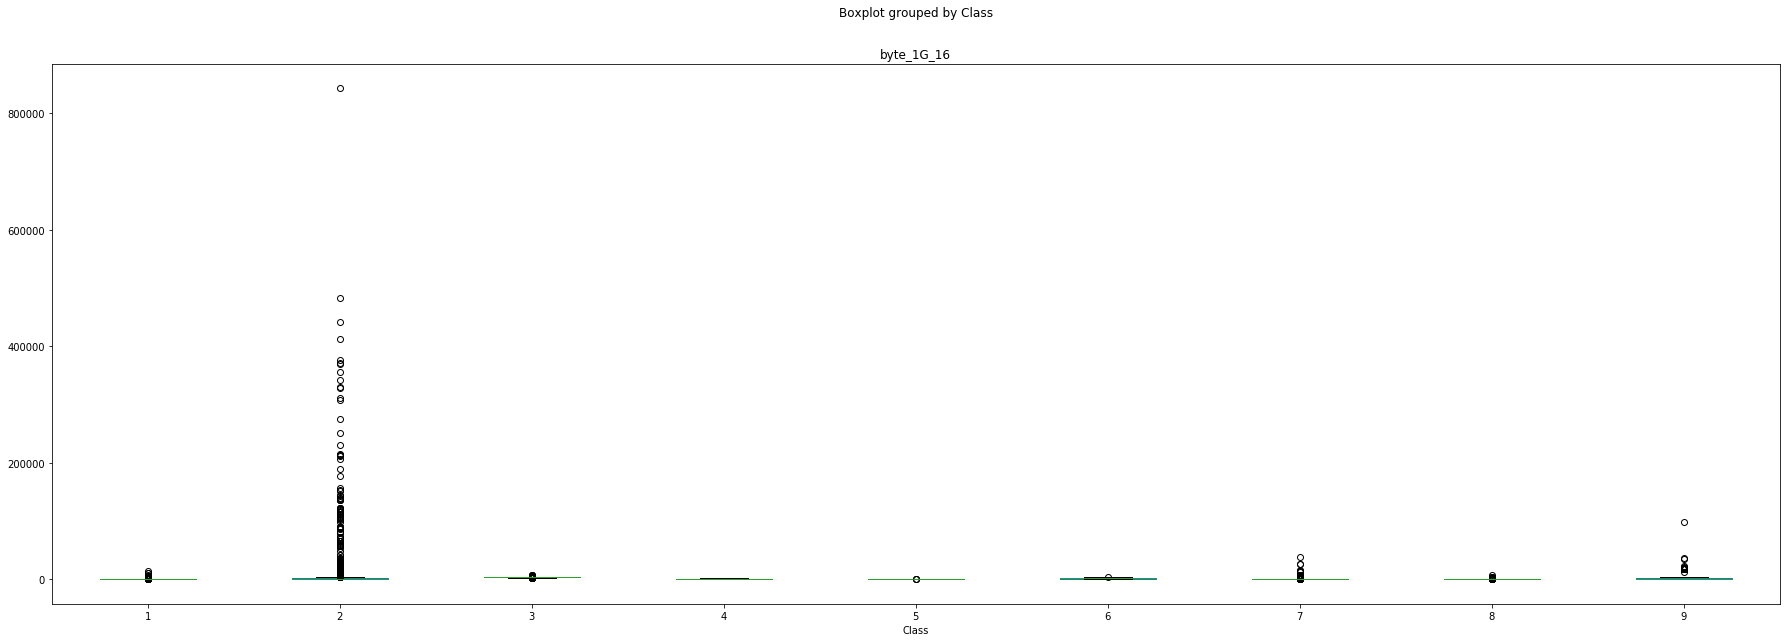

In [27]:
print(one_gram_features.columns.values[100])
features.boxplot(column=['byte_1G_16'], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

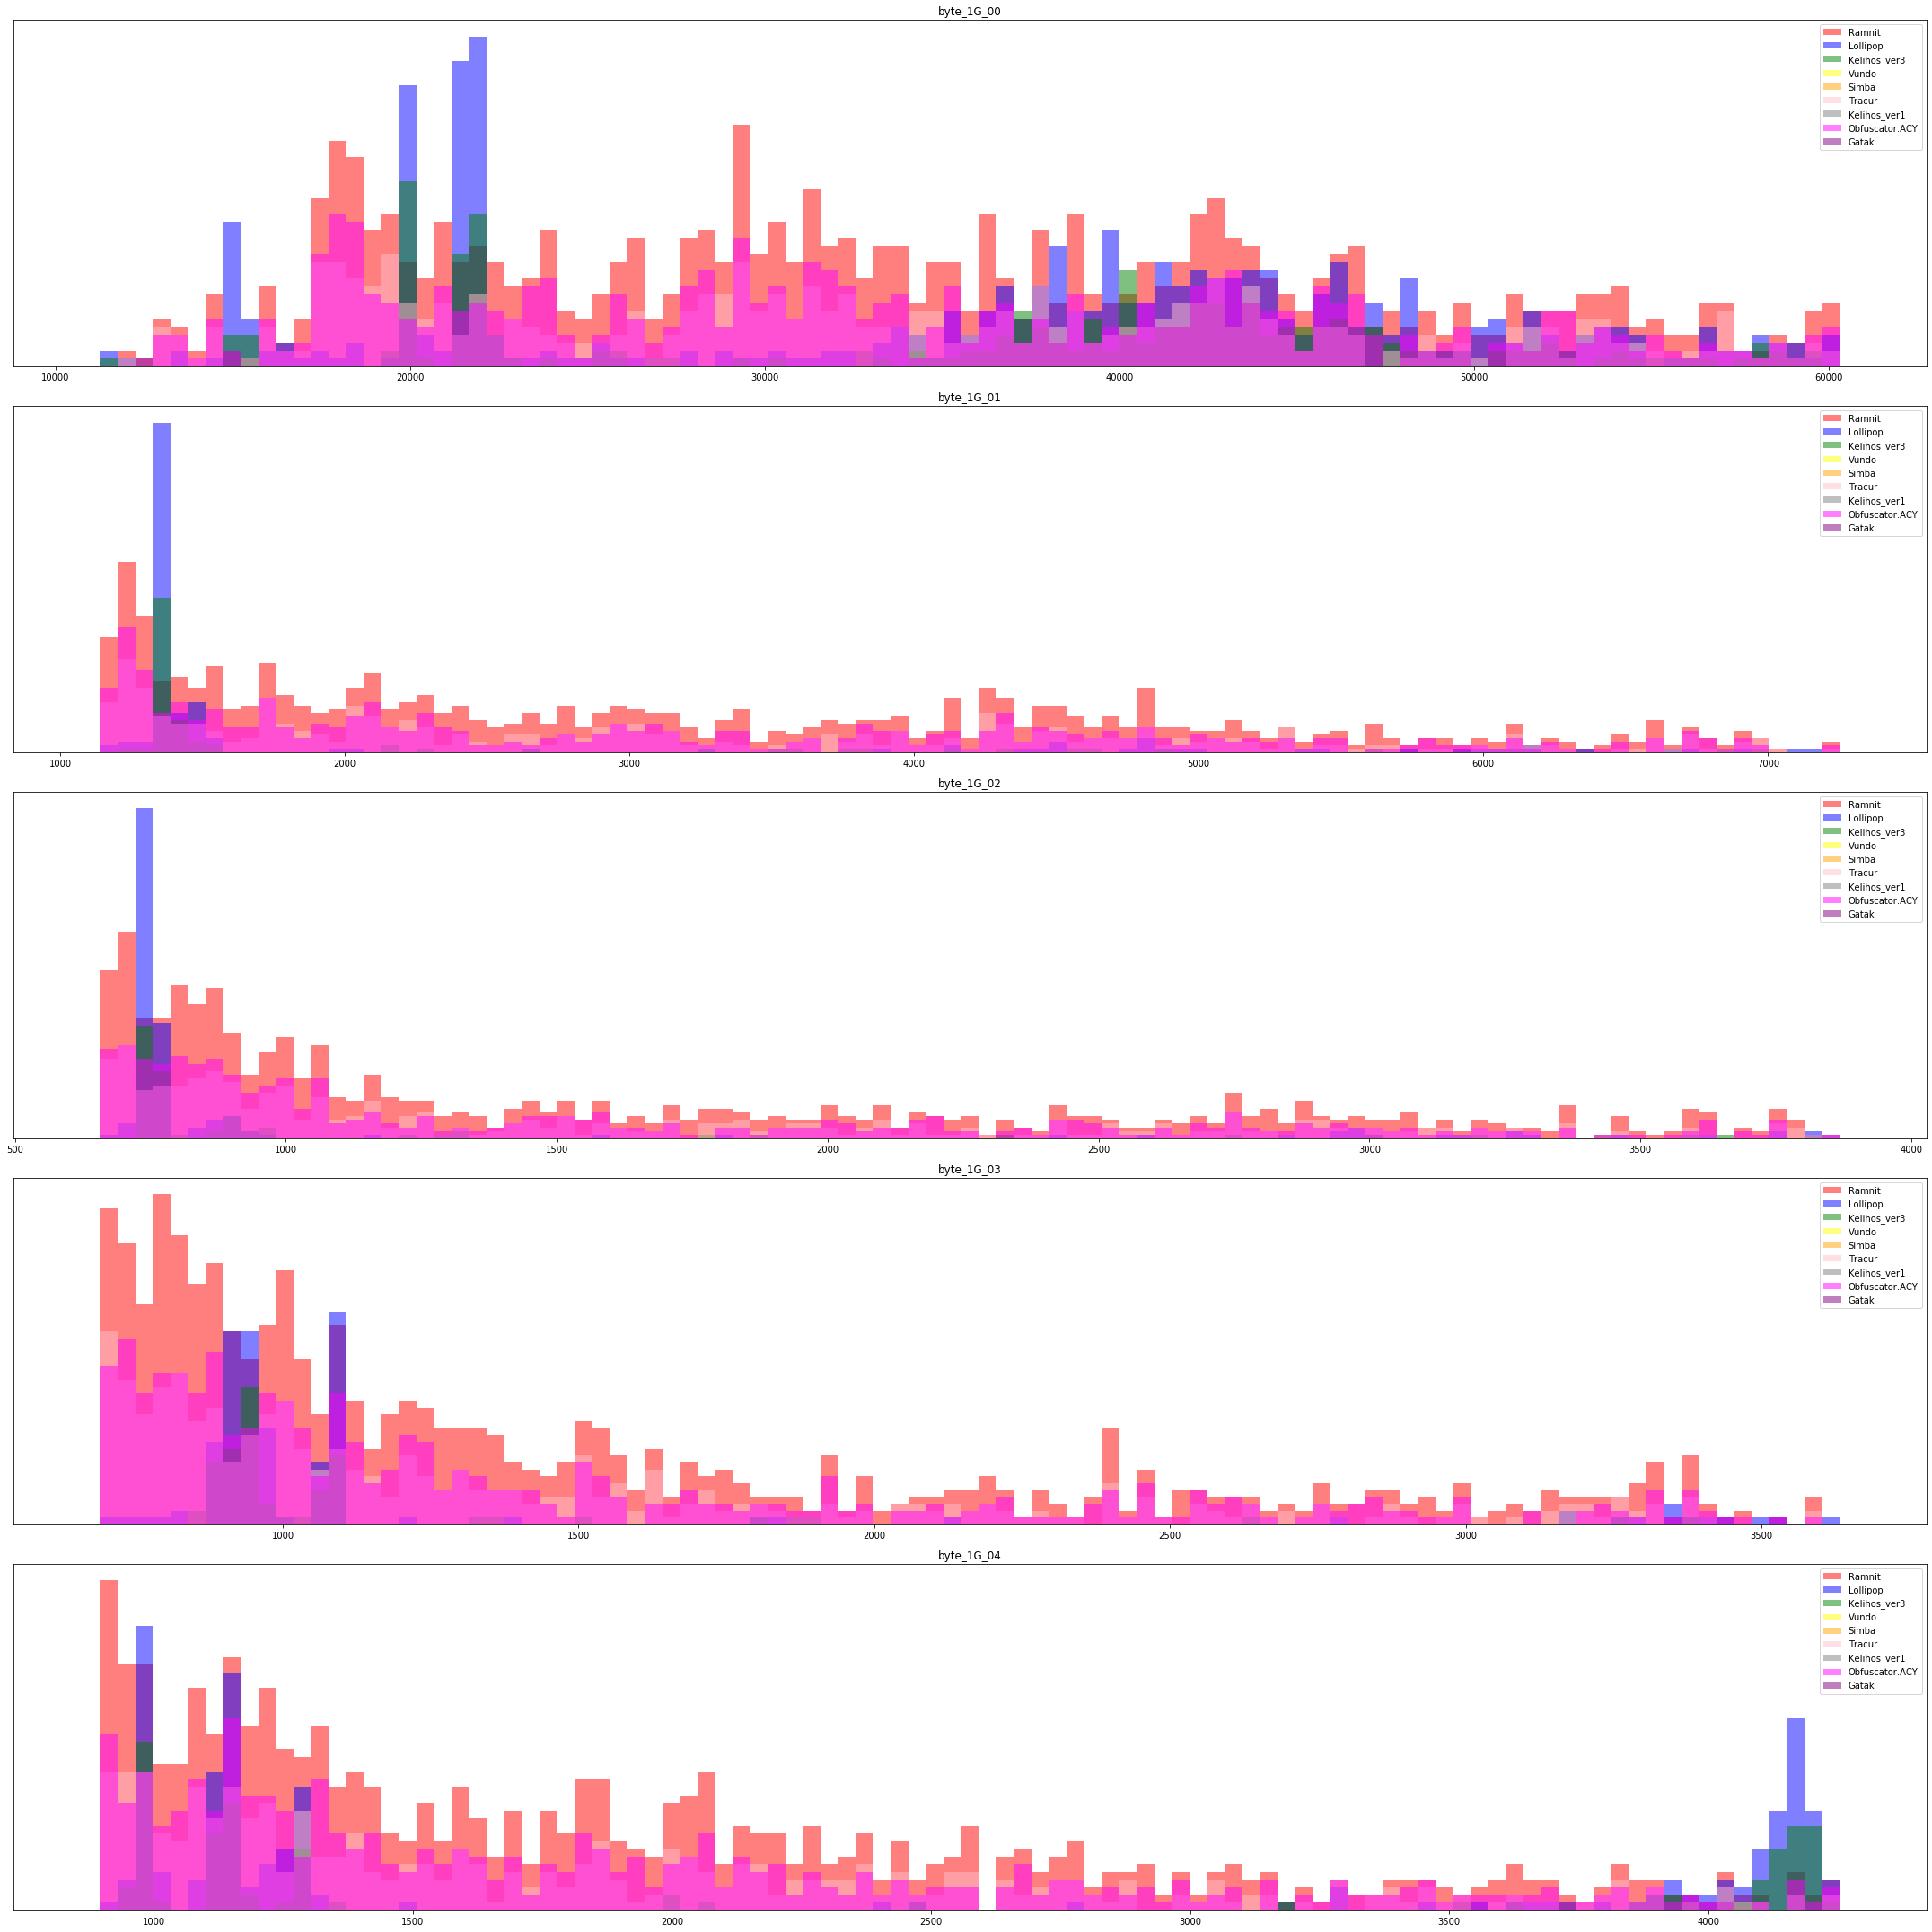

In [13]:
draw_histograms_rows_quantile( data = one_gram_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1,2,3,4], 
                              sections = 100, 
                              no_rows = 5, no_cols = 1, 
                              fig_x = 30, fig_y = 30,
                              i_want_whole_range = [False]*5 )

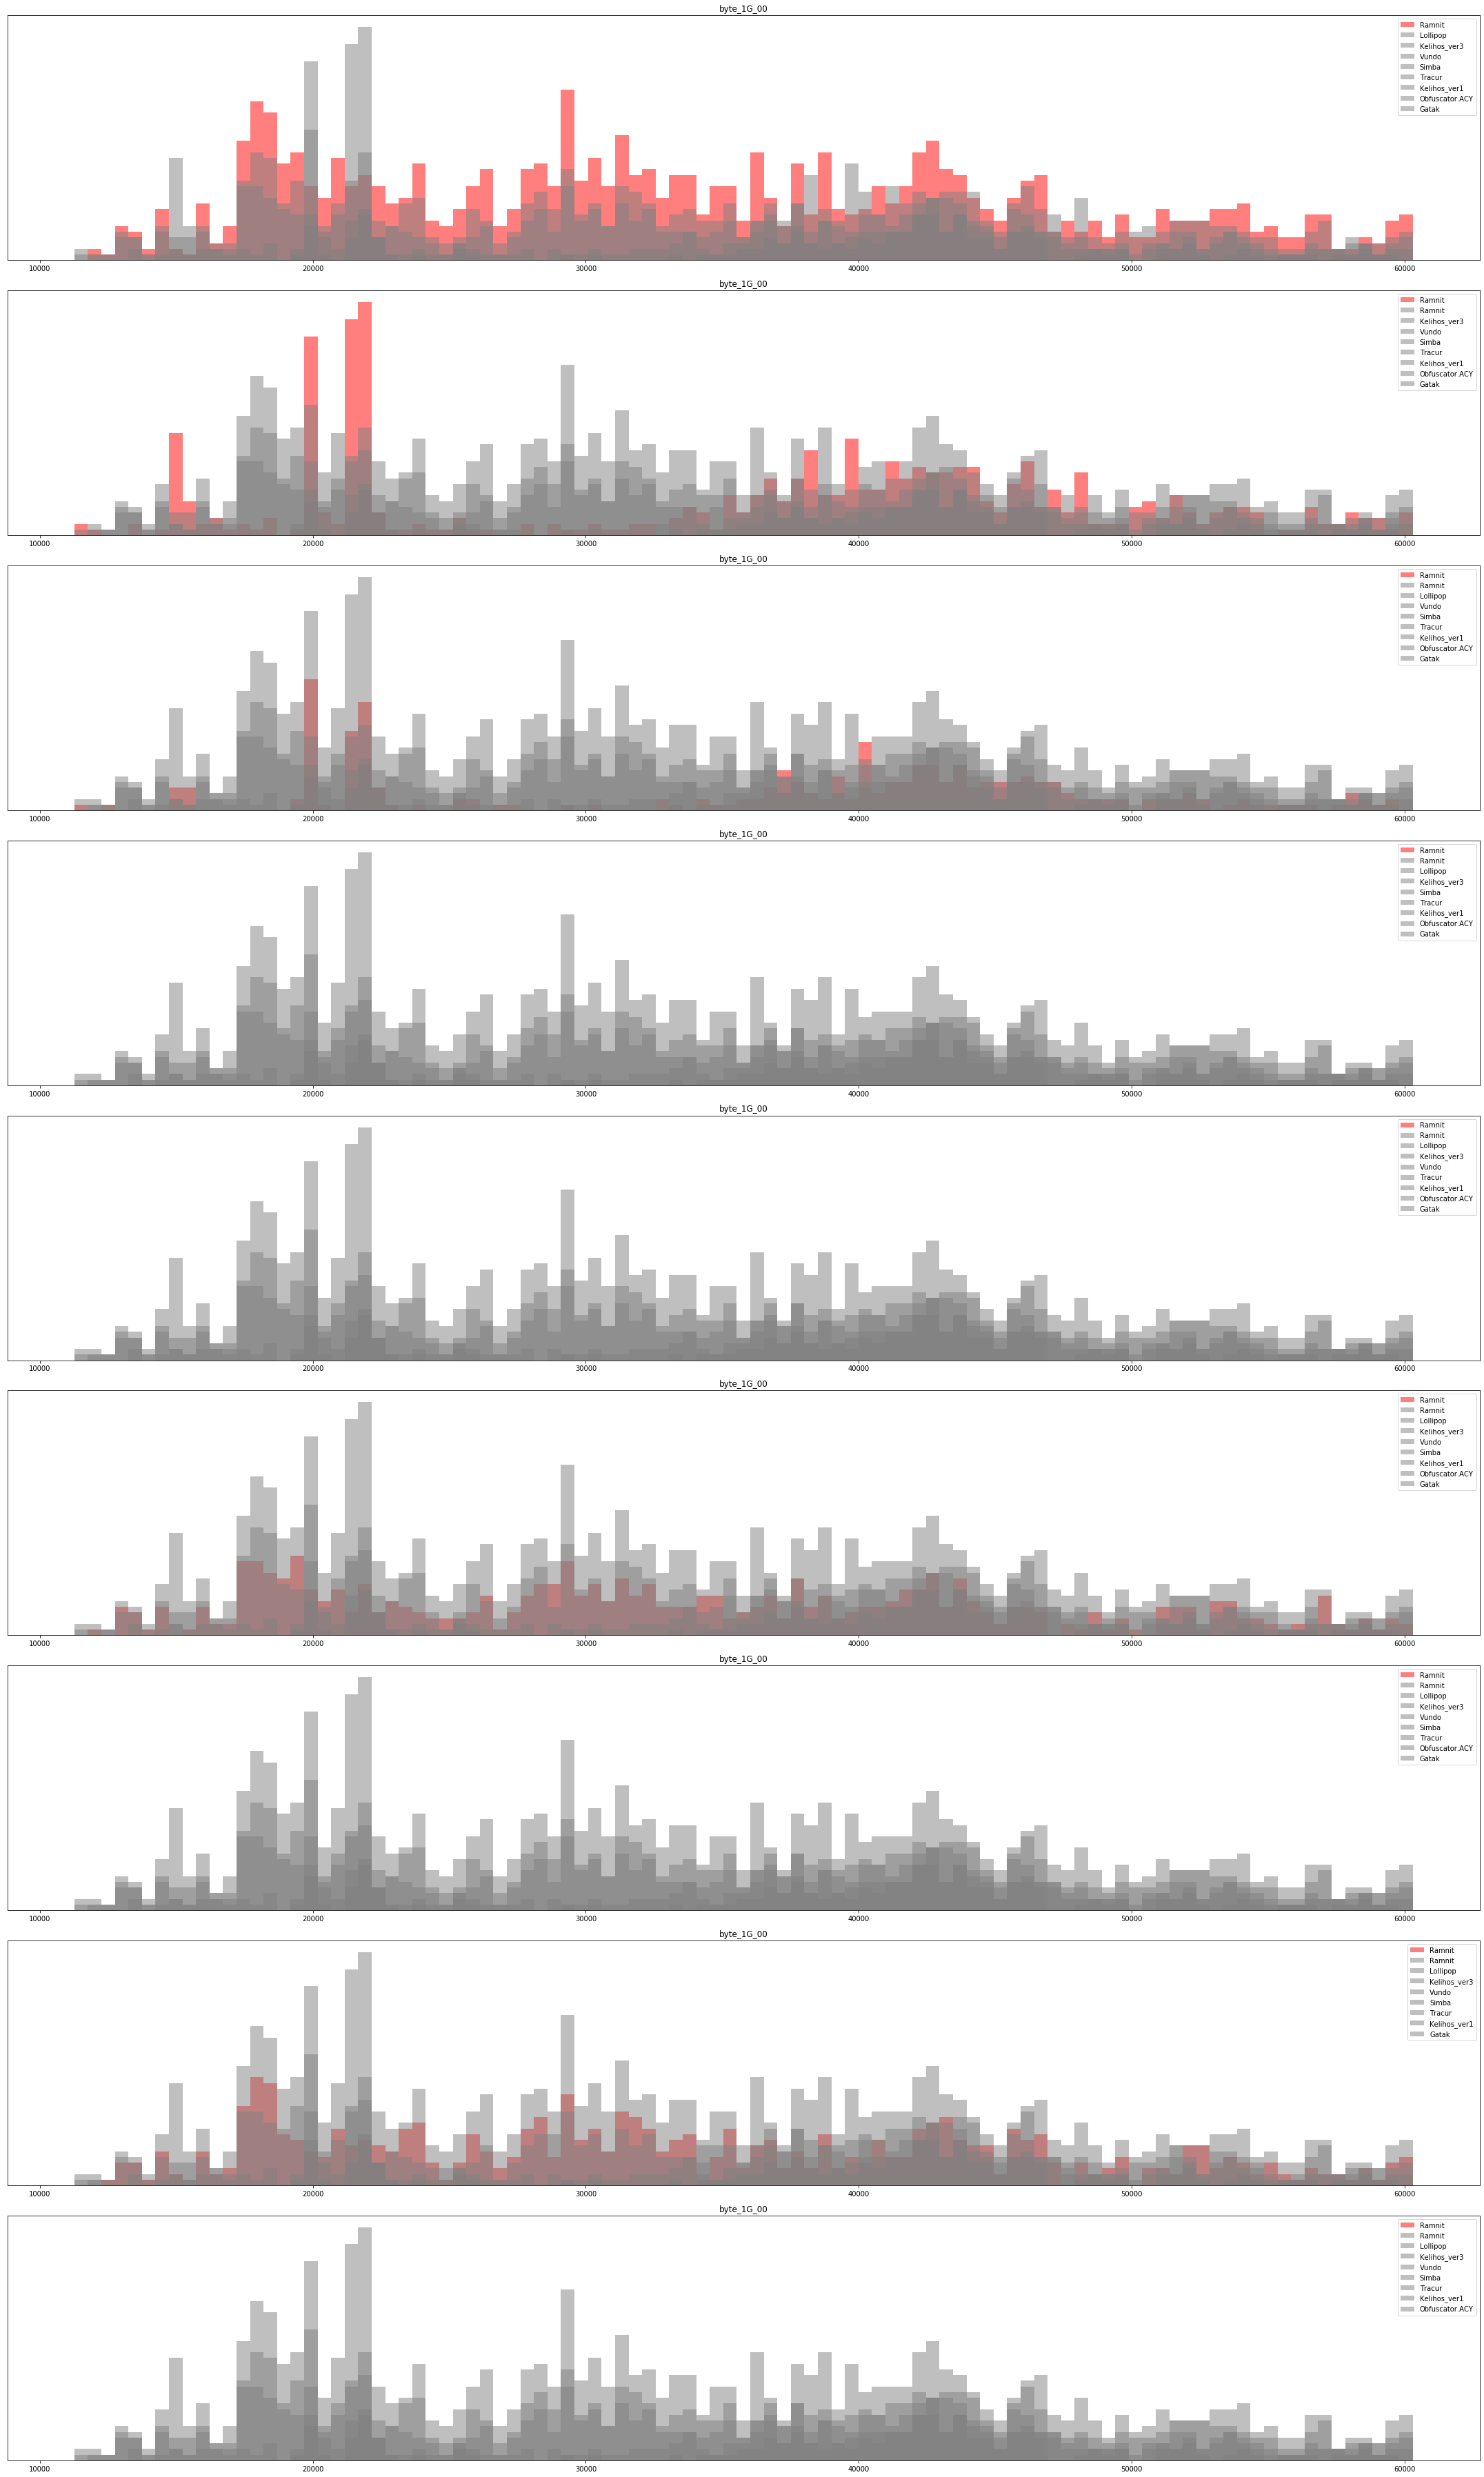

In [41]:
draw_histograms_rows_quantile_one_vs_others( data = one_gram_features, 
                                             classes = classes_begining_and_end_in_features,
                                             features = [0], 
                                             sections = 100, 
                                             no_rows = 9, no_cols = 1, 
                                             fig_x = 30, fig_y = 50,
                                             i_want_whole_range = [False]*9,
                                             one = [1,2,3,4,5,6,7,8,9])

### stmatea
* rekli smo probati nacrtati histograme samo u odnosu 2 klase a ne svih 9

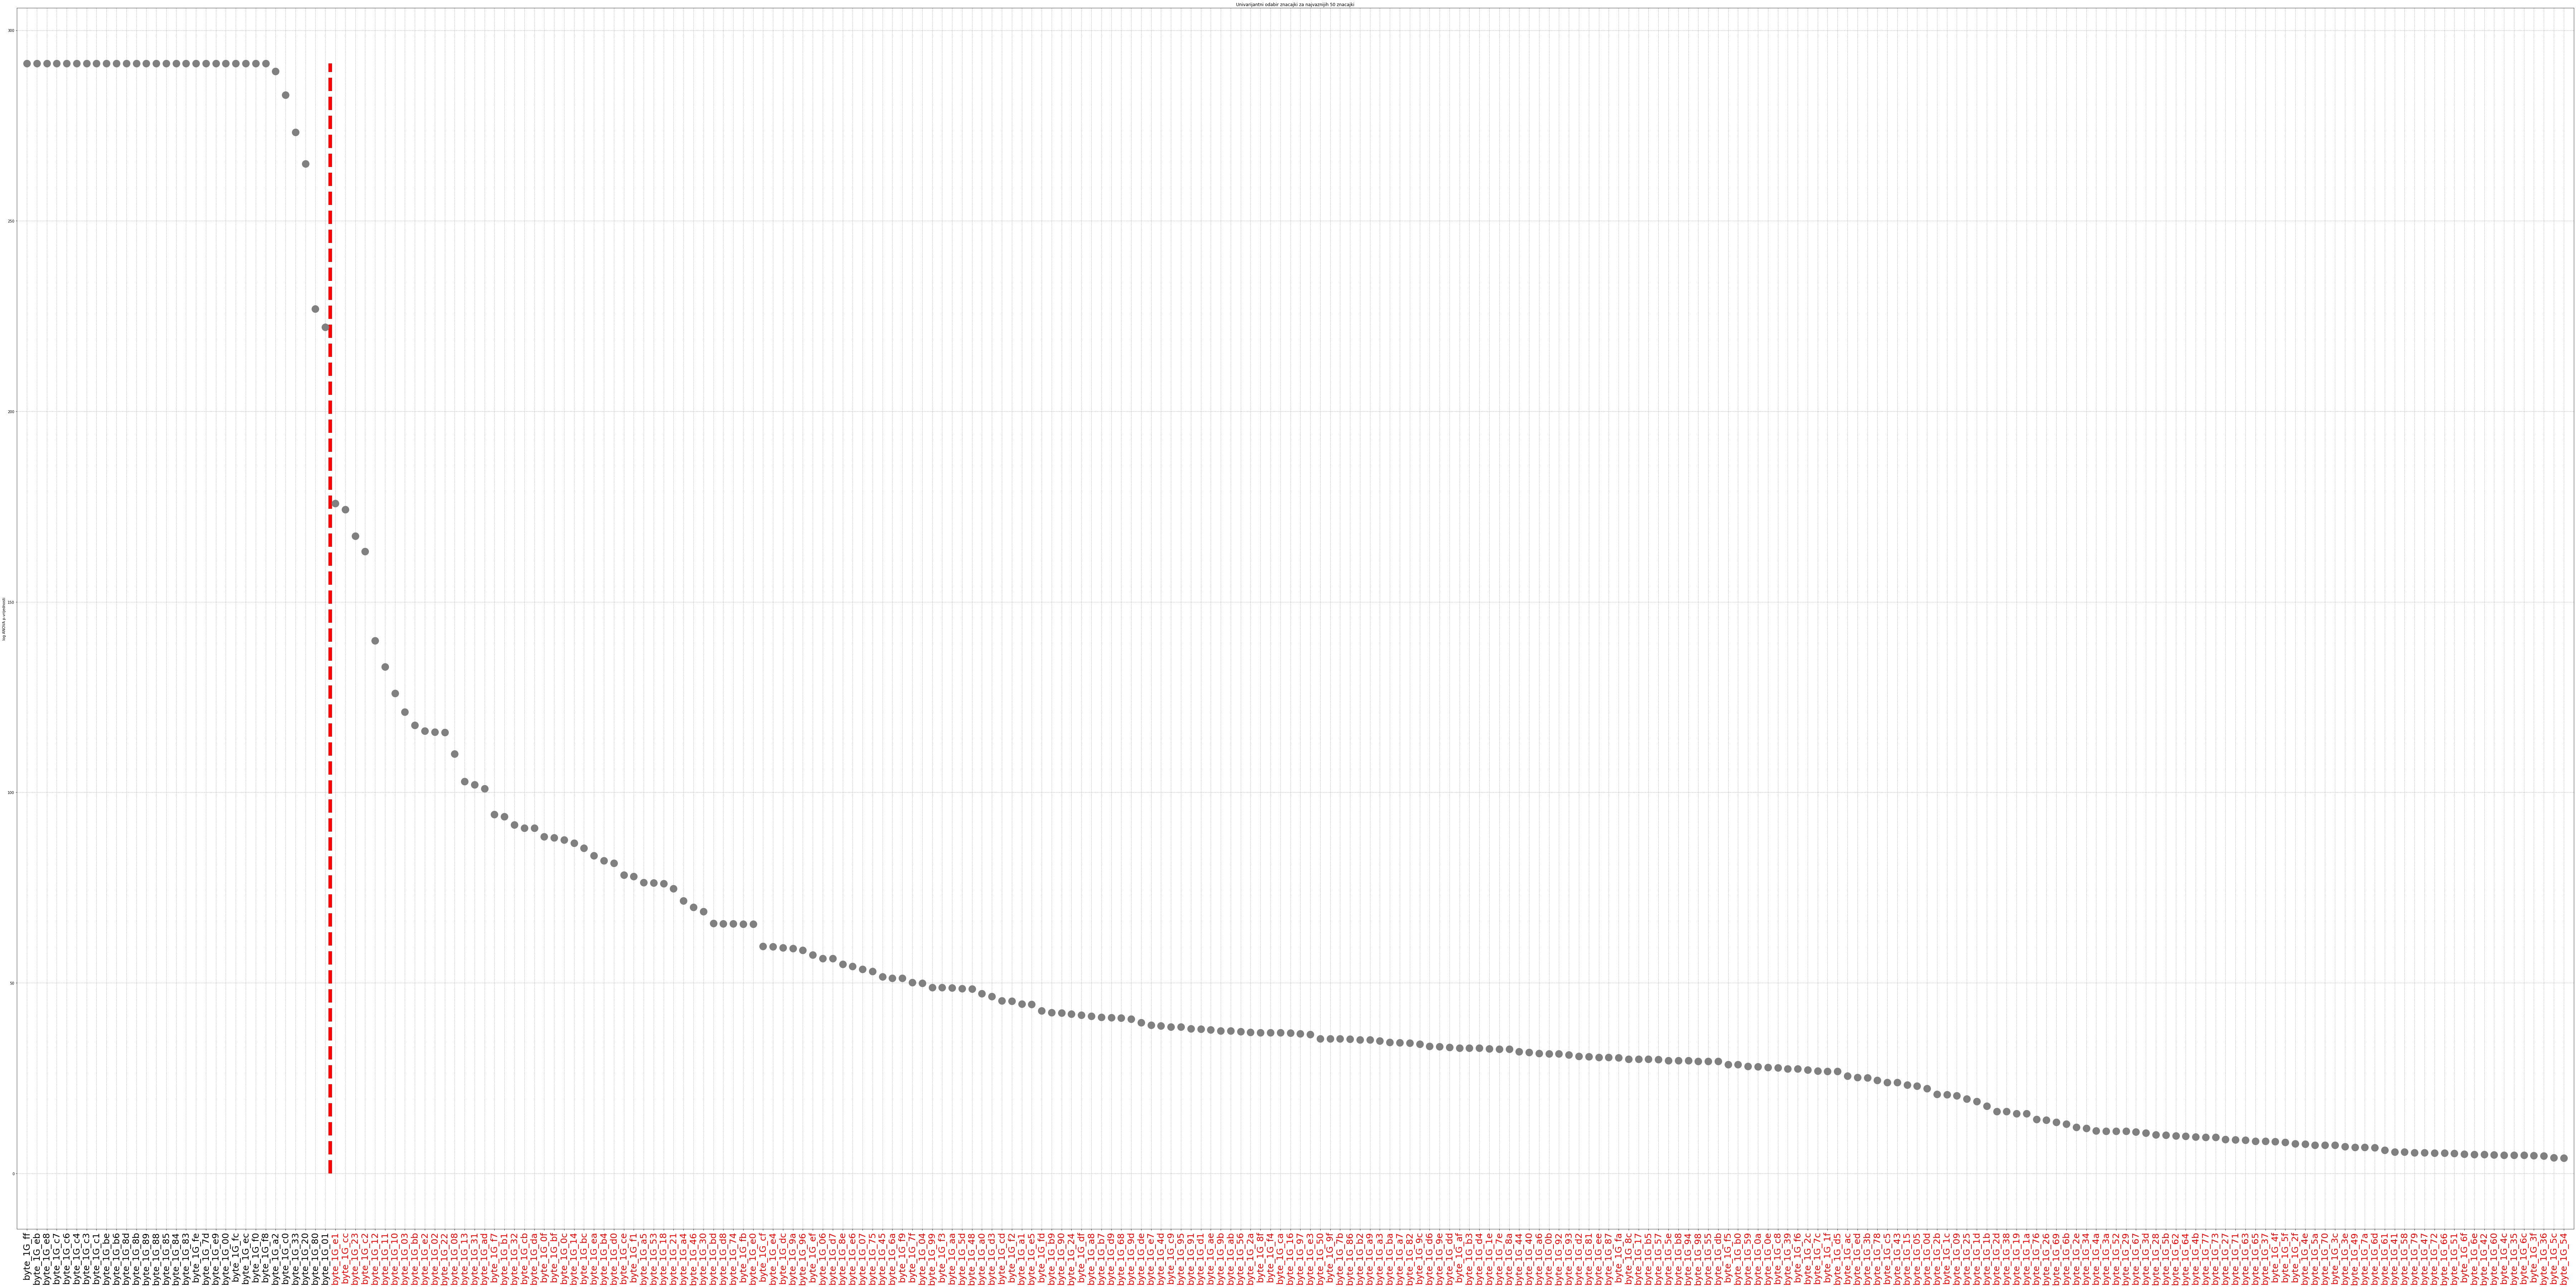

In [44]:
# evo još nekih algoritama za određivanje najboljih featura

#unvarijantni
from sklearn.feature_selection import SelectKBest, f_classif # ovo sve staviti gore na jedno mjesto na kraju kad vidimo koje cemo koristiti

malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( one_gram_features.dropna(), features['Class'], test_size=0.4, random_state=47)

def replaceZeroes(data):
    min_nonzero = np.min(data[np.nonzero(data)])
    data[data == 0] = min_nonzero
    return data

k_best = 31
selector = SelectKBest(f_classif, k=k_best)
selector.fit(malware_train, malware_classes_train)

scores = -np.log10(replaceZeroes(selector.pvalues_))
indices = np.argsort(scores)[::-1]
noises = indices[k_best:]

plt.figure(figsize=(100,50))
plt.grid(False)
plt.plot(range(malware_train.shape[1]), scores[indices], 'o', color='gray', markersize=20 )

plt.title('Univarijantni odabir znacajki za najvaznijih 50 znacajki')
plt.ylabel('log ANOVA p-vrijednosti')
plt.xlim([-1, malware_train.shape[1]])
plt.xticks(range(malware_train.shape[1]), one_gram_features.columns.values[indices], rotation=90, fontsize=25)
plt.vlines(k_best-0.5, 0, np.max(scores), color='red', linestyle='--', linewidth=10)
plt.grid(True,linestyle='--')
plt.tight_layout()

# Hack za bojanje noise znacajki u crveno
[ i.set_color("red") for i in plt.gca().get_xticklabels() if i.get_text() in [ one_gram_features.columns.values[noise] for noise in noises] ]

plt.show()

Broj primjera za treniranje: 6520
Broj primjera za testiranje: 4347


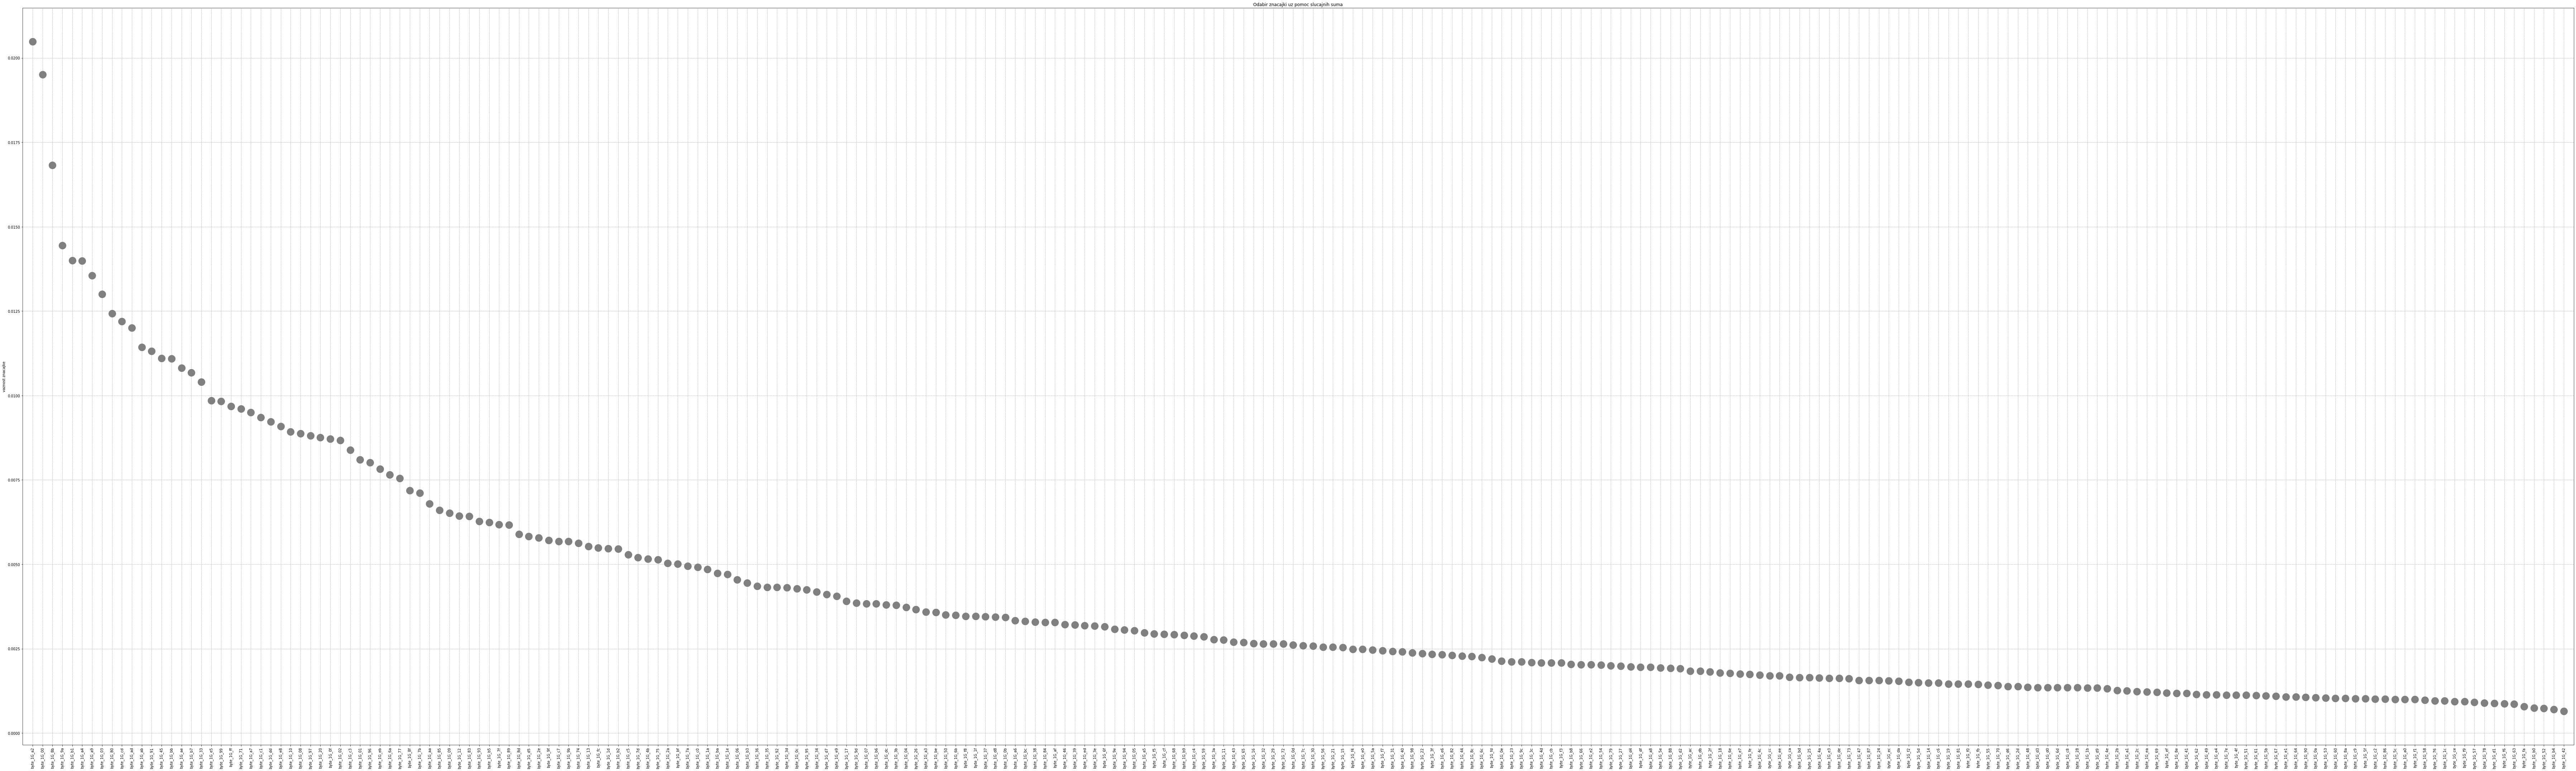

In [45]:
from sklearn.ensemble import RandomForestClassifier

def replaceZeroes(data):
    min_nonzero = np.min(data[np.nonzero(data)])
    data[data == 0] = min_nonzero
    return data

malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( one_gram_features.dropna(), features['Class'], test_size=0.4, random_state=47)
print('Broj primjera za treniranje: ' + str(len(malware_train)))
print('Broj primjera za testiranje: ' + str(len(malware_test)))

forest = RandomForestClassifier(n_estimators=1000,random_state=0,n_jobs=2) # Promjeni n_jobs za paralelizaciju!

forest.fit(malware_train, malware_classes_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1] # Vrati indekse koji sortiraju polje (obratno)

plt.figure(figsize=(100,30))

plt.plot(range(malware_train.shape[1]), importances[indices], 'o', color='gray', markersize=20)

plt.title('Odabir znacajki uz pomoc slucajnih suma')
plt.ylabel('vaznost znacajke')
plt.xlim([-1, malware_train.shape[1]])
plt.xticks(range(malware_train.shape[1]), one_gram_features.columns.values[indices], rotation=90)
plt.tight_layout()
plt.grid(True,linestyle='--')
plt.show()

Feature ranking:
1. feature byte_1G_00 (0.016057)
2. feature byte_1G_e9 (0.014986)
3. feature byte_1G_8b (0.012517)
4. feature byte_1G_f8 (0.012199)
5. feature byte_1G_c3 (0.011021)
6. feature byte_1G_f0 (0.010350)
7. feature byte_1G_e5 (0.009493)
8. feature byte_1G_88 (0.009473)
9. feature byte_1G_c9 (0.009414)
10. feature byte_1G_e8 (0.009323)
11. feature byte_1G_85 (0.009308)
12. feature byte_1G_ff (0.009258)
13. feature byte_1G_89 (0.008931)
14. feature byte_1G_fc (0.008918)
15. feature byte_1G_83 (0.008797)
16. feature byte_1G_c1 (0.008712)
17. feature byte_1G_8d (0.008438)
18. feature byte_1G_eb (0.008183)
19. feature byte_1G_c4 (0.008071)
20. feature byte_1G_84 (0.008046)
21. feature byte_1G_c0 (0.008038)
22. feature byte_1G_7d (0.007631)
23. feature byte_1G_cc (0.007489)
24. feature byte_1G_c7 (0.007301)
25. feature byte_1G_5d (0.007173)
26. feature byte_1G_02 (0.006948)
27. feature byte_1G_80 (0.006760)
28. feature byte_1G_e6 (0.006592)
29. feature byte_1G_f7 (0.006526)
30. fe

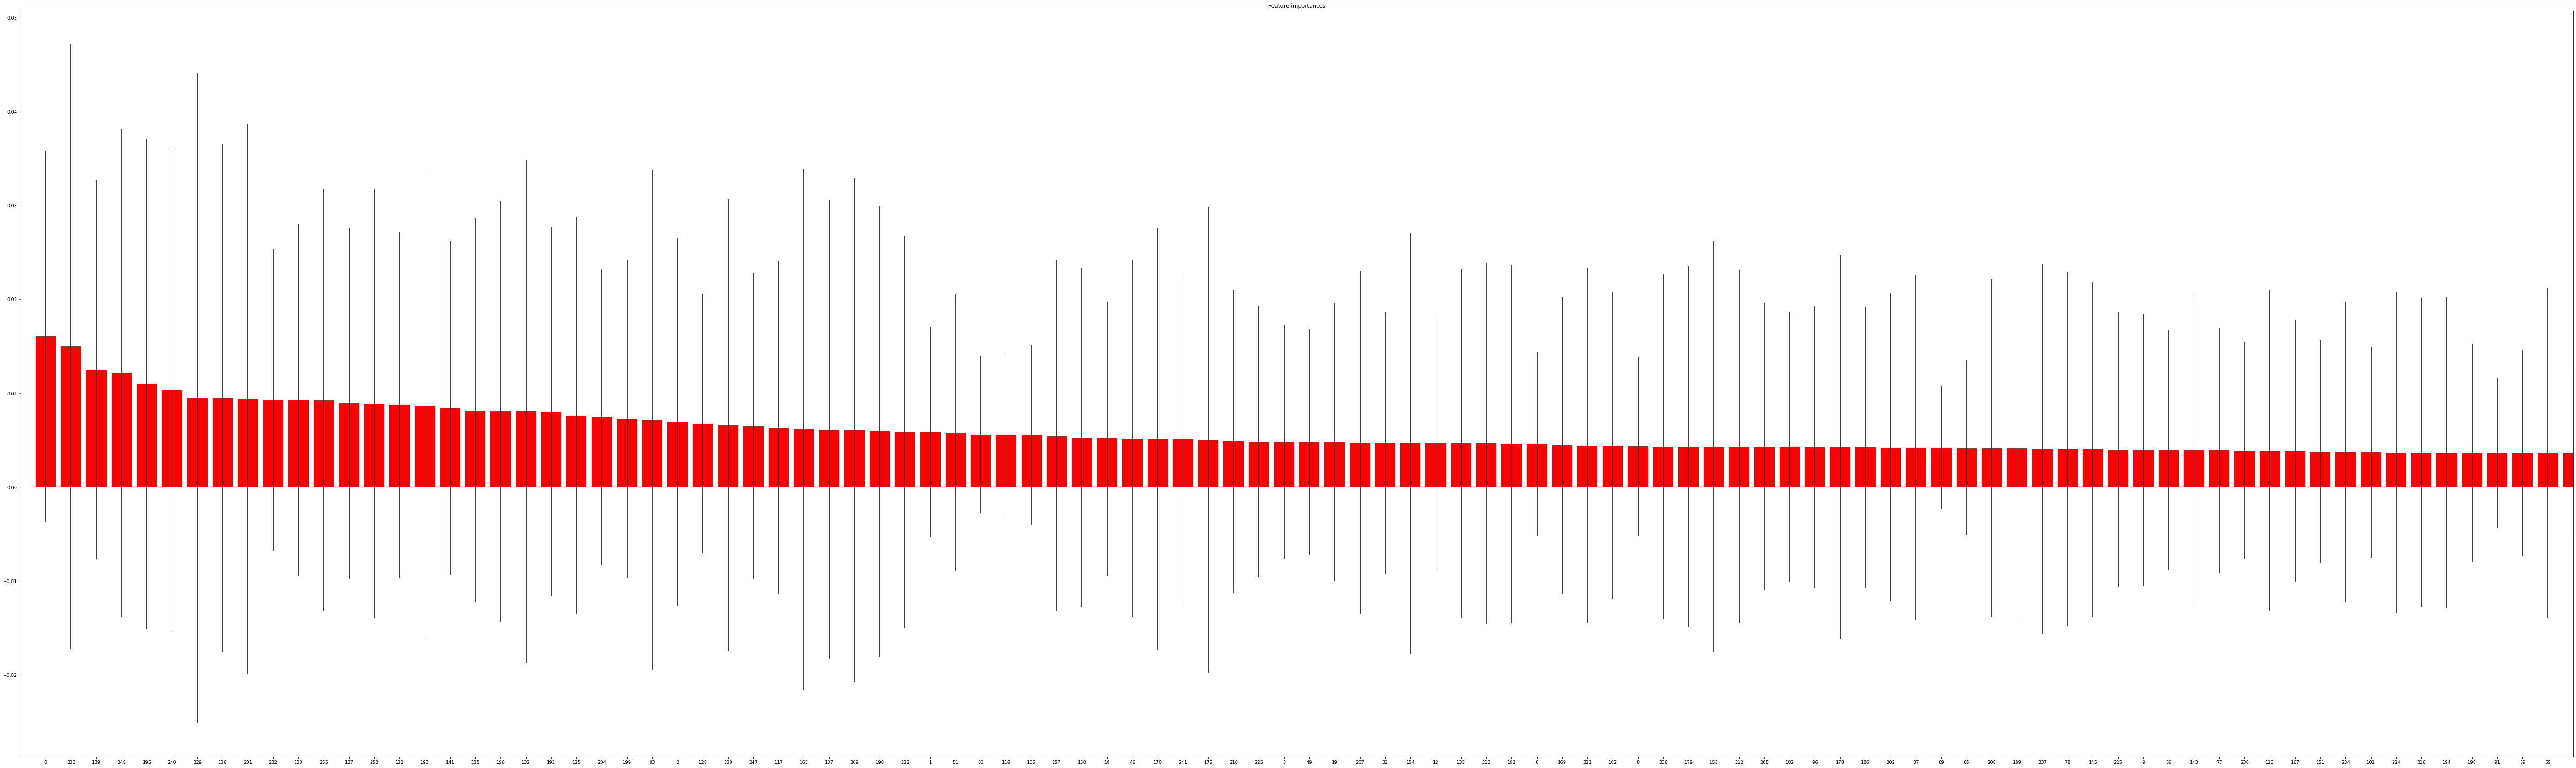

In [46]:
#ovo smo rekli koristii na svim skupa
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=250,random_state=0)

forest.fit(malware_train, malware_classes_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(malware_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, one_gram_features.columns.values[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(100,30))
plt.title("Feature importances")
plt.bar(range(malware_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(100), indices)
plt.xlim([-1, 100])
plt.show()

In [ ]:
# evo jos jedan SVC - 3. vjezbe - odabir znacajki 
from sklearn.svm import SVC
from sklearn import svm

def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))
    # Show all features
    if top == -1:
        top = len(names)

    plt.figure(figsize=(50,30))
    plt.barh(range(top), imp[::-1][0:top], align='center', color='red')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()
    
svc = SVC(kernel='linear')

X_train = one_gram_features.values
y_train = features['Class'].values

svc.fit(X_train, y_train)

feature_names = one_gram_features.columns.values
# Specify your top n features you want to visualize.
# You can also discard the abs() function 
# if you are interested in negative contribution of features
f_importances(abs(svc.coef_[0]), feature_names, top=50)

In [ ]:
# koristenje slucajnih suma - ovo mi se cini cak i najbolje, ali dosta duze traje
# da btw. te 3. vjezbe, na kraju pricaju o backward selecctionu featura (ovaj kod) i  forward selectionu 
# (ovaj su koristili naši rusi,ali on nije implementiran u sklearnu hehehhehehehehhehehe)

malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( one_gram_features.dropna(), features['Class'], test_size=0.4, random_state=47)

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

rfe_rf = RFE(RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=9), n_features_to_select=30, step=1)
rfe_rf.fit(malware_train, malware_classes_train)

print('Znacajke odabrane s RFE (koristeci slucajne sume):')
for i in list(entropy_features.columns.values[rfe_rf.get_support()]):
    print(' - ' + str(i))

#### (byte) metadata 
_MDB_

In [21]:
# METADATA značajke iz bytes datoteki
metadata_bytes_features = features.iloc[:,258:260]
metadata_bytes_features.head()

byte_filesize  byte_offset
0         244445    268439552
1         268254   1307774976
2         169207    268439552
3         771461   2112880640
4         167821    268439552

In [22]:
metadata_bytes_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

byte_filesize   -0.316945
byte_offset     -0.302309
dtype: float64

In [120]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( metadata_bytes_features.dropna(), features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
accuracy_test = model.score(malware_test,malware_classes_test) # Tocnost je default mjera za LogisticRegression()
print(accuracy_test)

0.49064704078503524


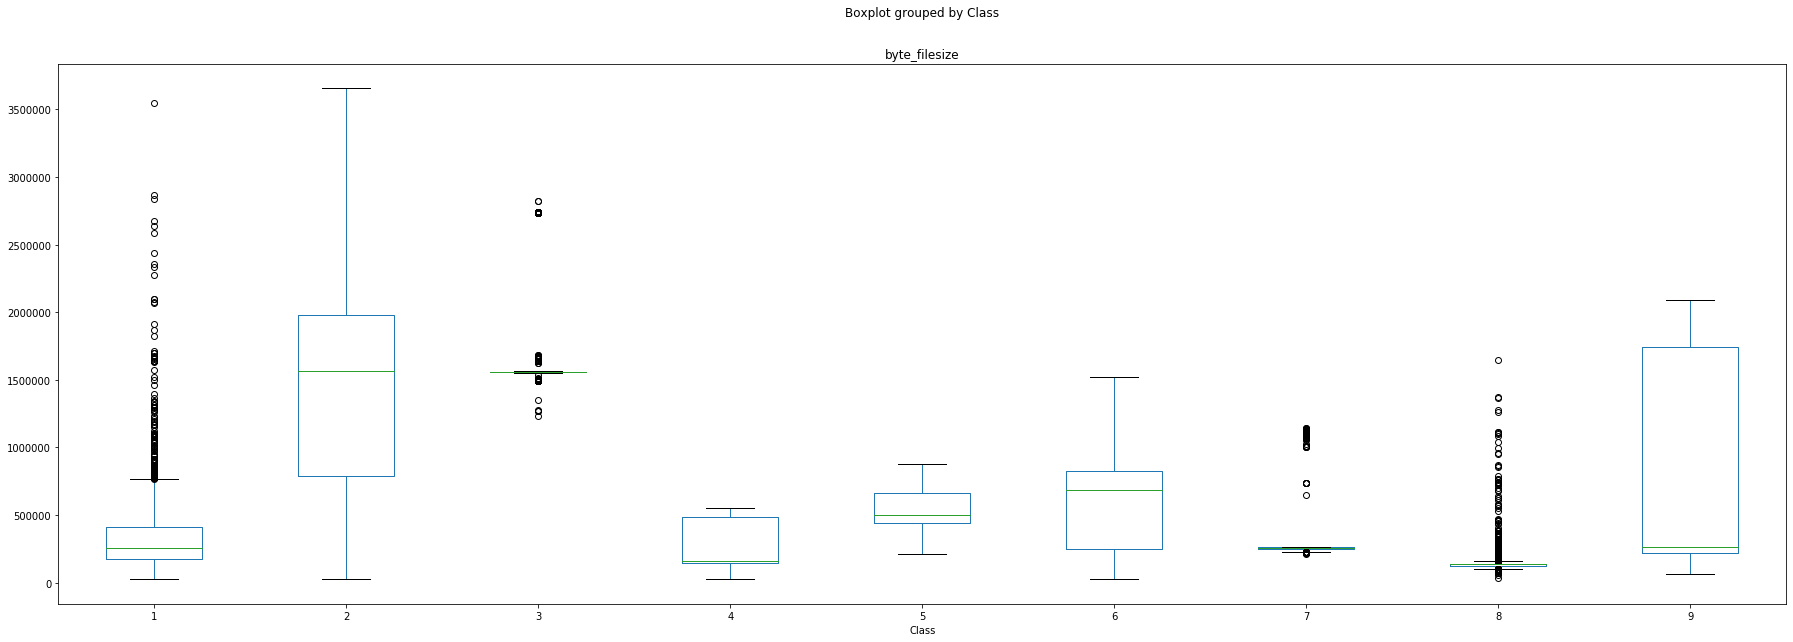

In [123]:
features.boxplot(column=[metadata_bytes_features.columns.values[0]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

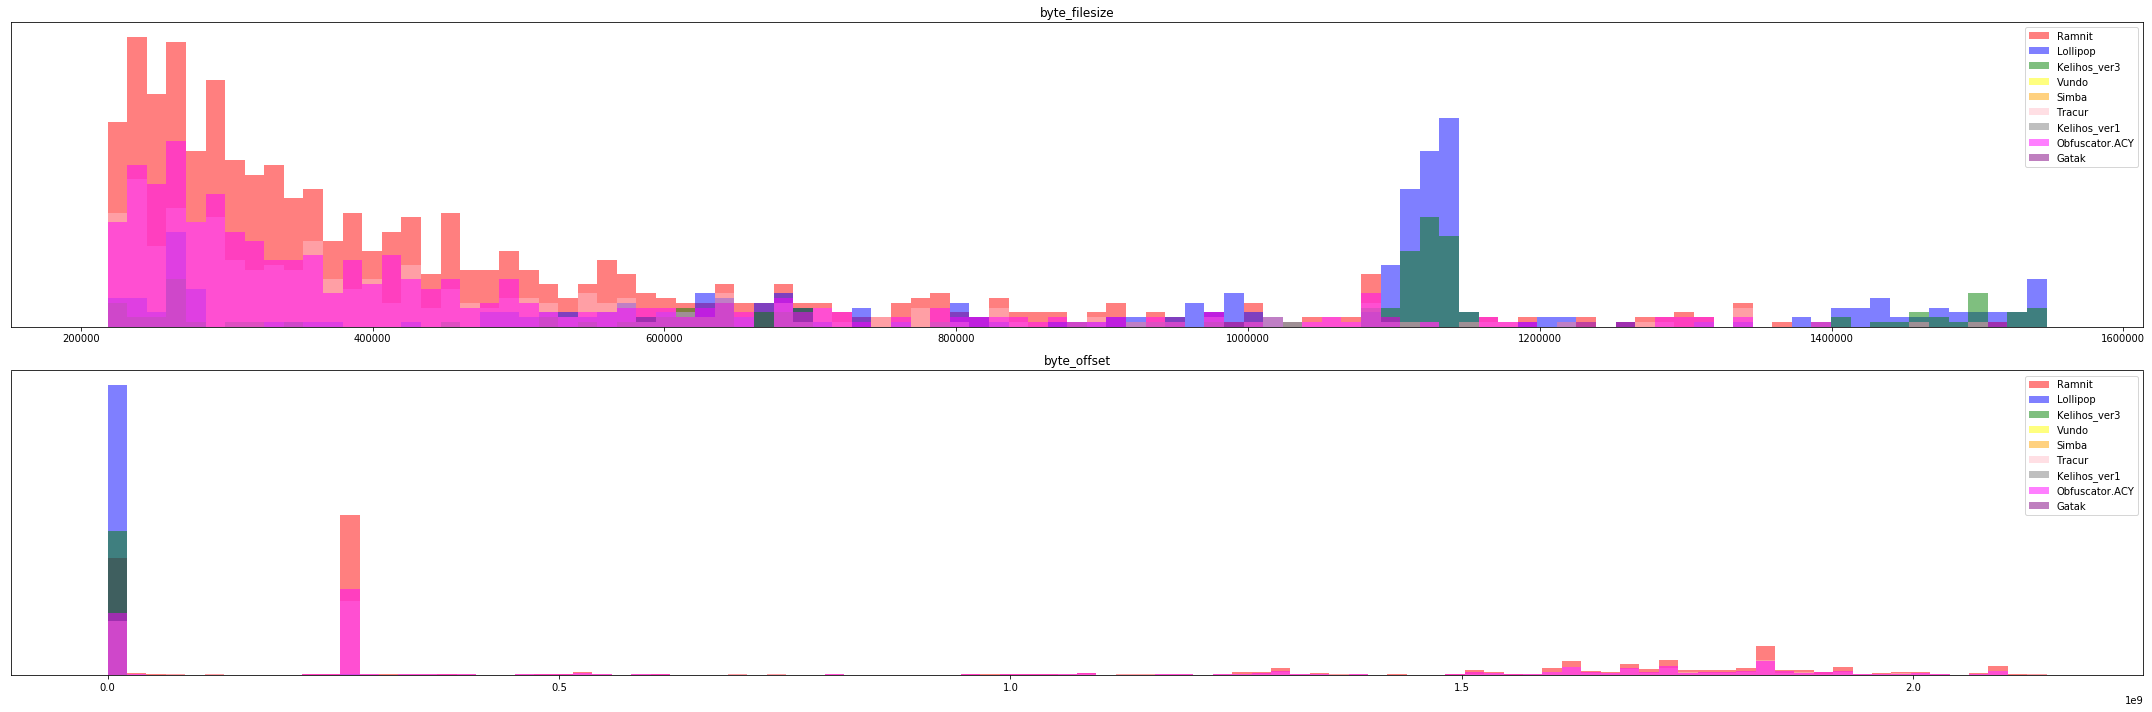

In [124]:
draw_histograms_rows_quantile( data = metadata_bytes_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1], 
                              sections = 100, 
                              no_rows = 2, no_cols = 1, 
                              fig_x = 30, fig_y = 10,
                              i_want_whole_range = [False, True])

#### entropija
_ENT_

In [10]:
# ENTROPY značajke 
entropy_features = features.iloc[:,260:462]
entropy_features.head()

ent_q_diffs_0  ent_q_diffs_1  ent_q_diffs_2  ent_q_diffs_3  ent_q_diffs_4  \
0       0.000000       0.000000       0.007566       0.002348       0.001304   
1       0.000000       0.000000       0.000000       0.000000       0.001661   
2       0.000000       0.000000       0.000000       0.000000       0.000000   
3       0.042895       0.003679       0.002993       0.004925       0.001247   
4       0.105760       0.002203       0.002518       0.003462       0.004721   

   ent_q_diffs_5  ent_q_diffs_6  ent_q_diffs_7  ent_q_diffs_8  ent_q_diffs_9  \
0       0.015914       0.003913       0.006261       0.004957       0.003652   
1       0.003738       0.002492       0.005399       0.012874       0.008306   
2       0.000000       0.000000       0.011930       0.008772       0.007368   
3       0.001559       0.001309       0.001683       0.002120       0.003429   
4       0.011331       0.001889       0.025181       0.027070       0.038401   

   ...  ent_p_diffs_10  ent_p_diffs_11  ent_p_diffs_12  ent_p_diffs_13  \
0  ...        0.023297        0.026589        0.032918        0.205912   
1  ...        0.012580        0.013367        0.014517        0.017450   
2  ...        0.017624        0.267654        0.037895        0.007731   
3  ...        0.011928        0.010840        0.011953        0.011937   
4  ...        0.014489        0.013735        0.075768        0.224453   

   ent_p_diffs_14  ent_p_diffs_15  ent_p_diffs_16  ent_p_diffs_17  \
0        0.000591        0.000359        0.000232        0.000230   
1        0.028586        0.205772        0.020981        0.002177   
2        0.002728        0.001414        0.001426        0.001377   
3        0.012959        0.015994        0.032501        0.183997   
4        0.000551        0.000227        0.000307        0.000312   

   ent_p_diffs_18  ent_p_diffs_19  
0        0.000256        0.000259  
1        0.002937        0.002568  
2        0.001329        0.003496  
3        0.028849        0.003329  
4        0.000231        0.000145  

[5 rows x 202 columns]

In [11]:
entropy_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

ent_q_diff_diffs_1_max-min   -0.264369
ent_p_15                     -0.260687
ent_q_diff_block_1_17        -0.257526
ent_q_diff_diffs_median      -0.250159
ent_p_16                     -0.242348
                                ...   
ent_q_diff_block_3_4          0.318442
ent_q_diffs_4                 0.349050
ent_q_diff_block_2_4          0.350154
ent_q_diff_block_3_3          0.352537
ent_q_diff_block_3_1          0.354994
Length: 202, dtype: float64

In [15]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( entropy_features, features['Class'], test_size=0.4, random_state=0)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
accuracy_test = model.score(malware_test,malware_classes_test) # Tocnost je default mjera za LogisticRegression()
print(accuracy_test)

0.9427191166321601


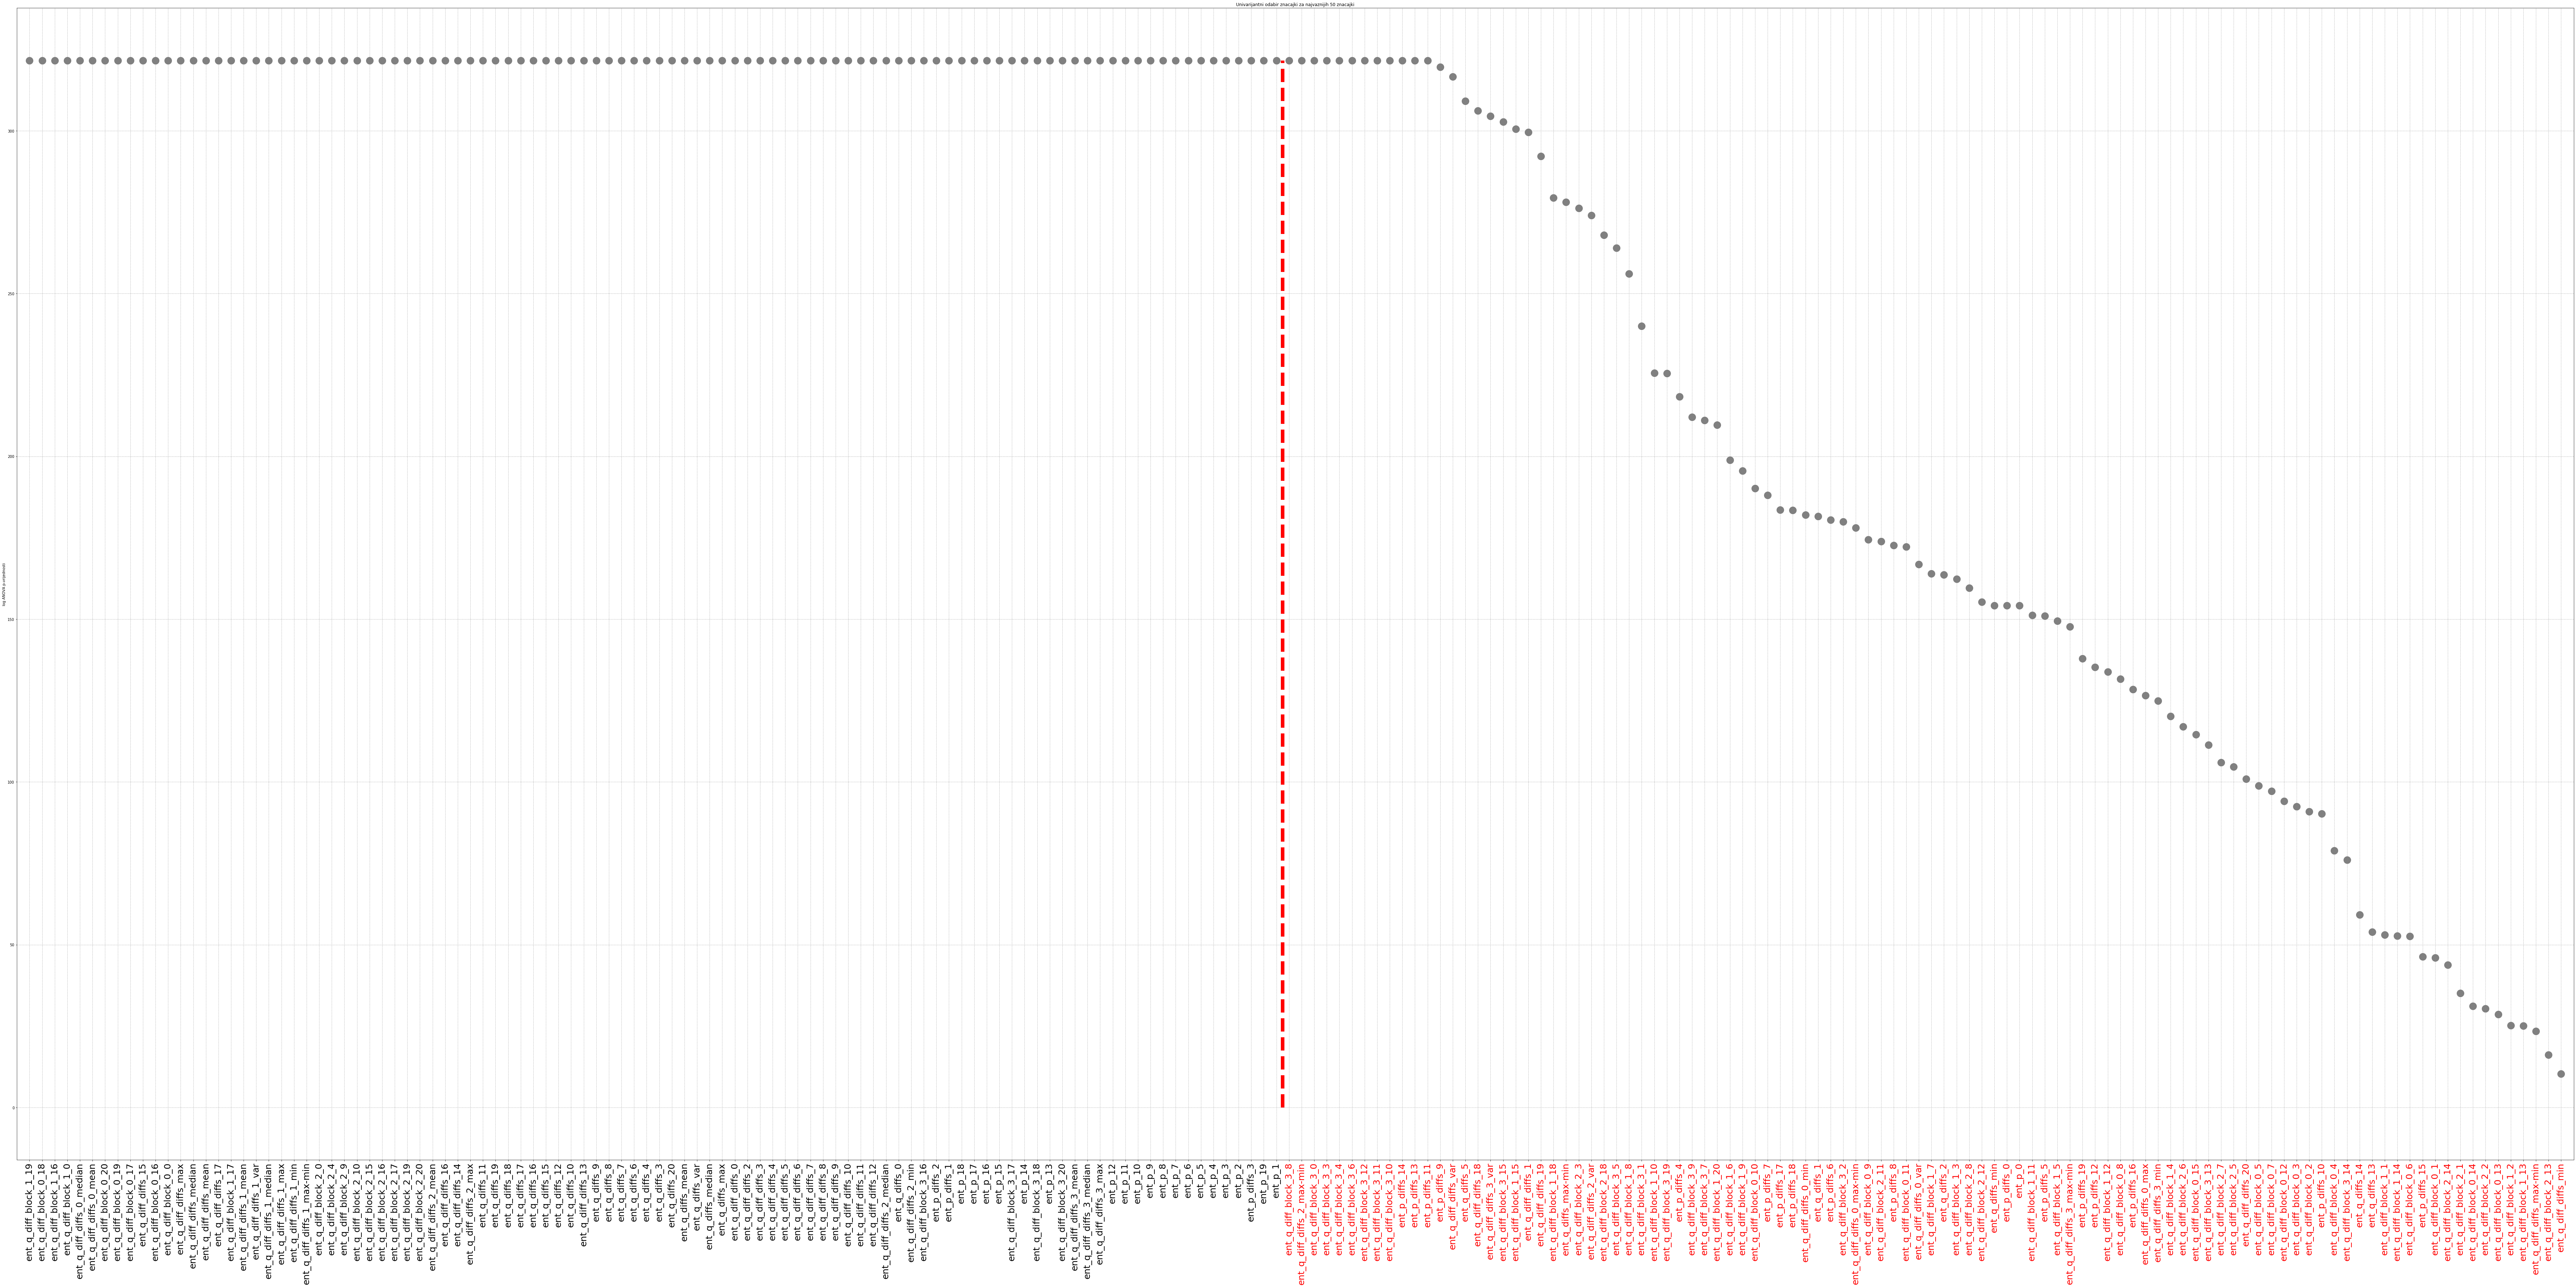

In [33]:
from sklearn.feature_selection import SelectKBest, f_classif

malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( entropy_features, features['Class'], test_size=0.4, random_state=47)


def replaceZeroes(data):
    min_nonzero = np.min(data[np.nonzero(data)])
    data[data == 0] = min_nonzero
    return data

k_best = 100
selector = SelectKBest(f_classif, k=k_best)
selector.fit(malware_train, malware_classes_train)

scores = -np.log10(replaceZeroes(selector.pvalues_))
indices = np.argsort(scores)[::-1]
noises = indices[k_best:]

plt.figure(figsize=(100,50))
plt.grid(False)
plt.plot(range(malware_train.shape[1]), scores[indices], 'o', color='gray', markersize=20 )

plt.title('Univarijantni odabir znacajki za najvaznijih 50 znacajki')
plt.ylabel('log ANOVA p-vrijednosti')
plt.xlim([-1, malware_train.shape[1]]) #samo prvih 150
plt.xticks(range(malware_train.shape[1]), entropy_features.columns.values[indices], rotation=90, fontsize=25)
plt.vlines(k_best-0.5, 0, np.max(scores), color='red', linestyle='--', linewidth=10)
plt.grid(True,linestyle='--')
plt.tight_layout()

# Hack za bojanje noise znacajki u crveno
[ i.set_color("red") for i in plt.gca().get_xticklabels() if i.get_text() in [ entropy_features.columns.values[noise] for noise in noises] ]

plt.show()

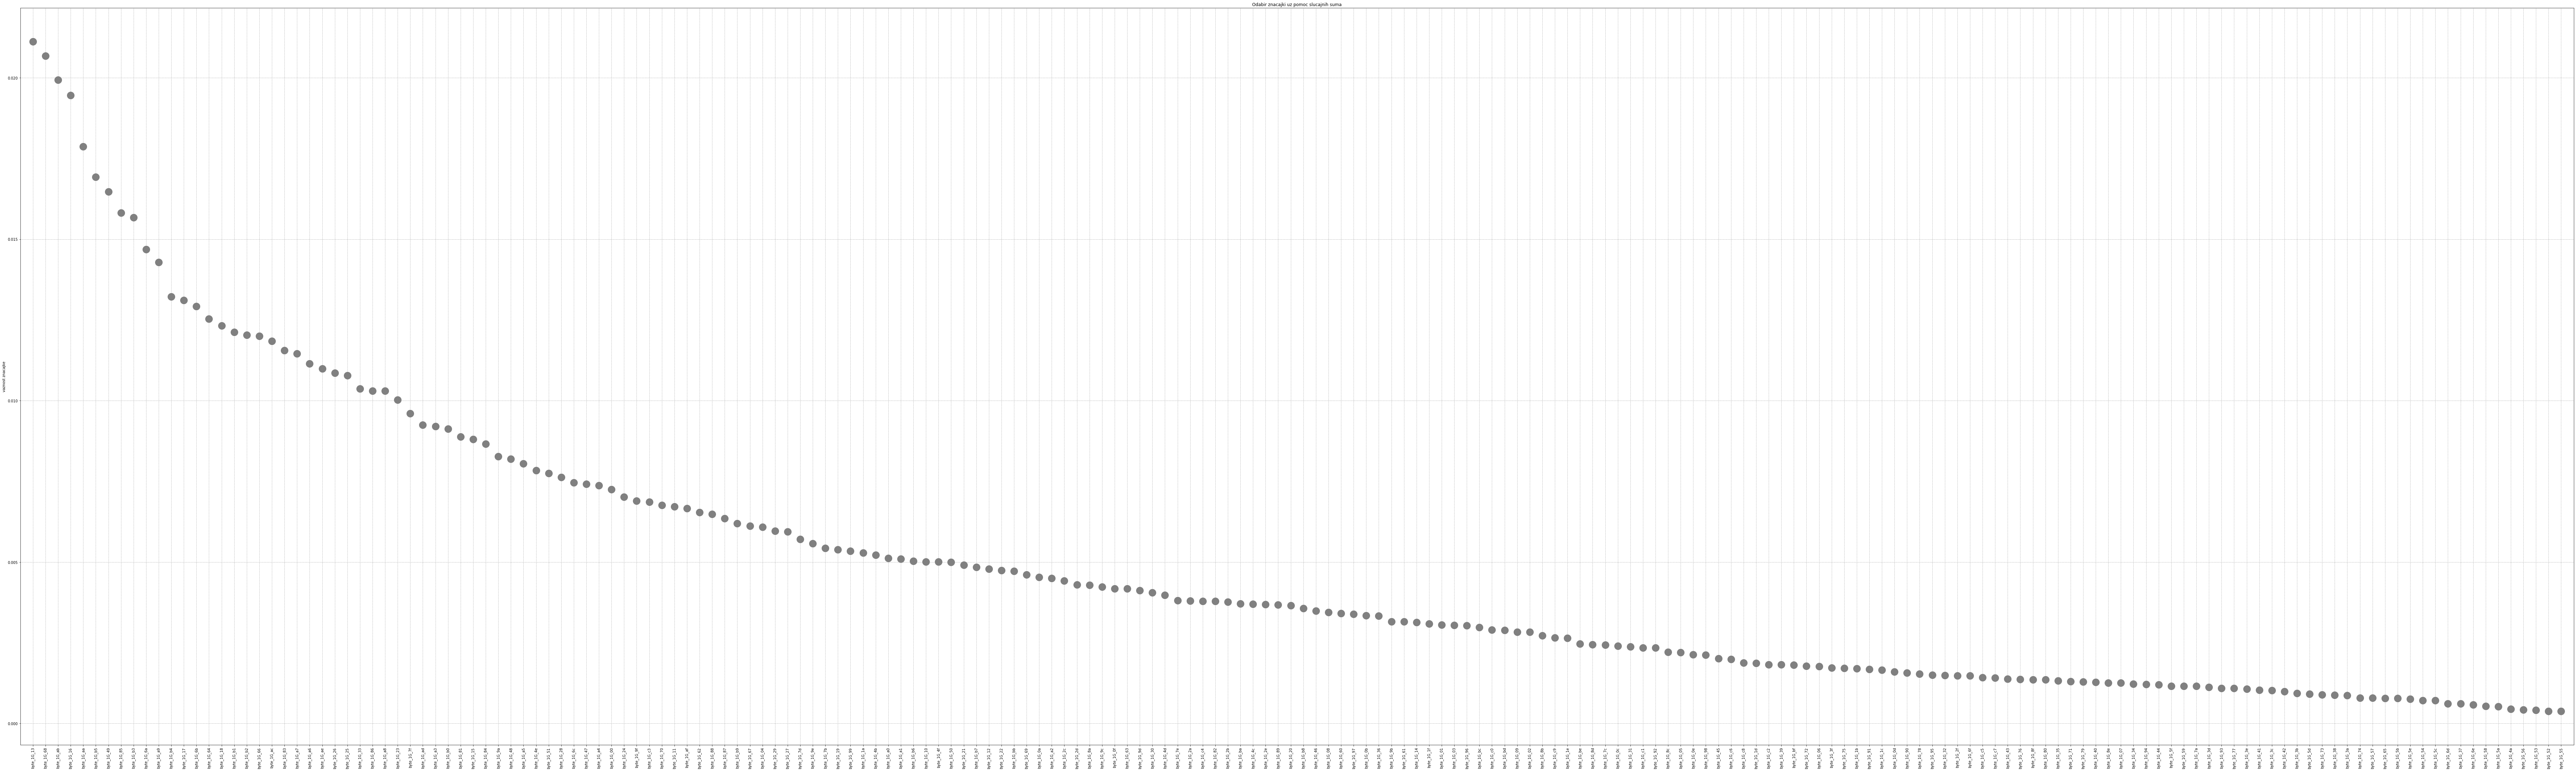

In [40]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( entropy_features, features['Class'], test_size=0.4, random_state=47)

forest = ExtraTreesClassifier(n_estimators=250,random_state=0)

forest.fit(malware_train, malware_classes_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(100,30))
plt.plot(range(malware_train.shape[1]), importances[indices], 'o', color='gray', markersize=20)

plt.title('Odabir znacajki uz pomoc slucajnih suma')
plt.ylabel('vaznost znacajke')
plt.xlim([-1, malware_train.shape[1]])
plt.xticks(range(malware_train.shape[1]), one_gram_features.columns.values[indices], rotation=90)
plt.tight_layout()
plt.grid(True,linestyle='--')
plt.show()

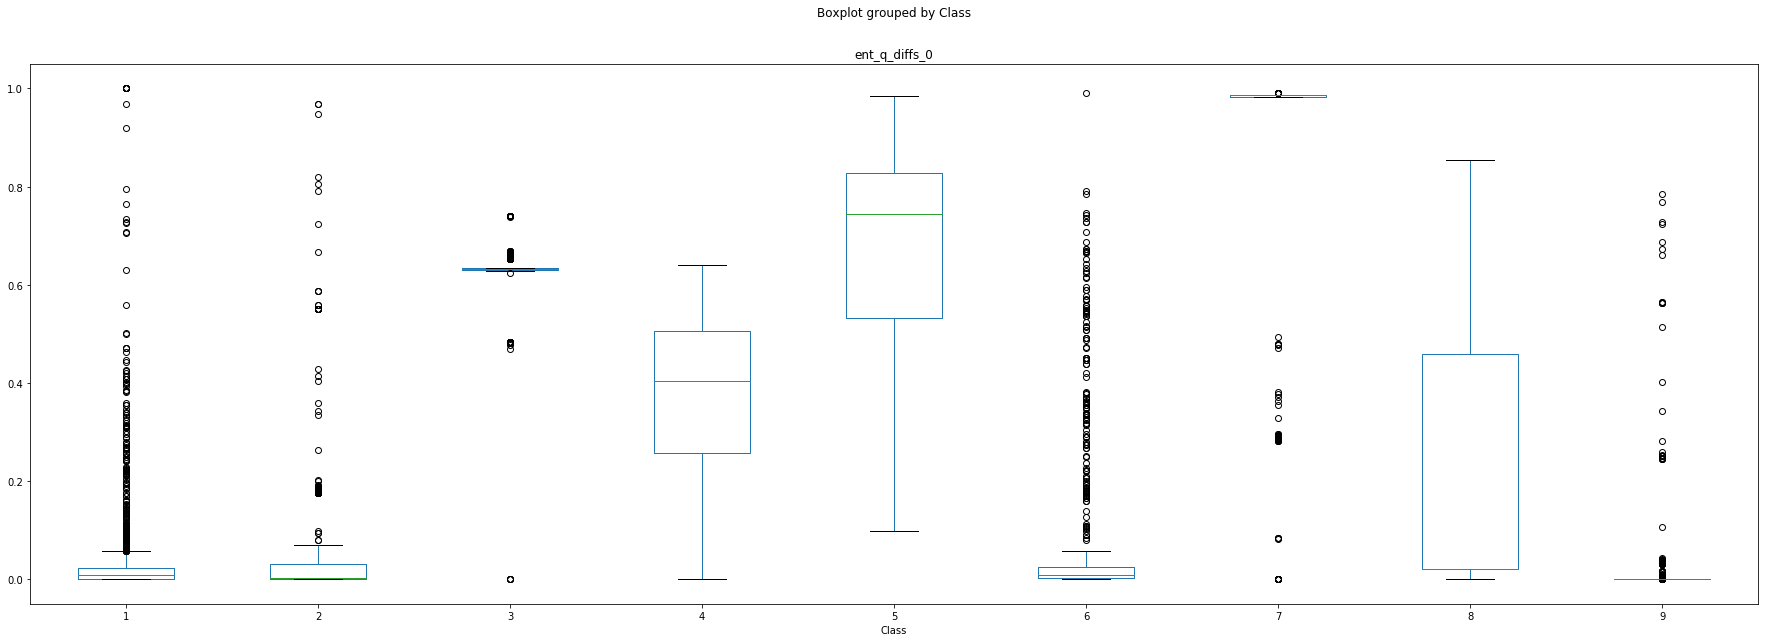

In [125]:
features.boxplot(column=[entropy_features.columns.values[0]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

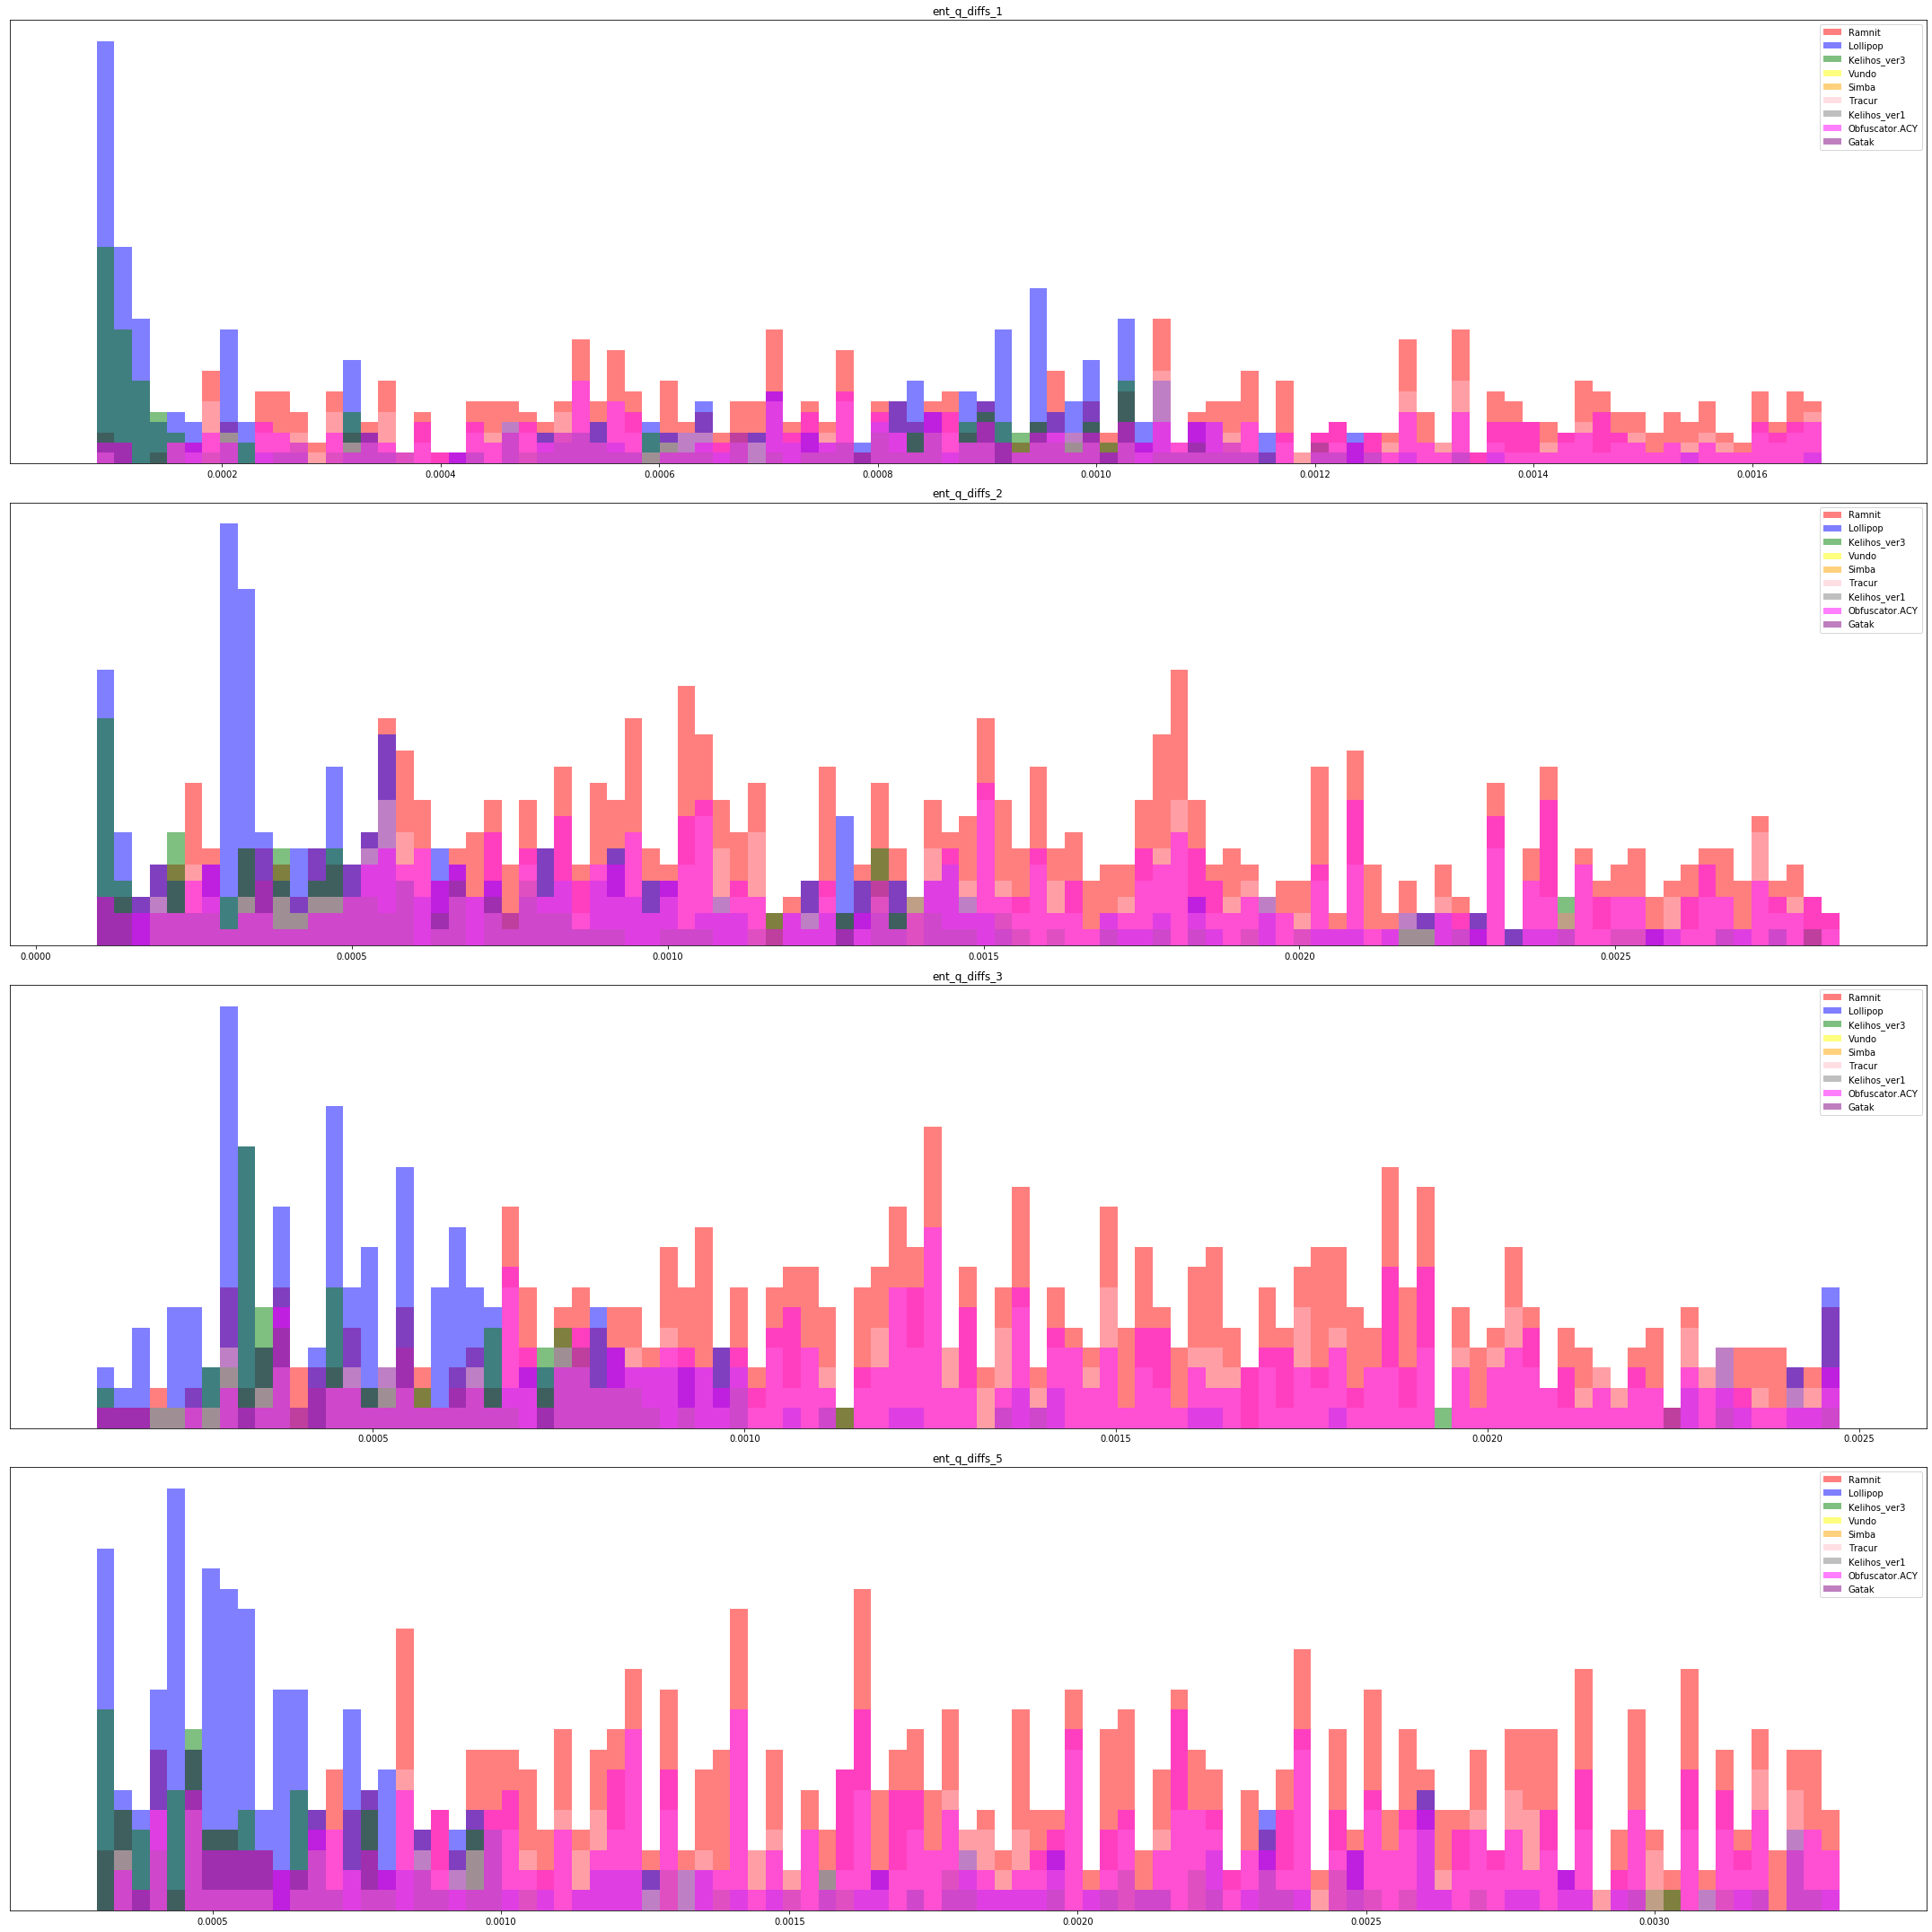

In [126]:
draw_histograms_rows_quantile( data = entropy_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [1,2,3,5], 
                              sections = 100, 
                              no_rows = 4, no_cols = 1, 
                              fig_x = 30, fig_y = 30,
                              i_want_whole_range = [False]*4)

#### slikovna reprezentacija _malwarea_
_IMG_

In [25]:
# IMAGE značajke 
image_features = features.iloc[:,462:514]
image_features.head()

byte_Img1_0   byte_Img1_1  byte_Img1_2  byte_Img1_3  byte_Img1_4  \
0     0.015560  10424.169276     0.281469  7253.810043     0.156883   
1     0.011125  10473.182086     0.271823  7191.372064     0.164023   
2     0.018087   9085.748498     0.337131  6853.347321     0.178820   
3     0.011778   9011.326305     0.365131  7096.999995     0.168553   
4     0.079121   8022.383513     0.453116  7334.630795     0.322679   

   byte_Img1_5   byte_Img1_6  byte_Img1_7  byte_Img1_8  byte_Img1_9  ...  \
0   212.615694  18591.070896     8.210199    13.388960     0.000084  ...   
1   211.027128  18292.306170     8.230688    12.850389     0.000091  ...   
2   200.000020  18327.640785     8.130132    13.127777     0.000109  ...   
3   211.663779  19376.673675     8.164637    12.428762     0.000091  ...   
4   168.166512  21316.139666     7.098649    11.328309     0.000376  ...   

   byte_Img1_42  byte_Img1_43  byte_Img1_44  byte_Img1_45  byte_Img1_46  \
0   7249.009377      0.124144    212.958541  17659.172940      8.326136   
1   7184.466418      0.086442    211.403879  15893.078448      8.487462   
2   6849.972073      0.127715    200.335102  16933.666122      8.316946   
3   7093.548415      0.106594    211.884756  16965.997099      8.429733   
4   7334.530615      0.264222    168.394193  19276.023700      7.346720   

   byte_Img1_47  byte_Img1_48  byte_Img1_49  byte_Img1_50  byte_Img1_51  
0     13.572401      0.000053      7.372721     -0.055253      0.733179  
1     13.539992      0.000026      7.537879     -0.041308      0.659622  
2     13.567806      0.000055      7.320932     -0.069984      0.791311  
3     13.363649      0.000039      7.417455     -0.046947      0.688479  
4     11.746061      0.000254      6.543933     -0.095994      0.833108  

[5 rows x 52 columns]

In [26]:
image_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

byte_Img1_51   -0.470732
byte_Img1_25   -0.469664
byte_Img1_12   -0.460057
byte_Img1_38   -0.299244
byte_Img1_32   -0.265812
byte_Img1_28   -0.201406
byte_Img1_19   -0.171105
byte_Img1_45   -0.170905
byte_Img1_42   -0.159141
byte_Img1_16   -0.159139
byte_Img1_29   -0.159130
byte_Img1_3    -0.158958
byte_Img1_6    -0.154834
byte_Img1_5    -0.103482
byte_Img1_31   -0.103427
byte_Img1_44   -0.103423
byte_Img1_18   -0.103422
byte_Img1_30   -0.065003
byte_Img1_1    -0.046981
byte_Img1_10   -0.035709
byte_Img1_40   -0.034016
byte_Img1_14   -0.033933
byte_Img1_33   -0.032933
byte_Img1_15   -0.031157
byte_Img1_41   -0.031091
byte_Img1_23   -0.029134
byte_Img1_49   -0.029102
byte_Img1_7    -0.026073
byte_Img1_20   -0.019850
byte_Img1_46   -0.019624
byte_Img1_35    0.021392
byte_Img1_21    0.028533
byte_Img1_47    0.028620
byte_Img1_2     0.029335
byte_Img1_36    0.031025
byte_Img1_8     0.036792
byte_Img1_34    0.048383
byte_Img1_27    0.066835
byte_Img1_17    0.070726
byte_Img1_43    0.070990


In [102]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( image_features, features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
accuracy_test = model.score(malware_test,malware_classes_test) # Tocnost je default mjera za LogisticRegression()
print(accuracy_test)

0.8497393437595829


C:\Users\sstan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


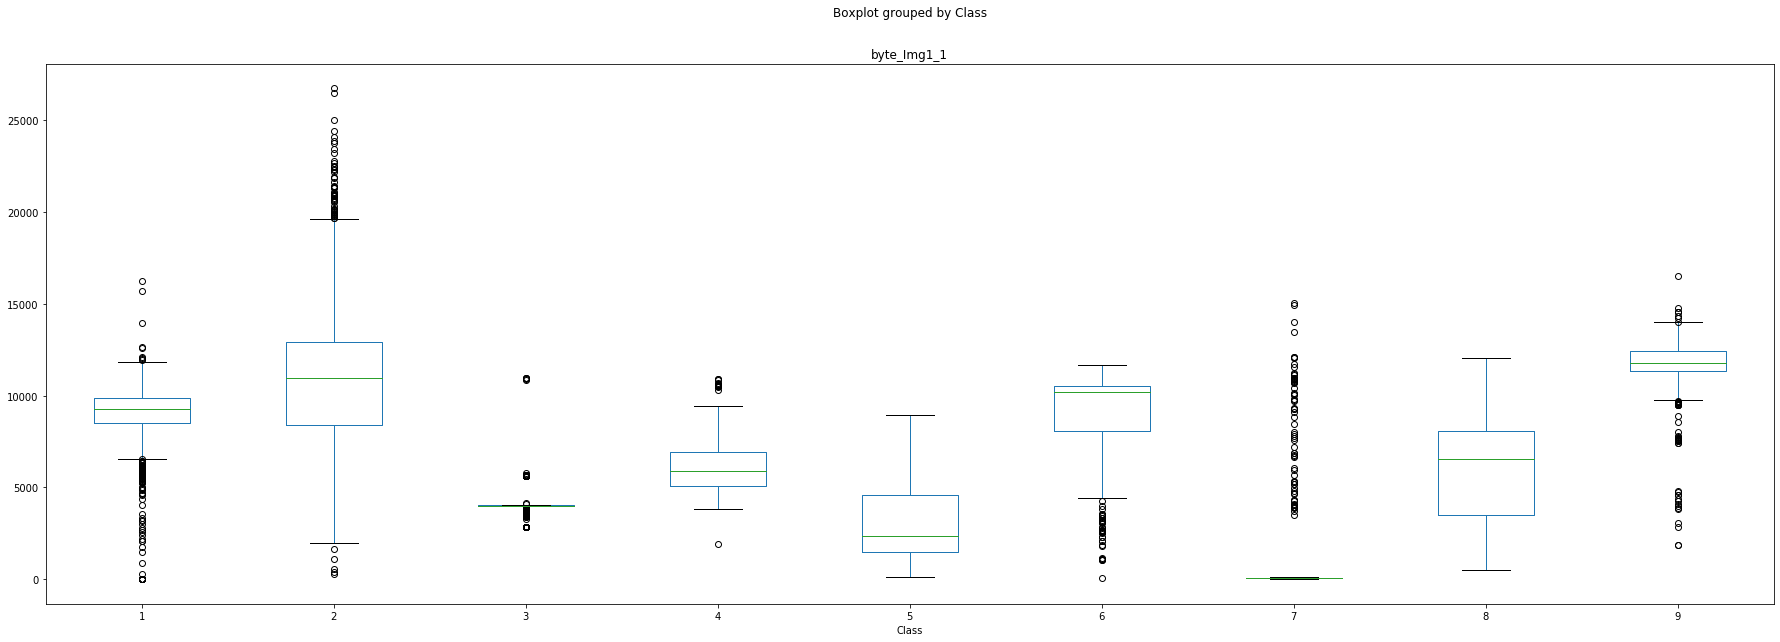

In [127]:
features.boxplot(column=[image_features.columns.values[1]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

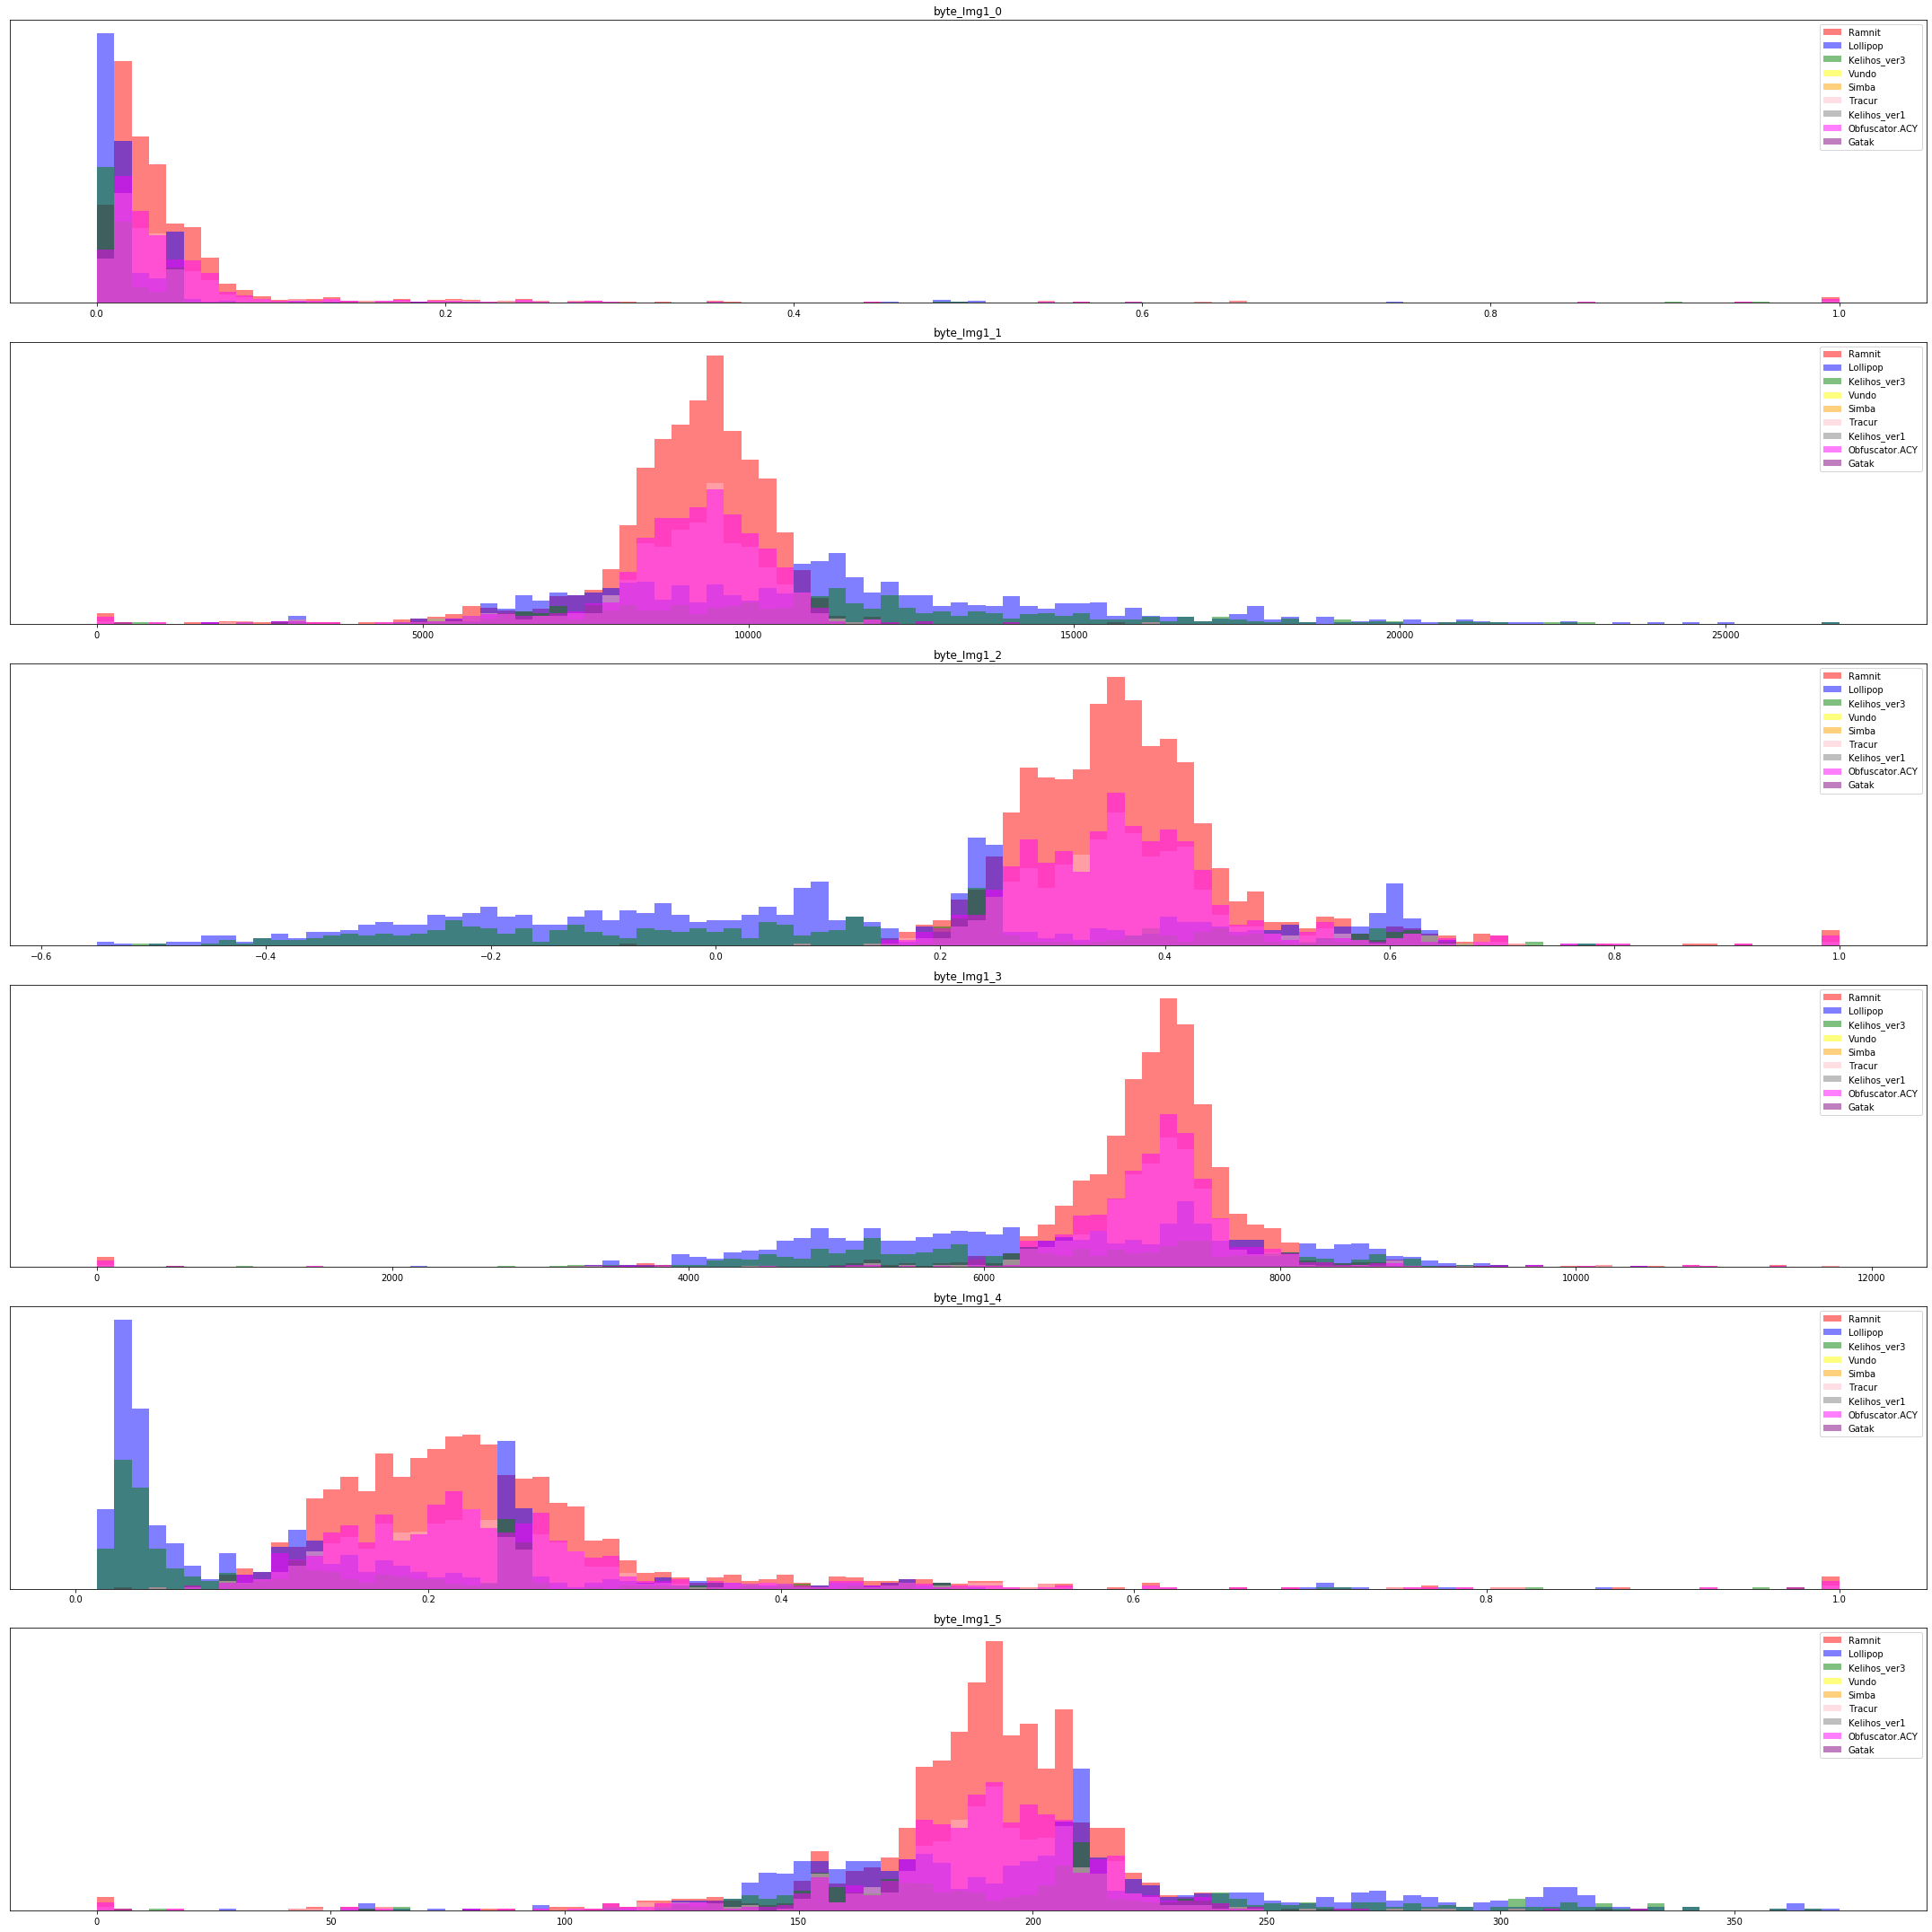

In [128]:
draw_histograms_rows_quantile( data = image_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1,2,3,4,5], 
                              sections = 100, 
                              no_rows = 6, no_cols = 1, 
                              fig_x = 30, fig_y = 30,
                              i_want_whole_range = [True]*6)

#### duljina stringova
_STR_

In [27]:
# STRING LENGTH značajke 
string_length_features = features.iloc[:,514:630]
string_length_features.head()

string_len_counts_1  string_len_counts_2  string_len_counts_3  \
0                 3780                 1026                  513   
1                 7252                  961                  102   
2                 2854                  661                  488   
3                18932                  942                  251   
4                 1283                 1082                   78   

   string_len_counts_4  string_len_counts_5  string_len_counts_6  \
0                  173                  175                   79   
1                   56                   16                   25   
2                   21                   19                    5   
3                  131                   79                   46   
4                   41                   24                   18   

   string_len_counts_7  string_len_counts_8  string_len_counts_9  \
0                   28                   20                    6   
1                   12                   13                    9   
2                   14                    3                    7   
3                   46                   54                   61   
4                   17                    8                    9   

   string_len_counts_10  ...  string_len_counts_250_400  \
0                    10  ...                          0   
1                     8  ...                          0   
2                     5  ...                          0   
3                    54  ...                          0   
4                    15  ...                          0   

   string_len_counts_400_600  string_len_counts_600_900  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   string_len_counts_900_1300  string_len_counts_1300_2000  \
0                           0                            0   
1                           0                            1   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   string_len_counts_2000_3000  string_len_counts_3000_6000  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   string_len_counts_6000_15000  string_total_len  string_ratio  
0                             1              9664      0.049154  
1                             1             11961      0.048669  
2                             1             15716      0.106581  
3                             1             41668      0.051639  
4                             1              5252      0.032056  

[5 rows x 116 columns]

In [28]:
string_length_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

string_len_counts_52           -0.321184
string_len_counts_43           -0.272064
string_len_counts_98           -0.255179
string_len_counts_37           -0.249502
string_len_counts_36           -0.244991
                                  ...   
string_len_counts_600_900       0.238721
string_len_counts_6000_15000    0.268951
string_len_counts_4             0.286978
string_len_counts_2             0.332577
string_ratio                    0.349599
Length: 116, dtype: float64

In [119]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( string_length_features.dropna(), features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
accuracy_test = model.score(malware_test,malware_classes_test) # Tocnost je default mjera za LogisticRegression()
print(accuracy_test)

0.8460594909536951


C:\Users\sstan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


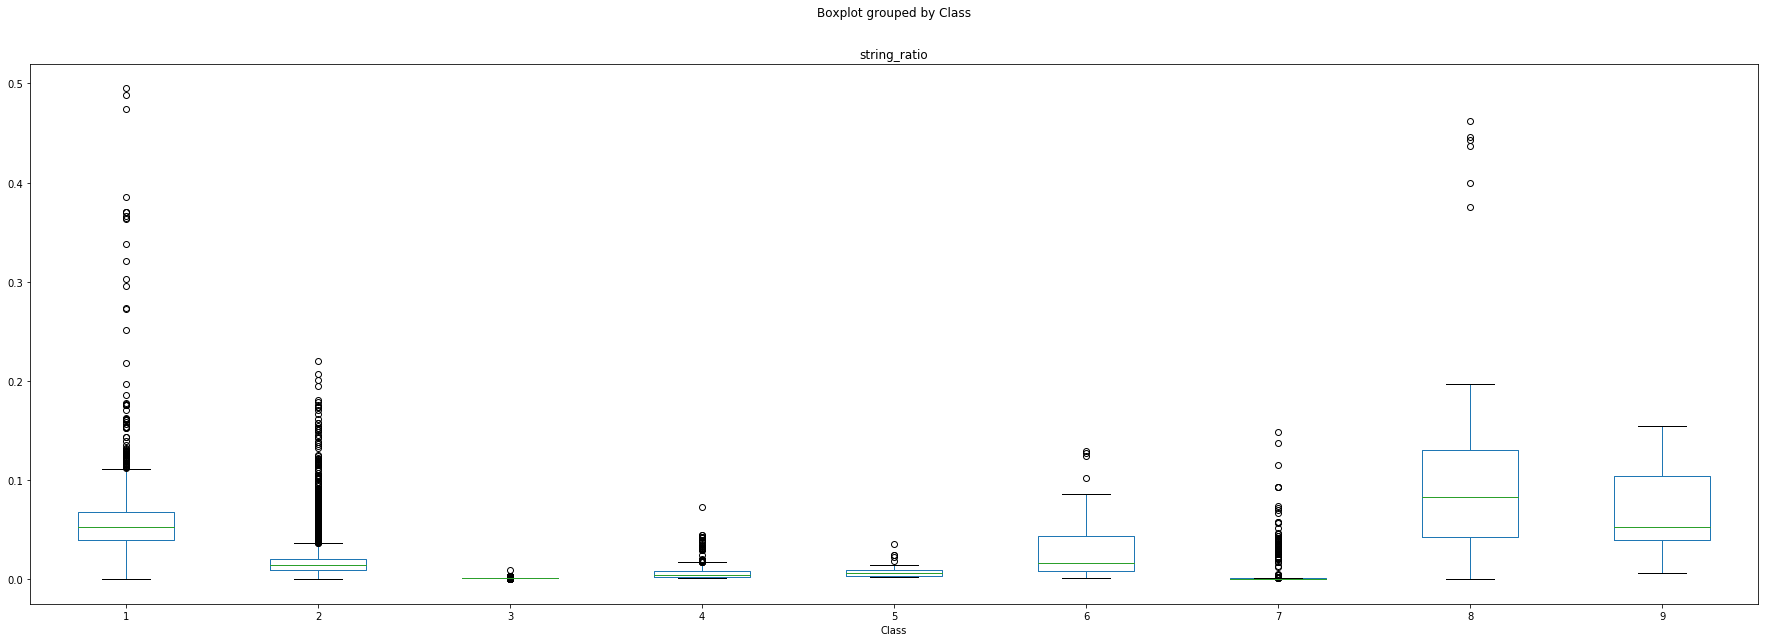

In [129]:
features.boxplot(column=[string_length_features.columns.values[-1]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

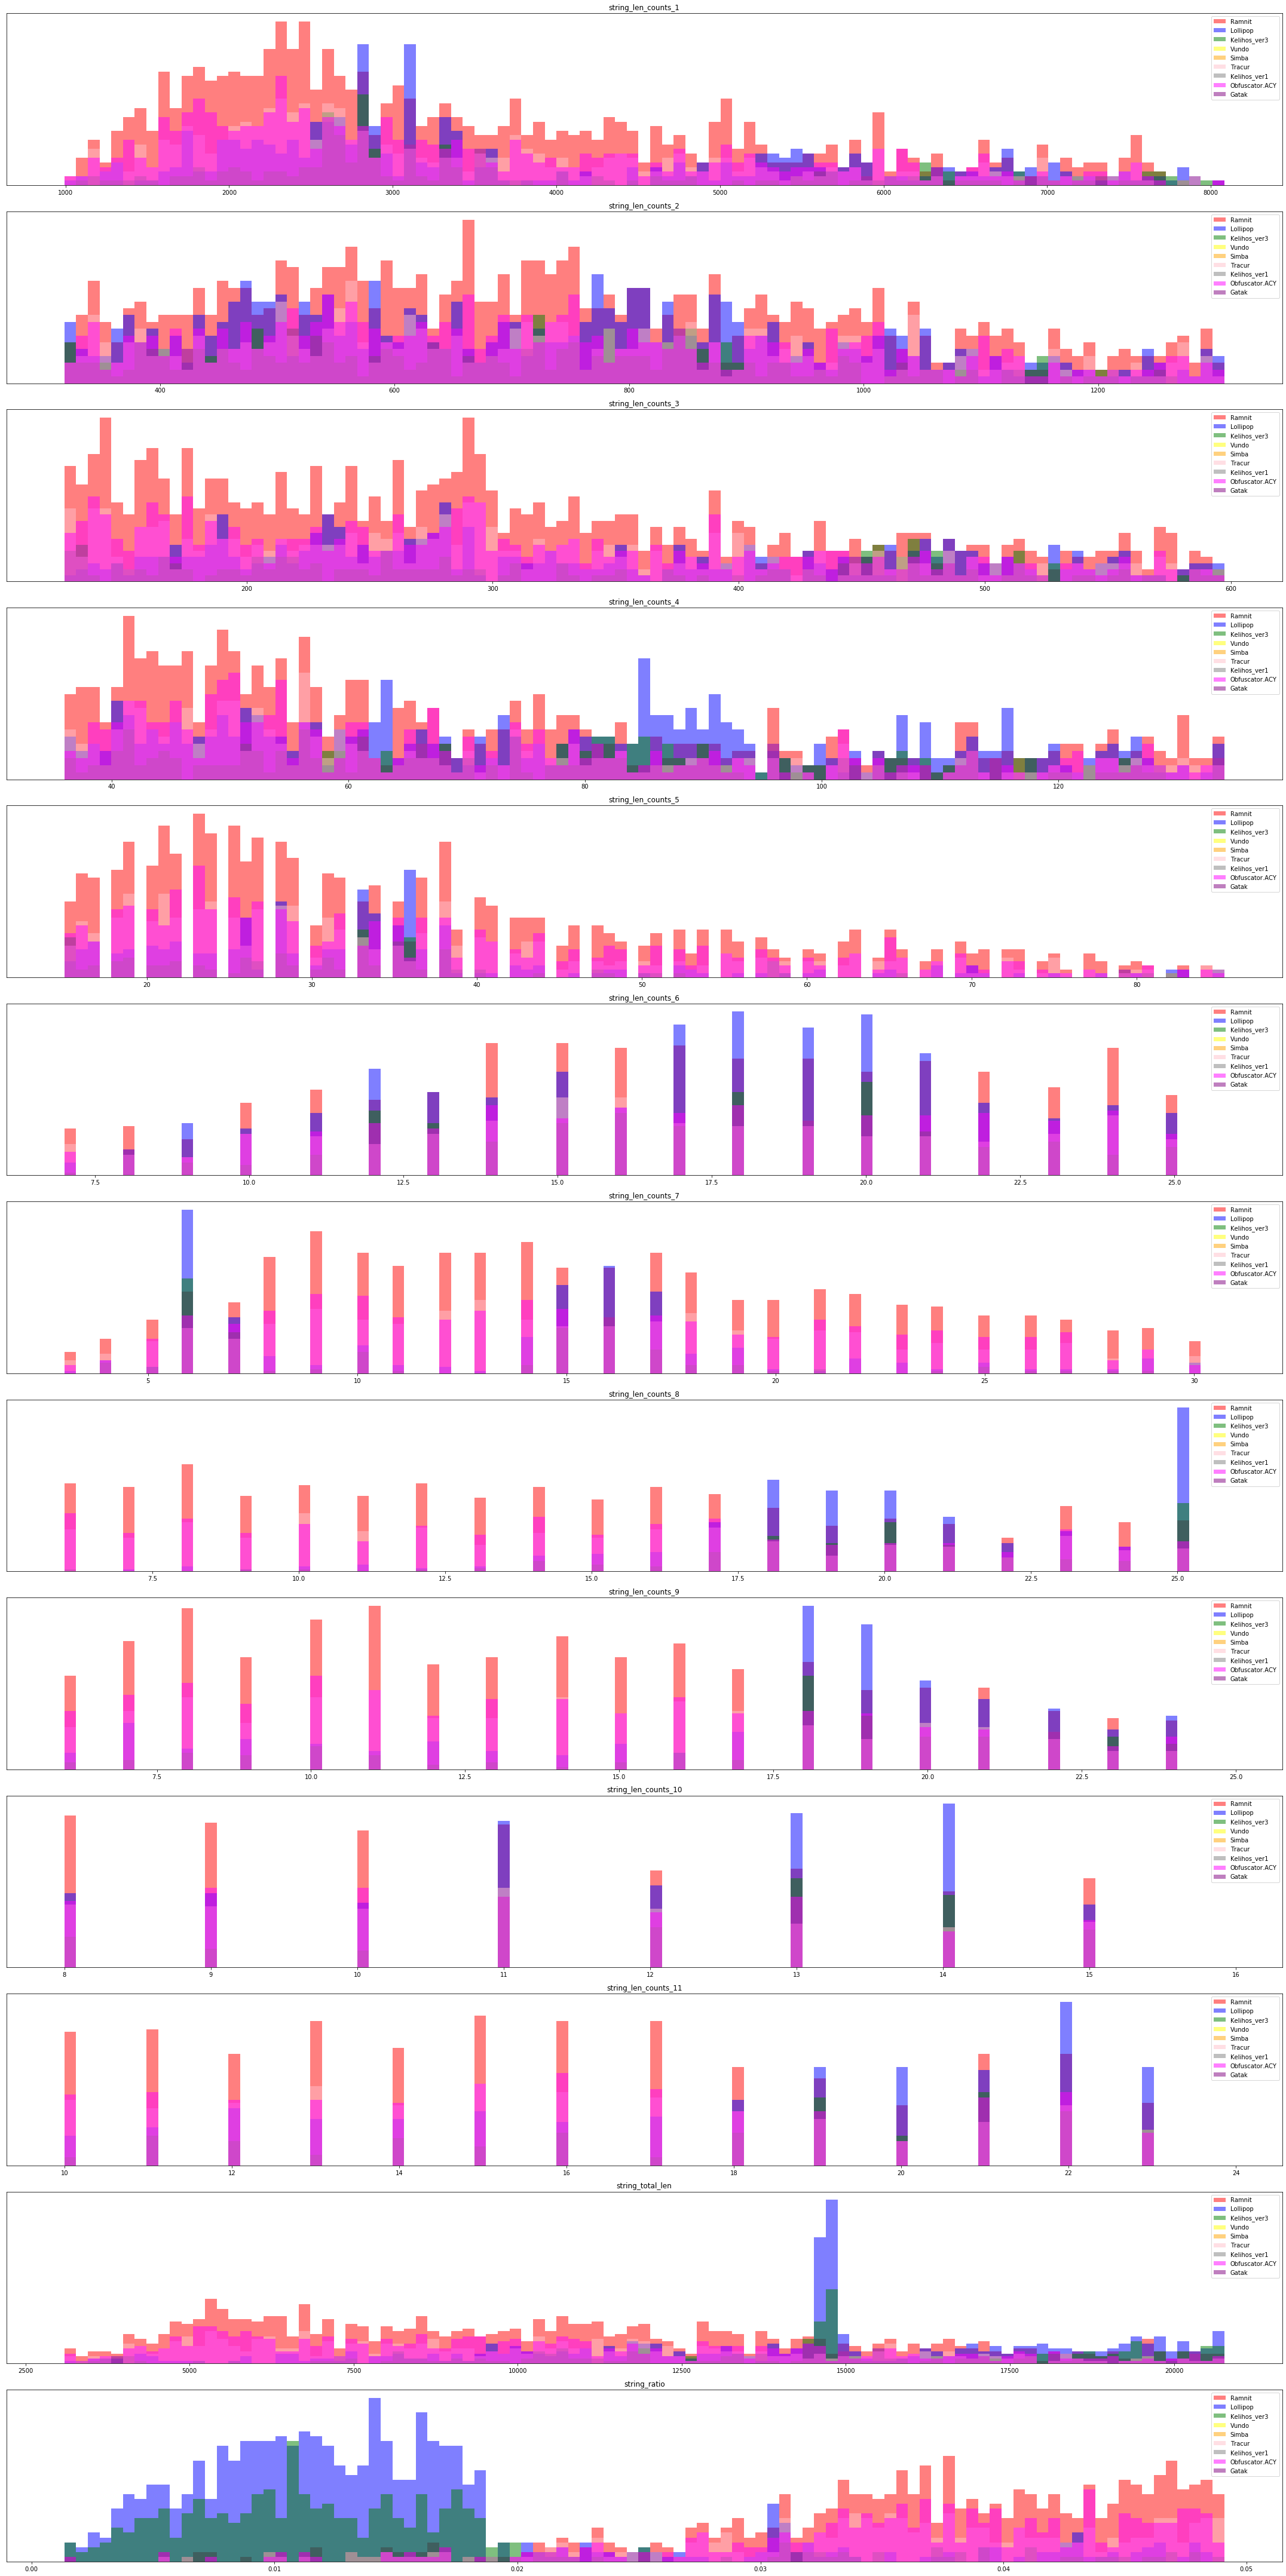

In [130]:
draw_histograms_rows_quantile( data = string_length_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1,2,3,4,5,6,7,8,9,10,-2,-1], 
                              sections = 100, 
                              no_rows = 13, no_cols = 1, 
                              fig_x = 30, fig_y = 60,
                              i_want_whole_range = [False]*13)

<br>
<br>

### _featuri_ dobiveni iz .asm datoteke

#### (asm) metadata
_MDA_

In [29]:
# METADATA značajke iz asm datoteka
metadata_asm_features = features.iloc[:,630:632]
metadata_asm_features.head()

asm_md_filesize  asm_md_loc
0            14726        1276
1           606128       64610
2           133226       15897
3          1906854      231388
4           131451       16827

In [30]:
metadata_asm_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

asm_md_loc        -0.183667
asm_md_filesize   -0.162931
dtype: float64

In [118]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( metadata_asm_features.dropna(), features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
accuracy_test = model.score(malware_test,malware_classes_test) # Tocnost je default mjera za LogisticRegression()
print(accuracy_test)

0.22355105795768168


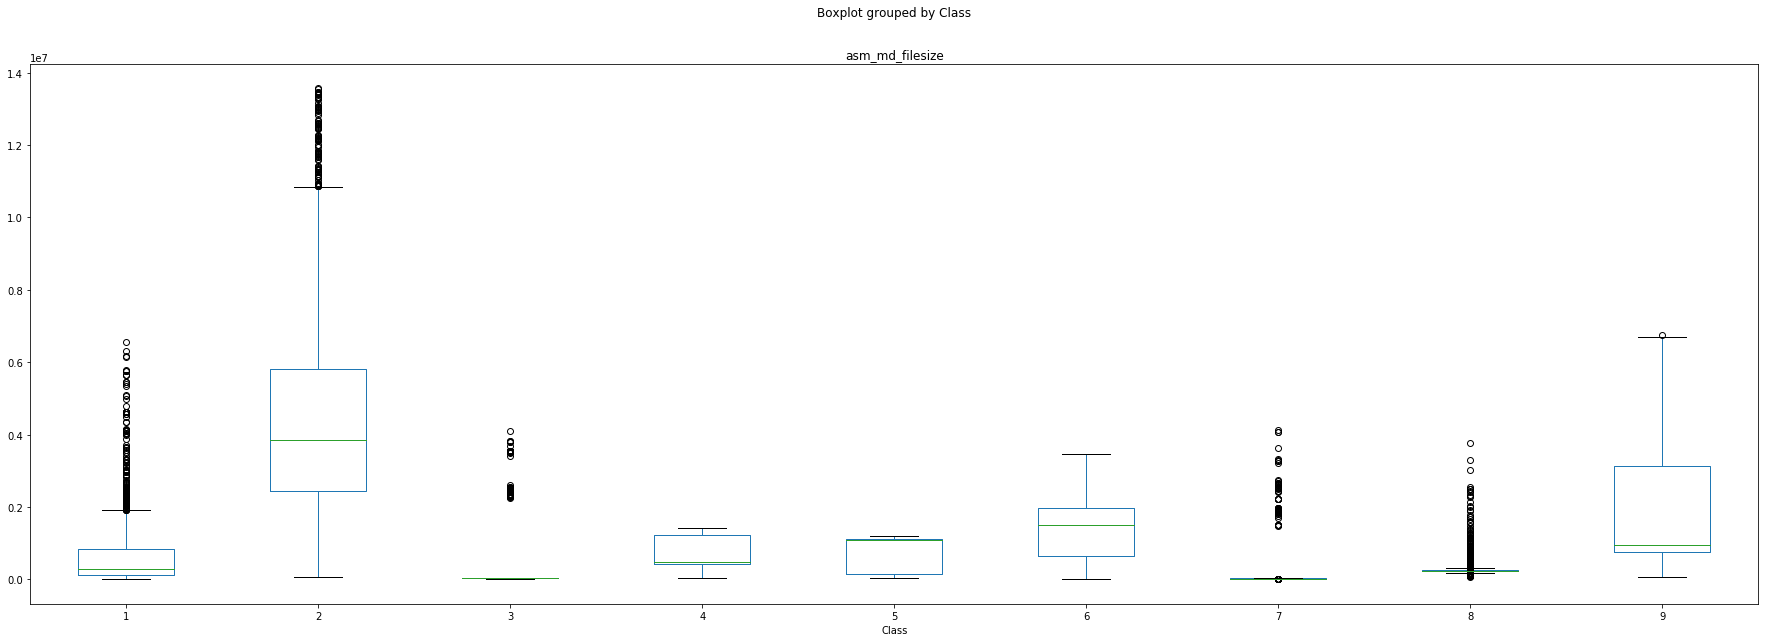

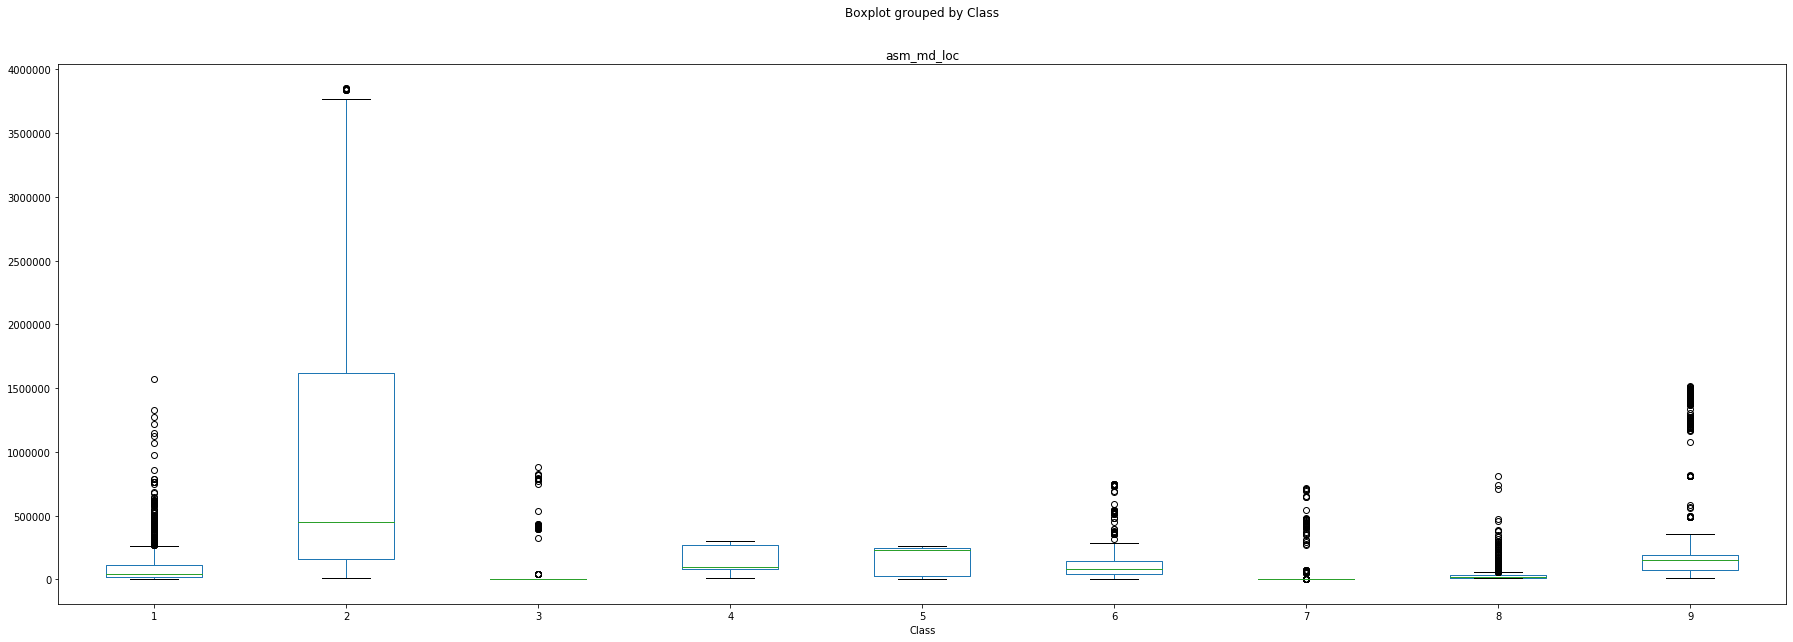

In [131]:
features.boxplot(column=[metadata_asm_features.columns.values[0]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))
features.boxplot(column=[metadata_asm_features.columns.values[1]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

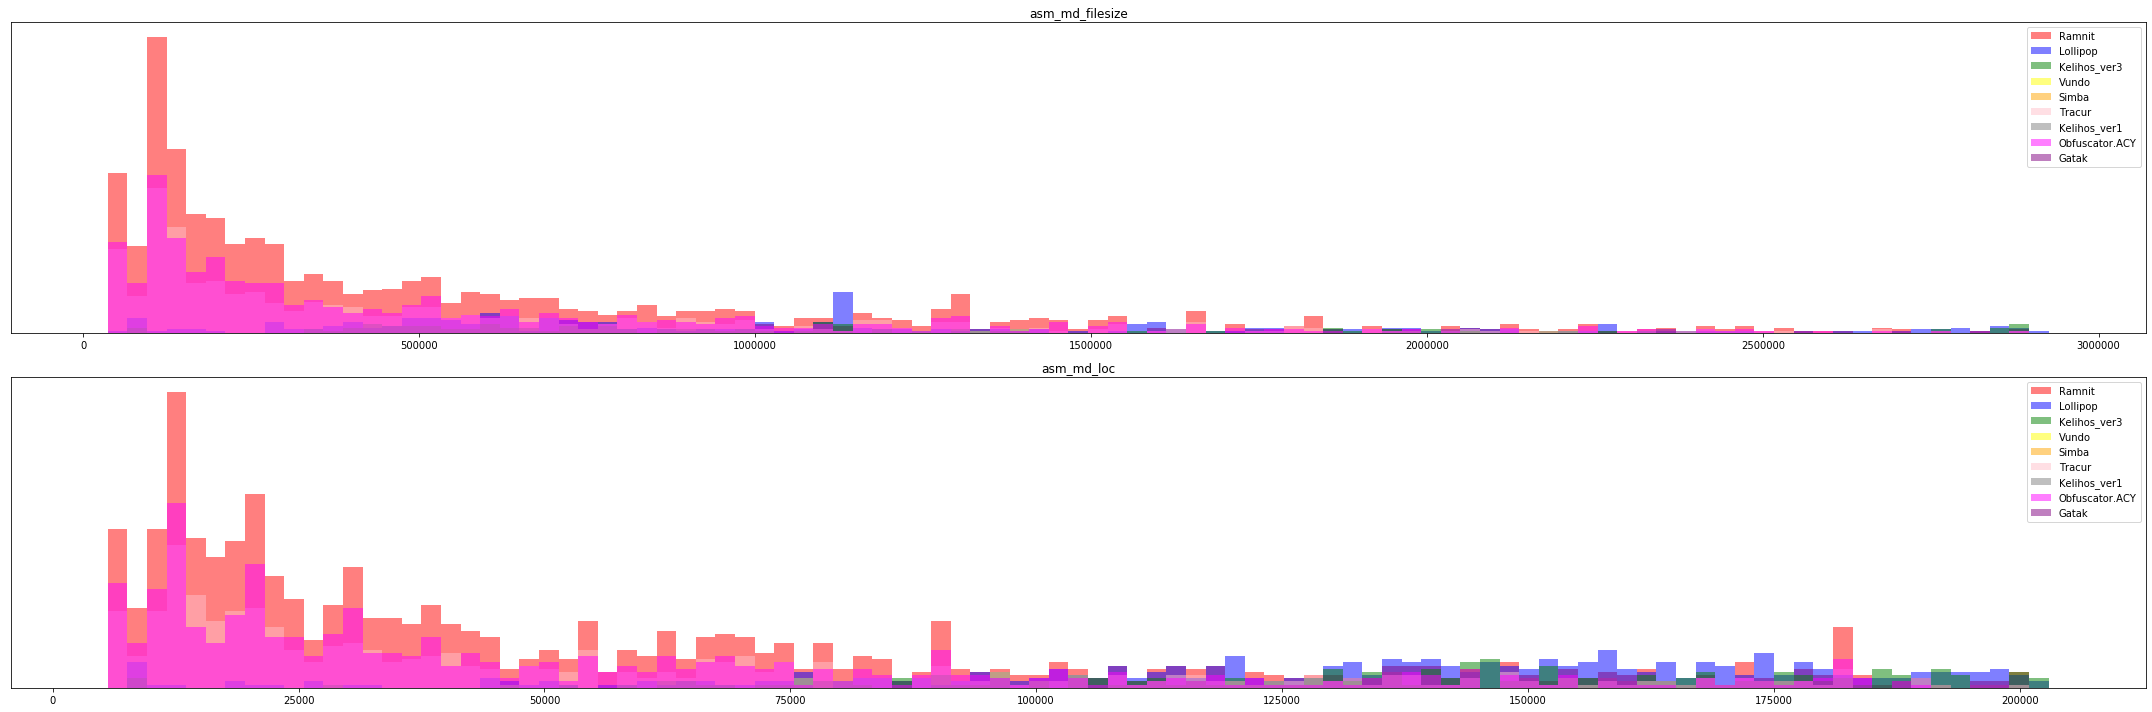

In [132]:
draw_histograms_rows_quantile( data = metadata_asm_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1], 
                              sections = 100, 
                              no_rows = 2, no_cols = 1, 
                              fig_x = 30, fig_y = 10,
                              i_want_whole_range = [False]*2)

#### simboli
_SYM_

In [31]:
# SYMBOLS značajke
symbols_features = features.iloc[:,632:639]
symbols_features.head()

asm_symb_Star  asm_symb_Dash  asm_symb_Plus  asm_symb_Bracket_Open  \
0             10             94            216                    125   
1           6876           5085          14173                  11375   
2            651            664           3263                   2287   
3            826          14382          56341                  41569   
4            123            774           3661                   2663   

   asm_symb_Bracket_Close  asm_symb_AtSign  asm_symb_Question  
0                     125               34                 53  
1                   11375             5551               5045  
2                    2287             1350               1349  
3                   41573               24                608  
4                    2663               12                138

In [32]:
symbols_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

asm_symb_Bracket_Close   -0.191981
asm_symb_Bracket_Open    -0.172280
asm_symb_Plus            -0.138143
asm_symb_AtSign          -0.079919
asm_symb_Dash            -0.077858
asm_symb_Question        -0.046166
asm_symb_Star            -0.034939
dtype: float64

In [117]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( symbols_features.dropna(), features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
accuracy_test = model.score(malware_test,malware_classes_test) # Tocnost je default mjera za LogisticRegression()
print(accuracy_test)

0.5700705305121129


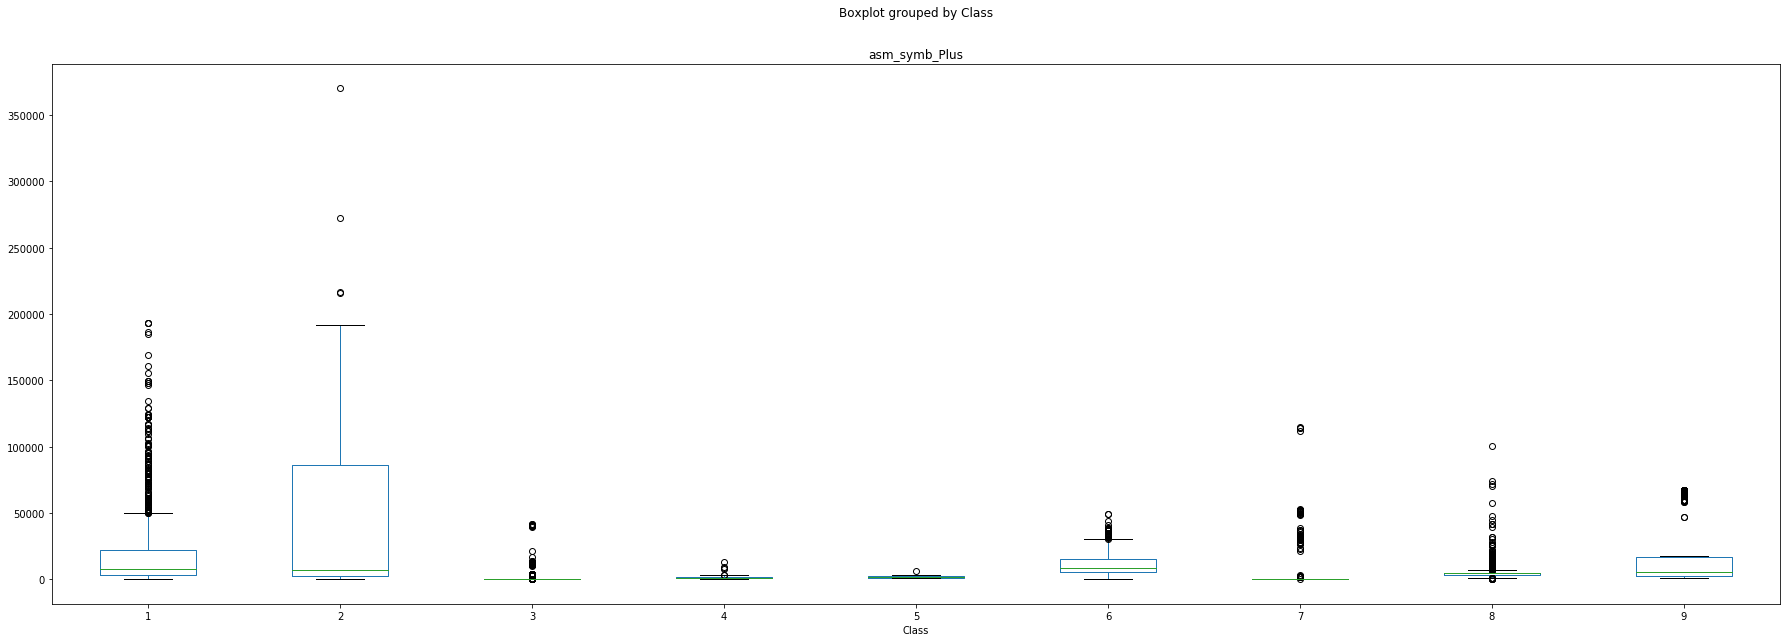

In [133]:
features.boxplot(column=[symbols_features.columns.values[2]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

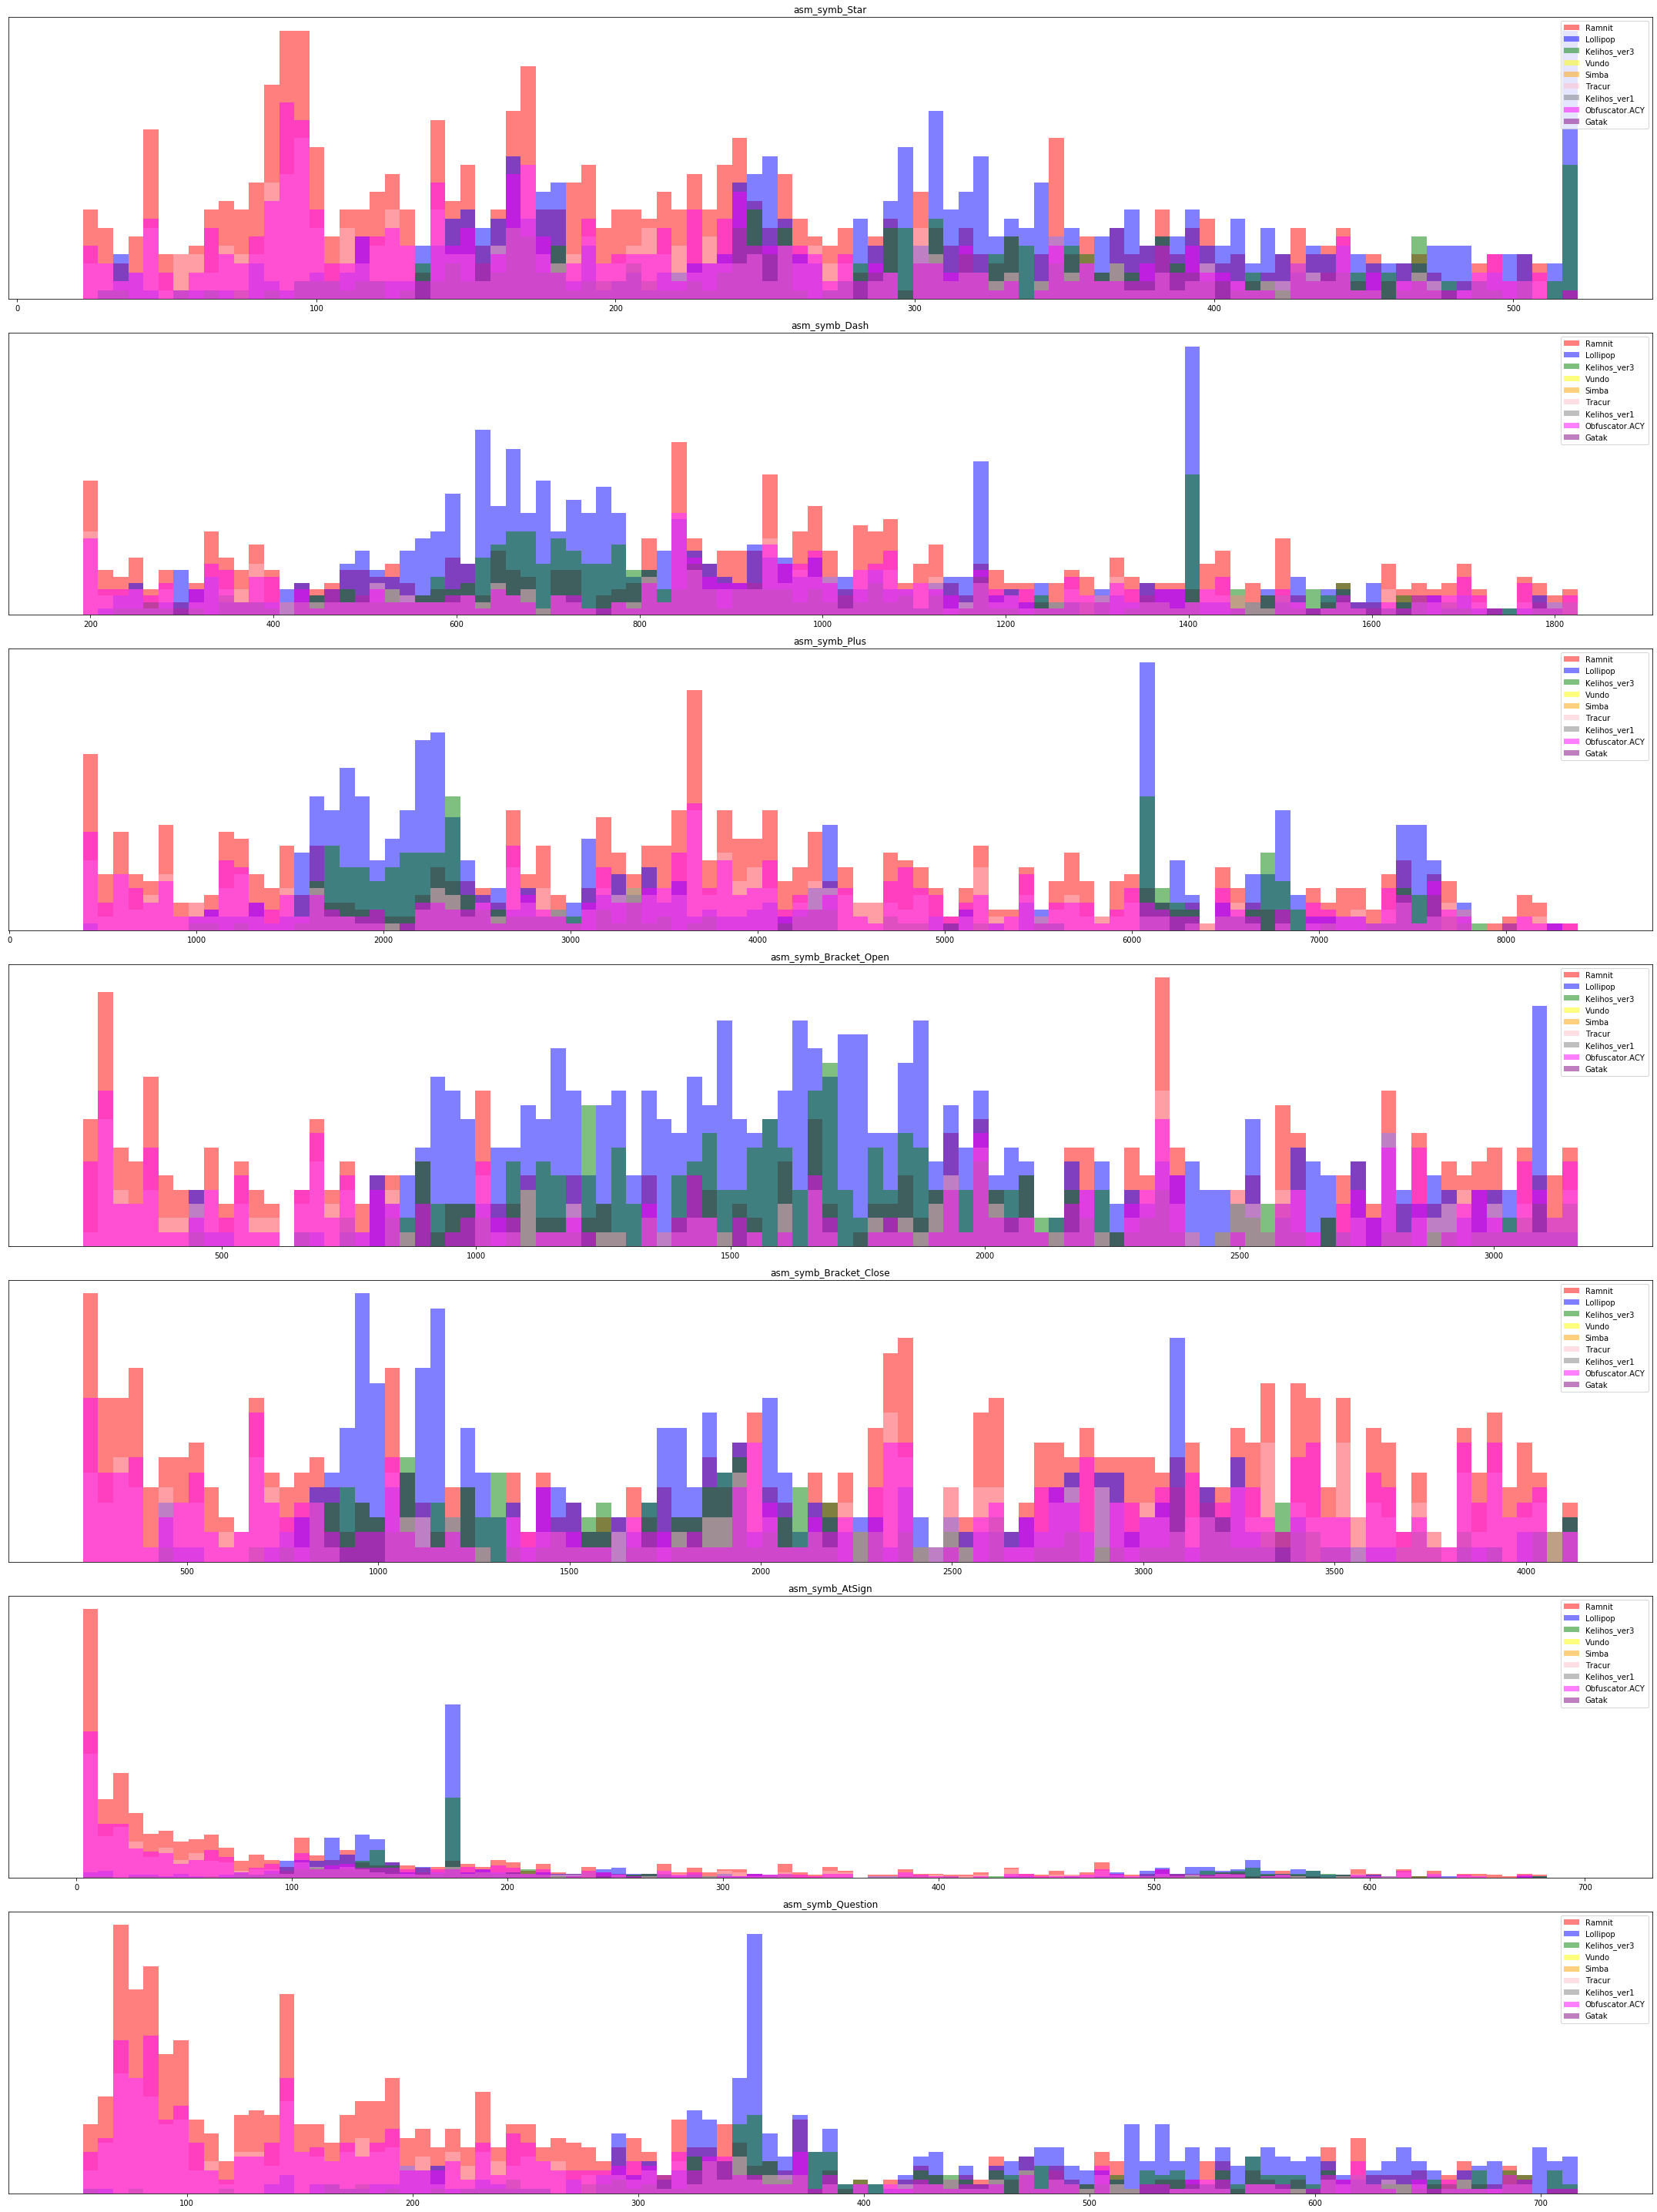

In [134]:
draw_histograms_rows_quantile( data = symbols_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [i for i in range(7)], 
                              sections = 100, 
                              no_rows = 7, no_cols = 1, 
                              fig_x = 30, fig_y = 40,
                              i_want_whole_range = [False]*7)

#### opcode
_OPC_

In [33]:
# OPCODE značajke
opcode_features = features.iloc[:,639:732]
opcode_features.head()

asm_opcodes_add  asm_opcodes_al  asm_opcodes_bt  asm_opcodes_call  \
0               11               1               0                53   
1              356              25               0              2900   
2              176              31               0               461   
3             1214             285               0             10686   
4              532               2               0               462   

   asm_opcodes_cdq  asm_opcodes_cld  asm_opcodes_cli  asm_opcodes_cmc  \
0                0                0                0                0   
1                1                0                0                0   
2                2                0                0                0   
3               25                5                1                0   
4                2                1                0                0   

   asm_opcodes_cmp  asm_opcodes_const  ...  asm_opcodes_sidt  asm_opcodes_stc  \
0               15                  4  ...                 0                0   
1             1585               2259  ...                 0                0   
2              320                123  ...                 0                0   
3             7071                176  ...                 0                2   
4              539                  5  ...                 0                0   

   asm_opcodes_std  asm_opcodes_sti  asm_opcodes_stos  asm_opcodes_sub  \
0                0                0                 0                5   
1                0                0                 0              311   
2                0                0                 0               73   
3                4                0                 0             1240   
4                0                0                 0              221   

   asm_opcodes_test  asm_opcodes_wait  asm_opcodes_xchg  asm_opcodes_xor  
0                14                 0                 0               17  
1               817                 0                 1              739  
2               183                 0                 0              180  
3              4996                 1                 3             2901  
4               362                 0                38              254  

[5 rows x 93 columns]

In [34]:
opcode_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

asm_opcodes_jb      -0.227684
asm_opcodes_jnz     -0.222423
asm_opcodes_pop     -0.219832
asm_opcodes_mov     -0.216970
asm_opcodes_endp    -0.213391
                       ...   
asm_opcodes_dw       0.119271
asm_opcodes_cli      0.119755
asm_opcodes_stos     0.127170
asm_opcodes_ends     0.137943
asm_opcodes_loope    0.186105
Length: 90, dtype: float64

In [116]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( opcode_features.dropna(), features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
accuracy_test = model.score(malware_test,malware_classes_test) # Tocnost je default mjera za LogisticRegression()
print(accuracy_test)

0.9500153327200246


C:\Users\sstan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


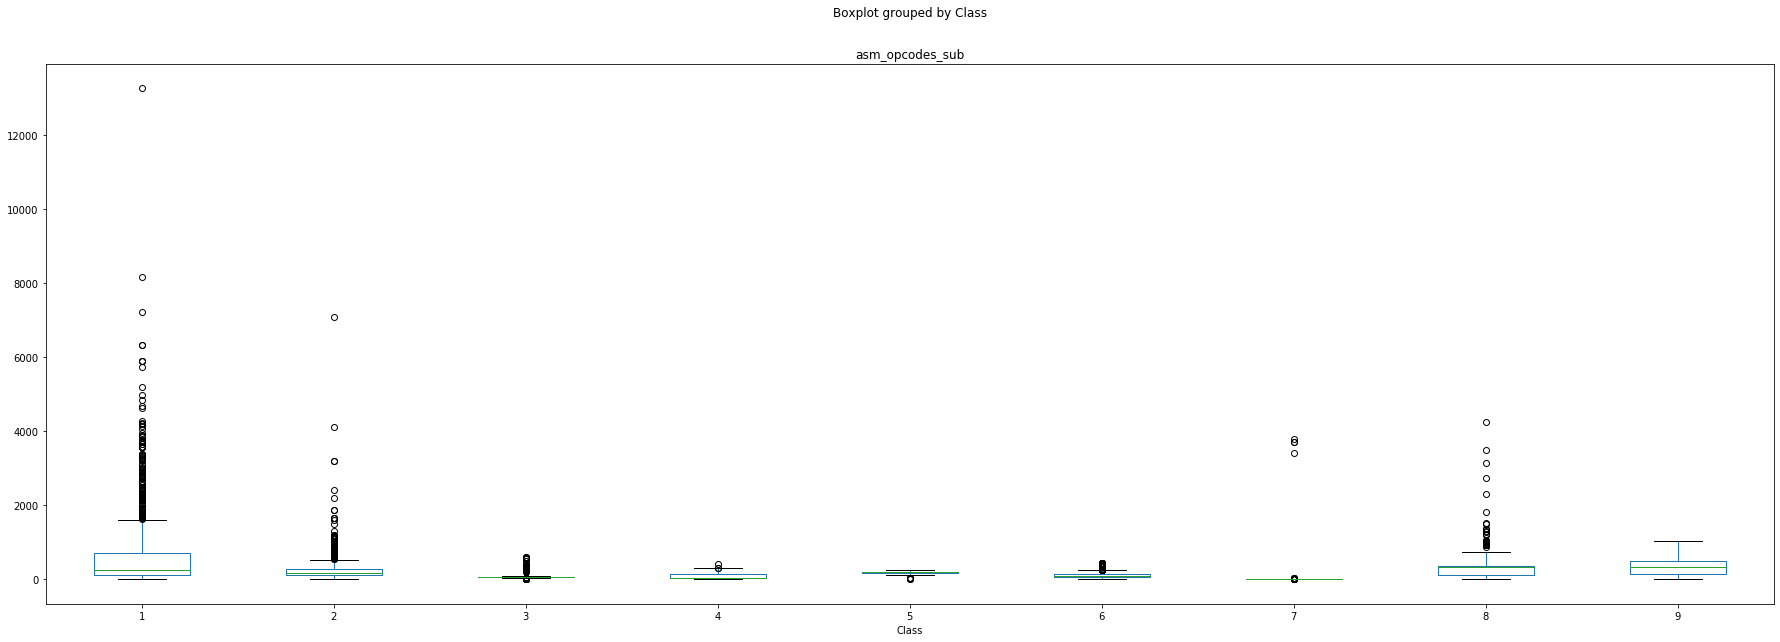

In [135]:
features.boxplot(column=[opcode_features.columns.values[-5]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

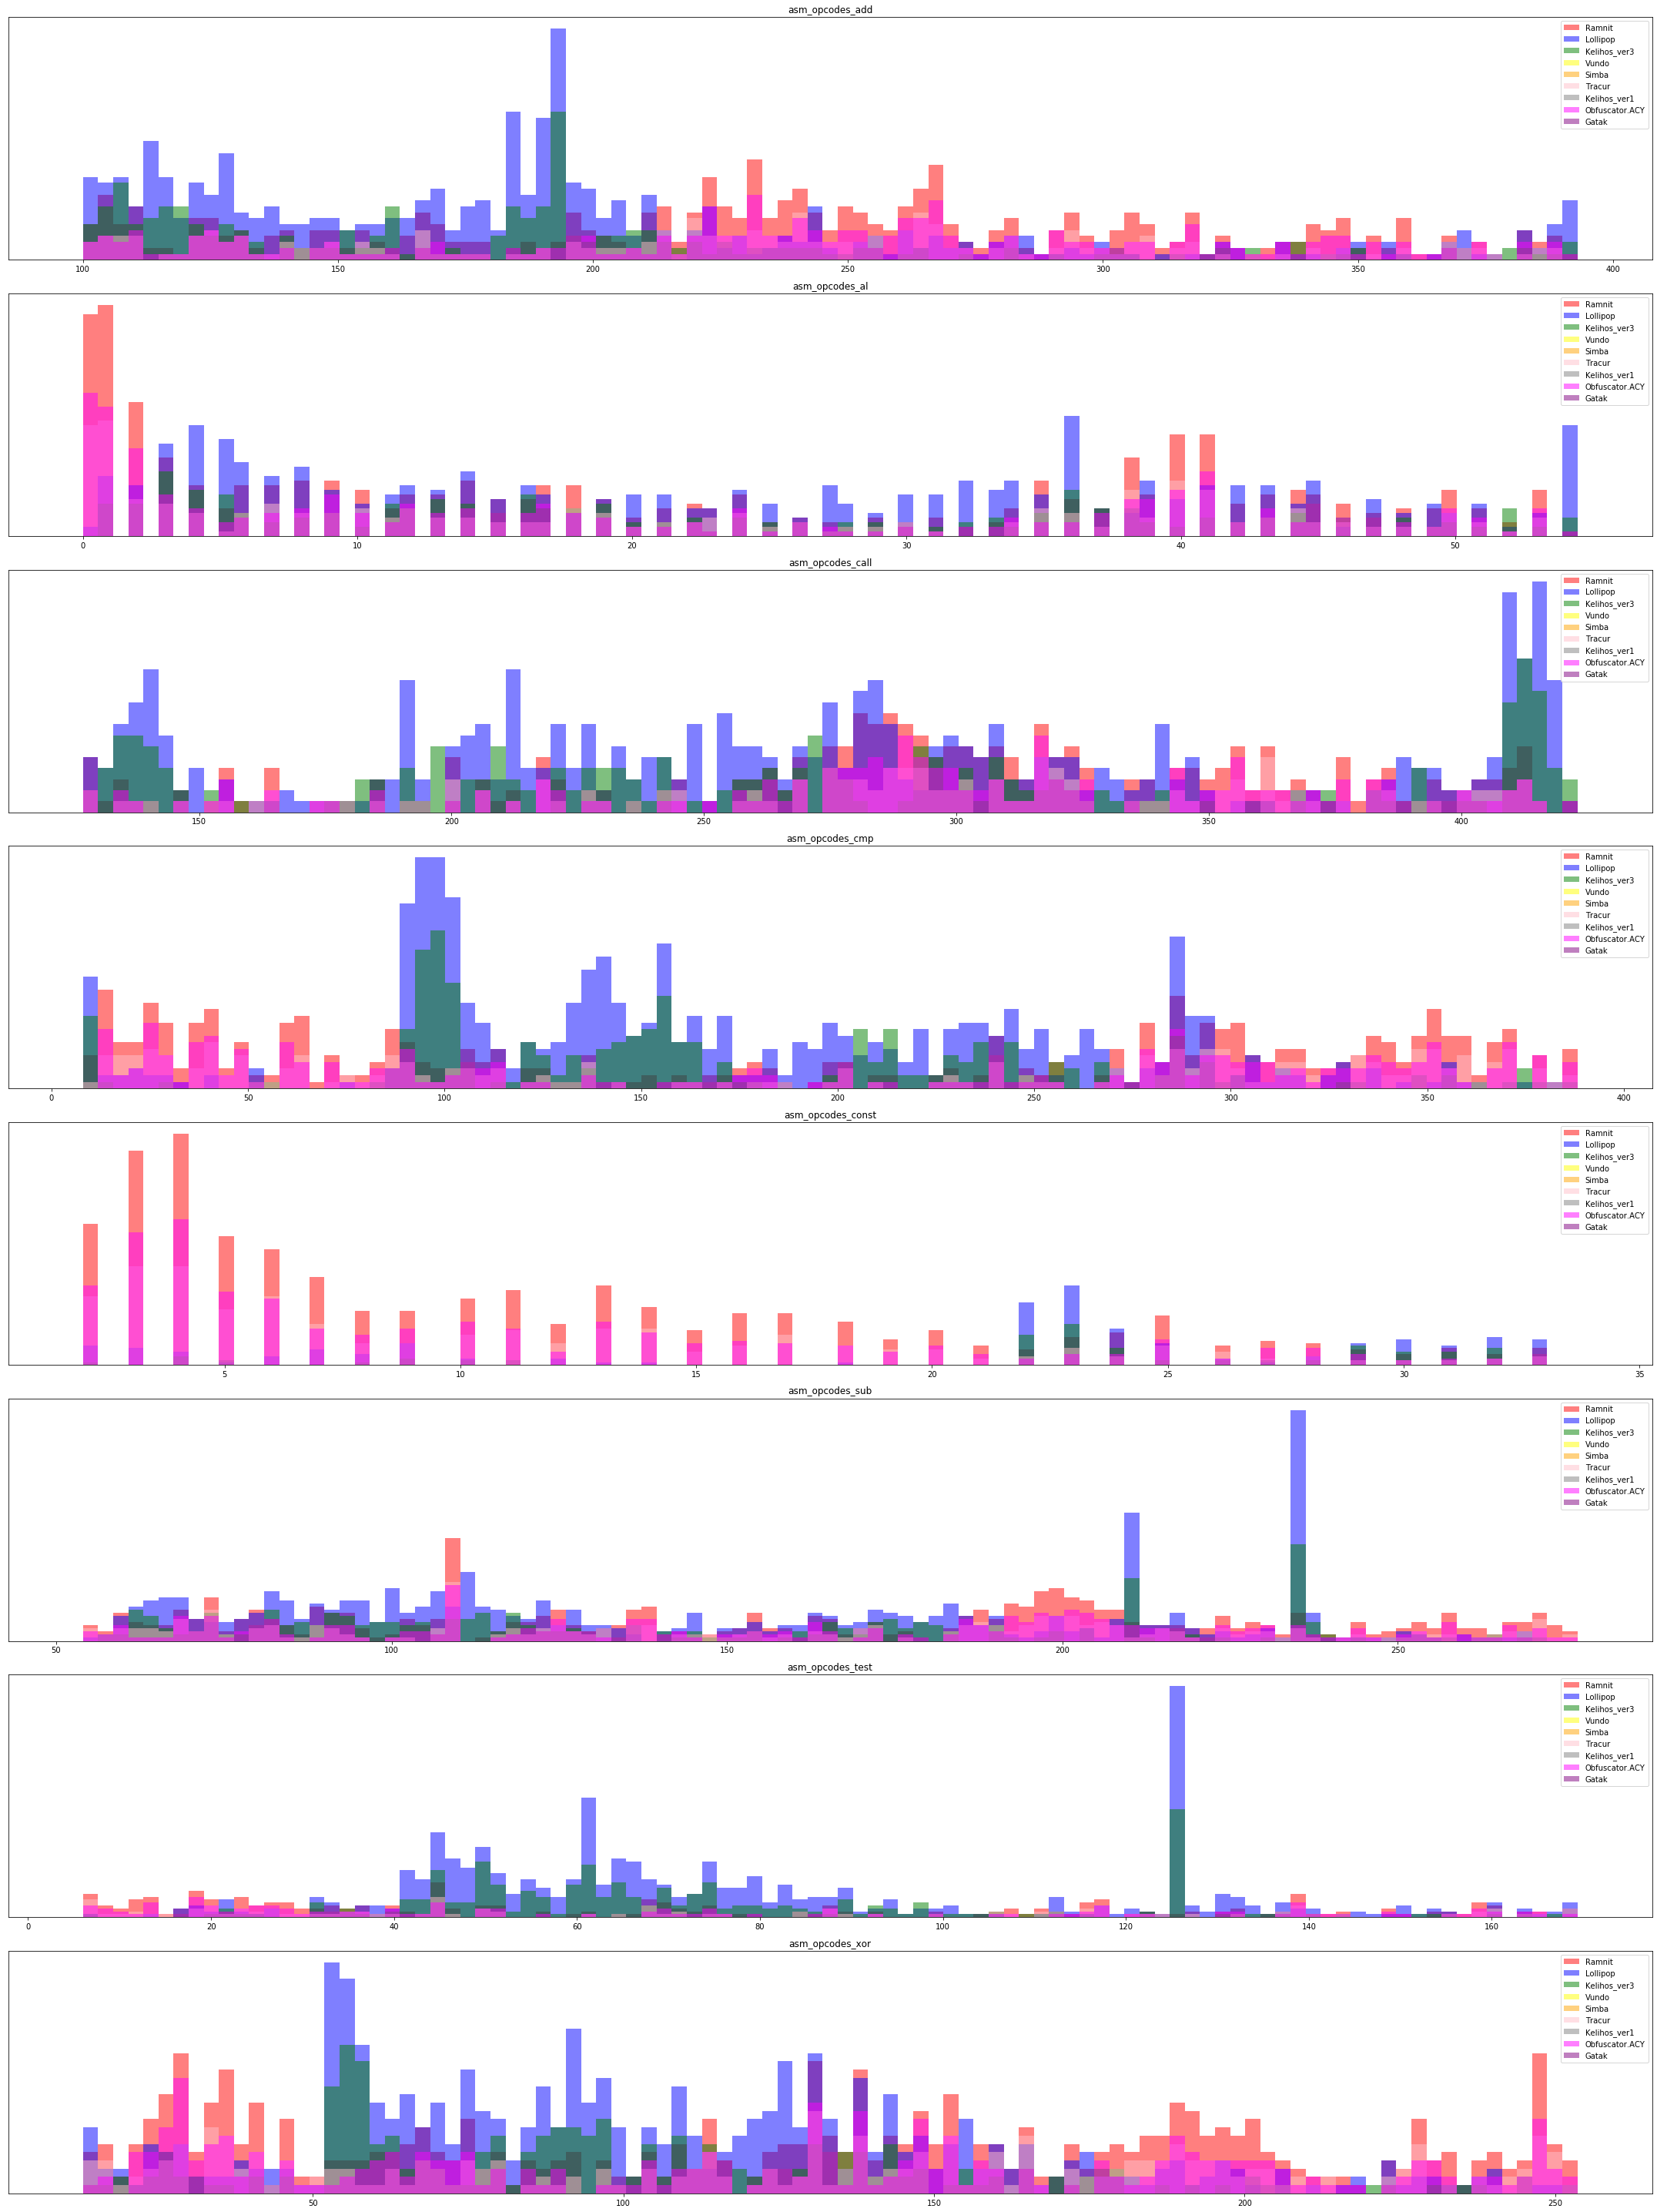

In [136]:
draw_histograms_rows_quantile( data = opcode_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1,3,8,9,-5,-4,-1], 
                              sections = 100, 
                              no_rows = 8, no_cols = 1, 
                              fig_x = 30, fig_y = 40,
                              i_want_whole_range = [False]*8)

#### registri
_REG_

In [35]:
# REGISTER značajke
reg_features = features.iloc[:,732:758]
reg_features.head()

asm_regs_edx  asm_regs_esi  asm_regs_es  asm_regs_fs  asm_regs_ds  \
0            23            35            0            0            0   
1           936          5027            1            1            1   
2          1011           895            0            1            0   
3          3942         19687            1            1            1   
4          1058          1402            1            1            1   

   asm_regs_ss  asm_regs_gs  asm_regs_cs  asm_regs_ah  asm_regs_al  ...  \
0            0            0            0            0            3  ...   
1            1            1            1            3           45  ...   
2            0            1            0            0           60  ...   
3            2            1            1           28          597  ...   
4            1            1            1            0           22  ...   

   asm_regs_cx  asm_regs_dh  asm_regs_dl  asm_regs_dx  asm_regs_eax  \
0            0            0            0            0           137   
1           33            4           15           20          9839   
2            4            0           15            0          2111   
3           94            8          232           46         41449   
4            2            0            5            0          2637   

   asm_regs_ebp  asm_regs_ebx  asm_regs_ecx  asm_regs_edi  asm_regs_esp  
0            43            19            66            15            81  
1          6382          2511          5024          3972           713  
2           446           444          1378           562           730  
3         28751         11489         15737         16619          2832  
4           930           930          1561          1240           844  

[5 rows x 26 columns]

In [36]:
reg_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

asm_regs_esi   -0.250088
asm_regs_eax   -0.231631
asm_regs_edi   -0.227145
asm_regs_ecx   -0.222115
asm_regs_ebx   -0.213319
asm_regs_cl    -0.184096
asm_regs_cx    -0.181143
asm_regs_ebp   -0.179819
asm_regs_bl    -0.178614
asm_regs_edx   -0.173050
asm_regs_dx    -0.171895
asm_regs_esp   -0.171745
asm_regs_ax    -0.166863
asm_regs_al    -0.136881
asm_regs_bx    -0.127162
asm_regs_dl    -0.113398
asm_regs_ah    -0.082052
asm_regs_fs    -0.015427
asm_regs_gs    -0.007415
asm_regs_dh    -0.006703
asm_regs_ch    -0.004324
asm_regs_es     0.017658
asm_regs_bh     0.036370
asm_regs_ds     0.064211
asm_regs_ss     0.090720
asm_regs_cs     0.107755
dtype: float64

In [115]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( reg_features.dropna(), features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
accuracy_test = model.score(malware_test,malware_classes_test) # Tocnost je default mjera za LogisticRegression()
print(accuracy_test)

0.8991107022385771


C:\Users\sstan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


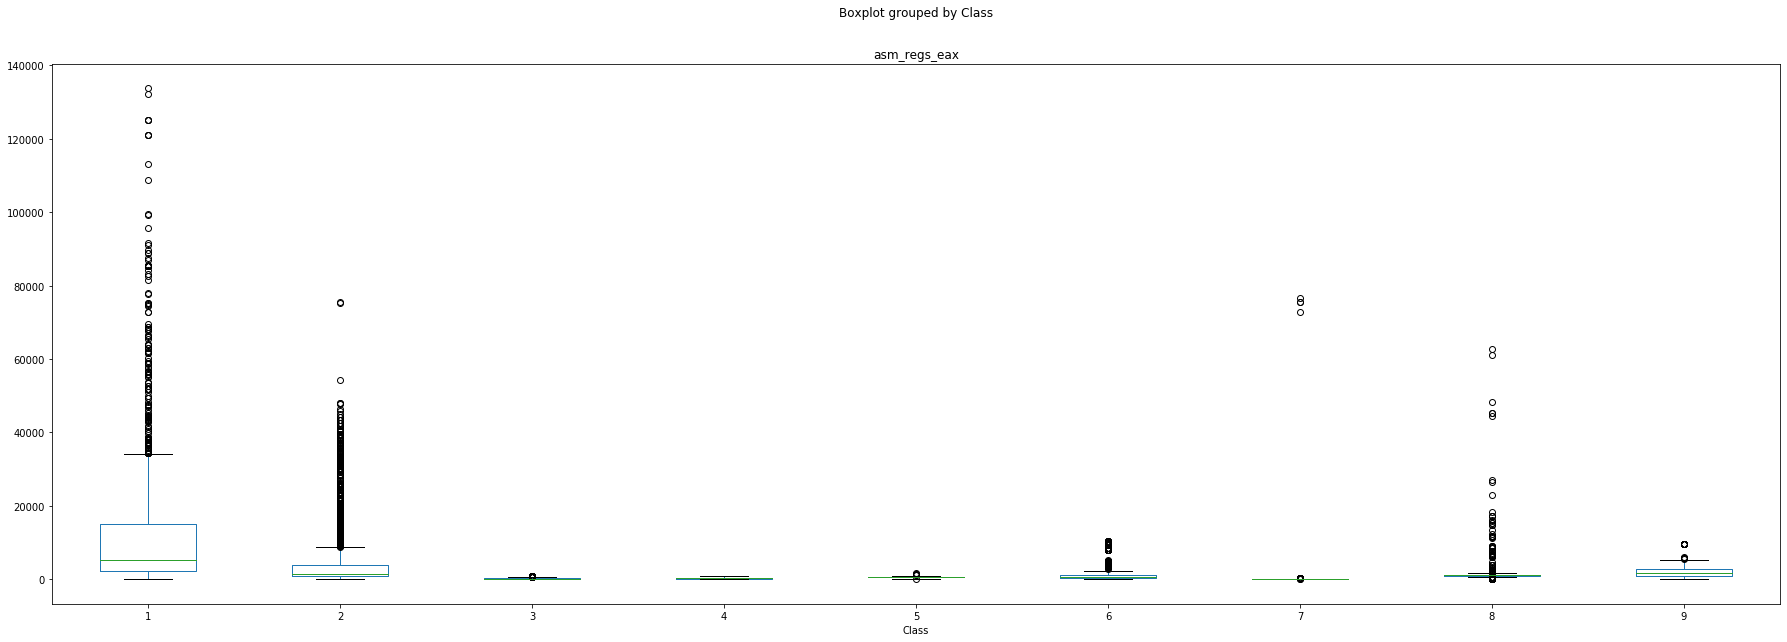

In [137]:
features.boxplot(column=[reg_features.columns.values[-6]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

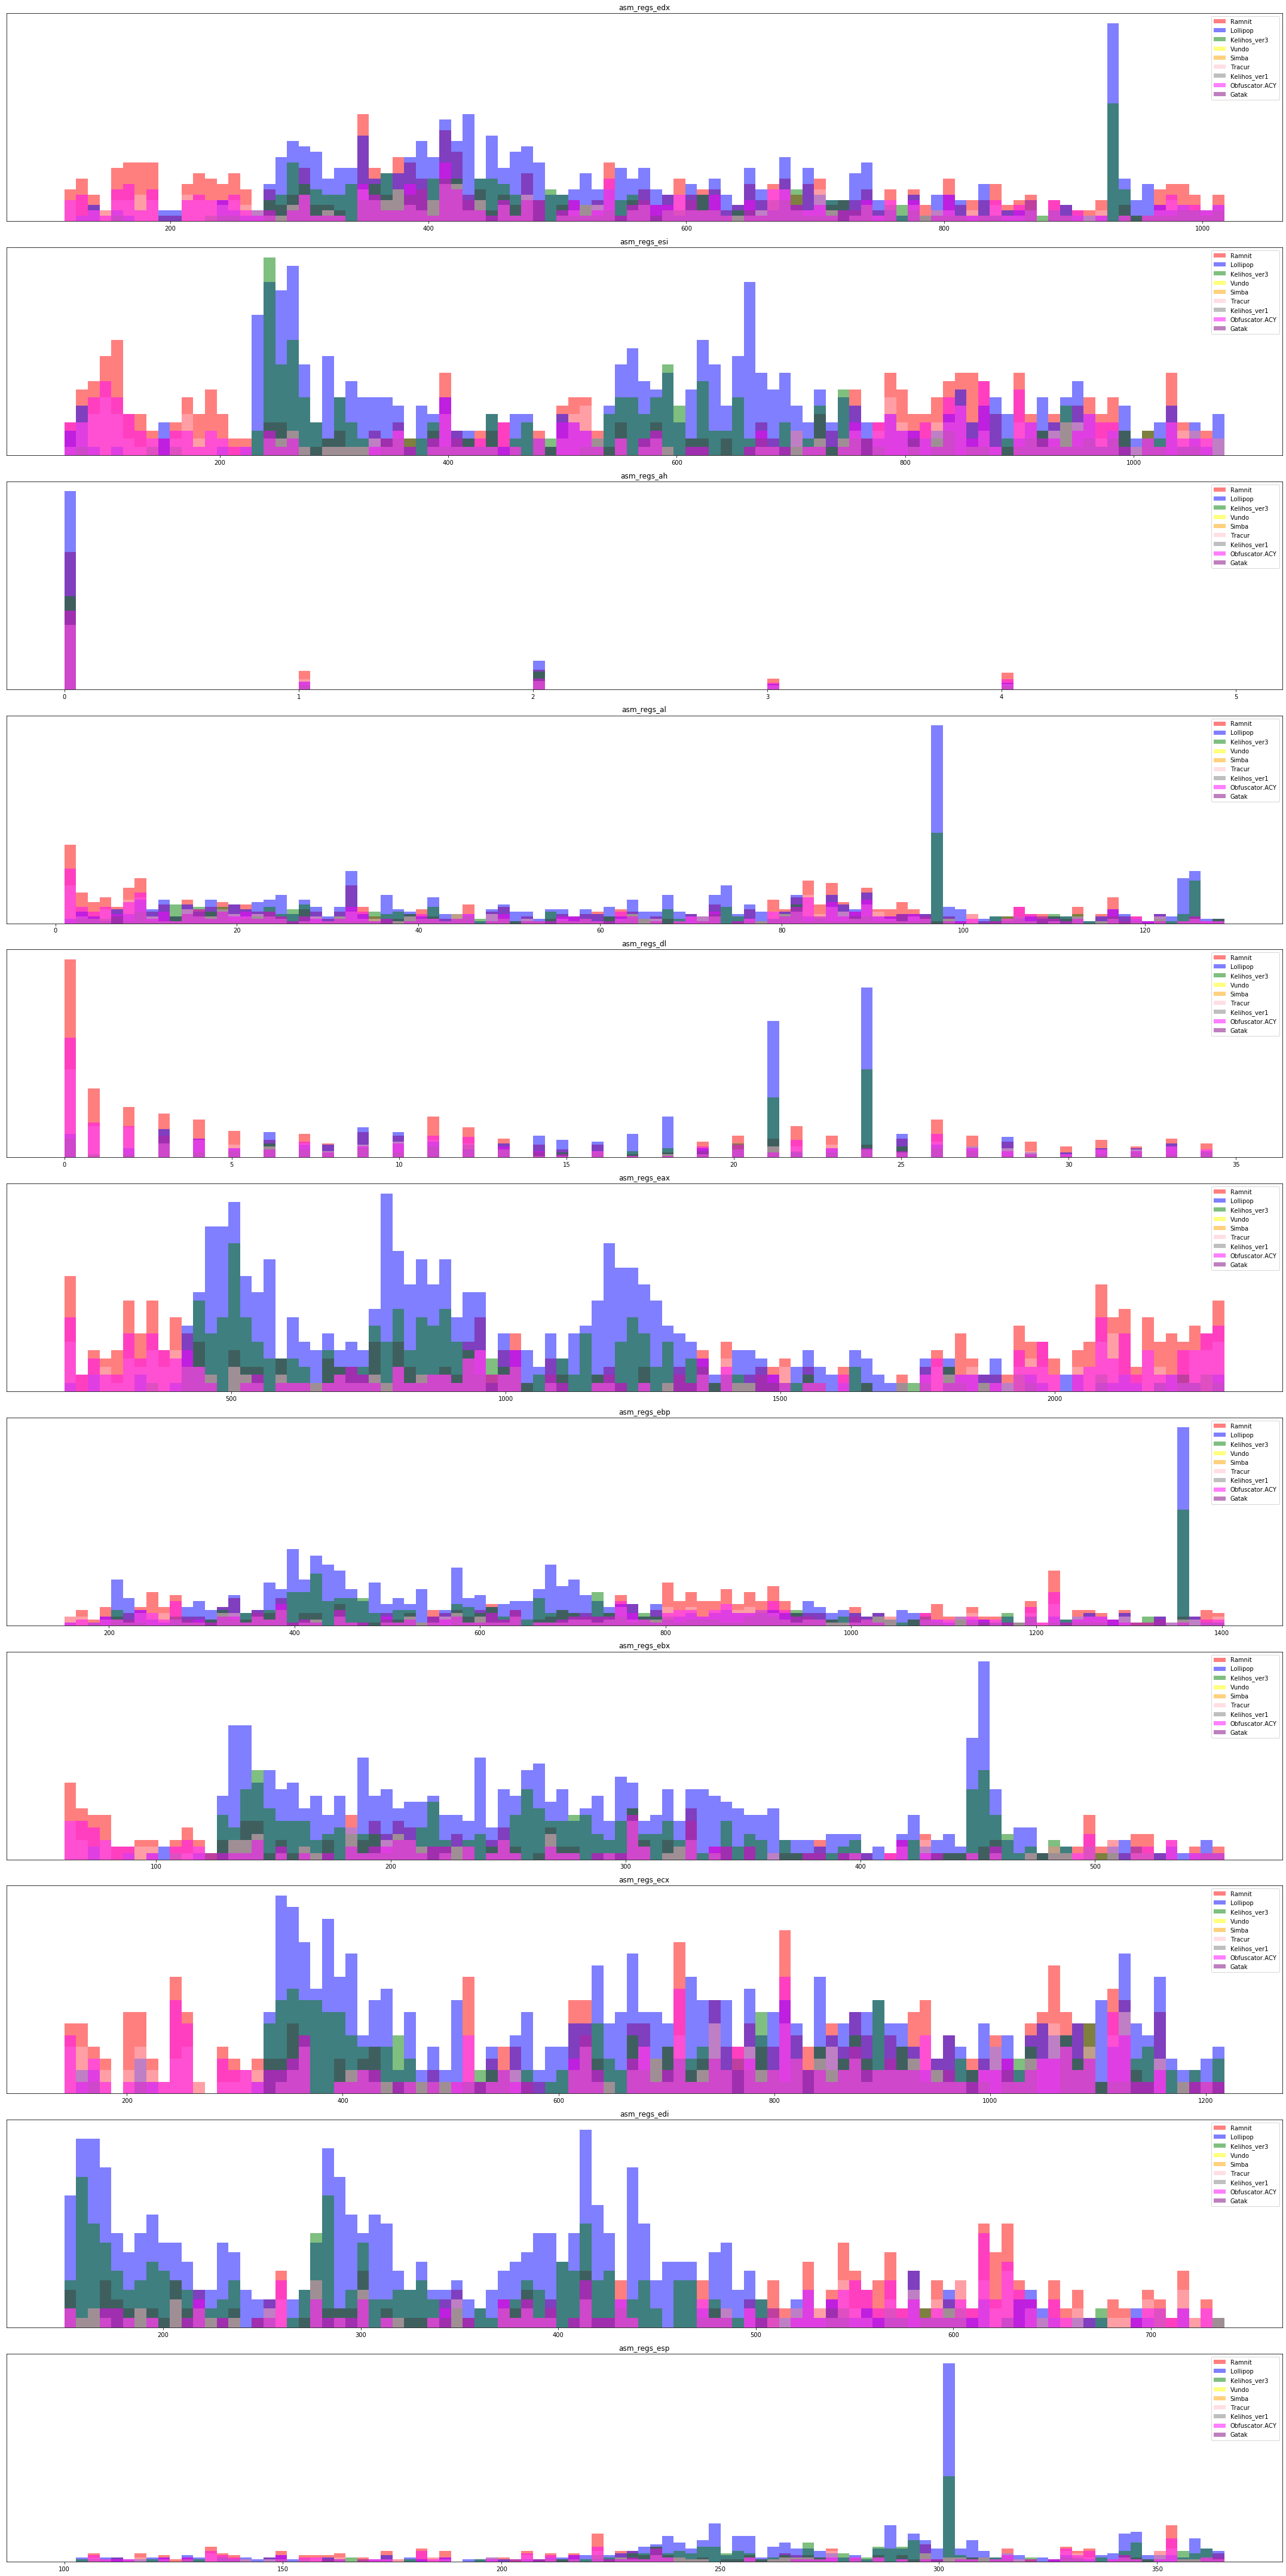

In [138]:
draw_histograms_rows_quantile( data = reg_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1,8,9,-8,-6,-5,-4,-3,-2,-1],
                              sections = 100, 
                              no_rows = 11, no_cols = 1, 
                              fig_x = 30, fig_y = 60,
                              i_want_whole_range = [False]*11)

#### sekcije
_SEC_

In [37]:
# SECTION značajke
section_features = features.iloc[:,758:782]
section_features.head()

.text    .data  .bss  .rdata  .edata  .idata  .rsrc  .tls  .reloc  \
0     744.0     57.0   0.0   323.0     0.0   127.0    3.0   0.0     3.0   
1   60476.0   3760.0   0.0     0.0     0.0   349.0    3.0   0.0     3.0   
2   11119.0   1047.0   0.0  3385.0     0.0   323.0    3.0   0.0     3.0   
3  208048.0  19267.0   0.0     0.0     0.0  1746.0    3.0   0.0     3.0   
4   12773.0   3160.0   0.0   639.0     0.0   230.0    3.0   0.0     3.0   

   Num_Sections  ...  .bss_por  .rdata_por  .edata_por  .idata_por  .rsrc_por  \
0           7.0  ...       0.0    0.253135         0.0    0.099530   0.002351   
1           6.0  ...       0.0    0.000000         0.0    0.005402   0.000046   
2           7.0  ...       0.0    0.212933         0.0    0.020318   0.000189   
3           7.0  ...       0.0    0.000000         0.0    0.007546   0.000013   
4           7.0  ...       0.0    0.037975         0.0    0.013669   0.000178   

   .tls_por  .reloc_por  known_Sections_por  Unknown_Sections_por  \
0       0.0         0.0            0.714286              0.142857   
1       0.0         0.0            0.666667              0.166667   
2       0.0         0.0            0.714286              0.142857   
3       0.0         0.0            0.571429              0.285714   
4       0.0         0.0            0.714286              0.142857   

   Unknown_Sections_lines_por  
0                    0.014890  
1                    0.000294  
2                    0.001069  
3                    0.010031  
4                    0.001129  

[5 rows x 24 columns]

In [38]:
section_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

.idata_por                   -0.013430
.text_por                    -0.009591
.rdata_por                   -0.007590
known_Sections_por           -0.006821
.text                        -0.004737
.tls                         -0.004194
.reloc                       -0.002501
.rdata                       -0.000757
.tls_por                     -0.000348
.edata                        0.000612
.rsrc_por                     0.001485
.data                         0.001523
.rsrc                         0.002890
.edata_por                    0.003358
Unknown_Sections_lines        0.003759
Unknown_Sections_por          0.007090
Unknown_Sections_lines_por    0.007561
Num_Sections                  0.008466
.data_por                     0.009504
Unknown_Sections              0.011613
.idata                        0.017601
.bss_por                      0.020801
.bss                          0.021373
dtype: float64

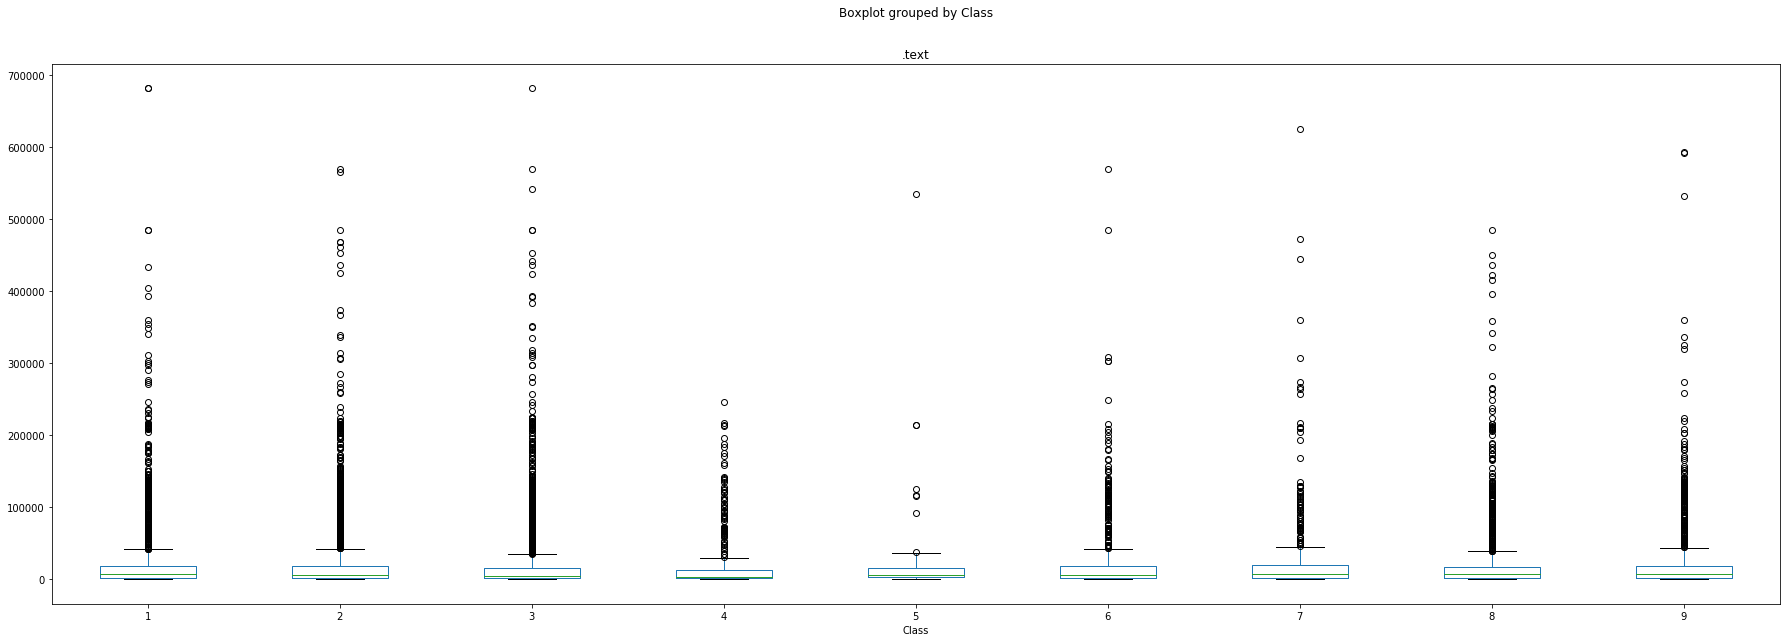

In [139]:
features.boxplot(column=[section_features.columns.values[0]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

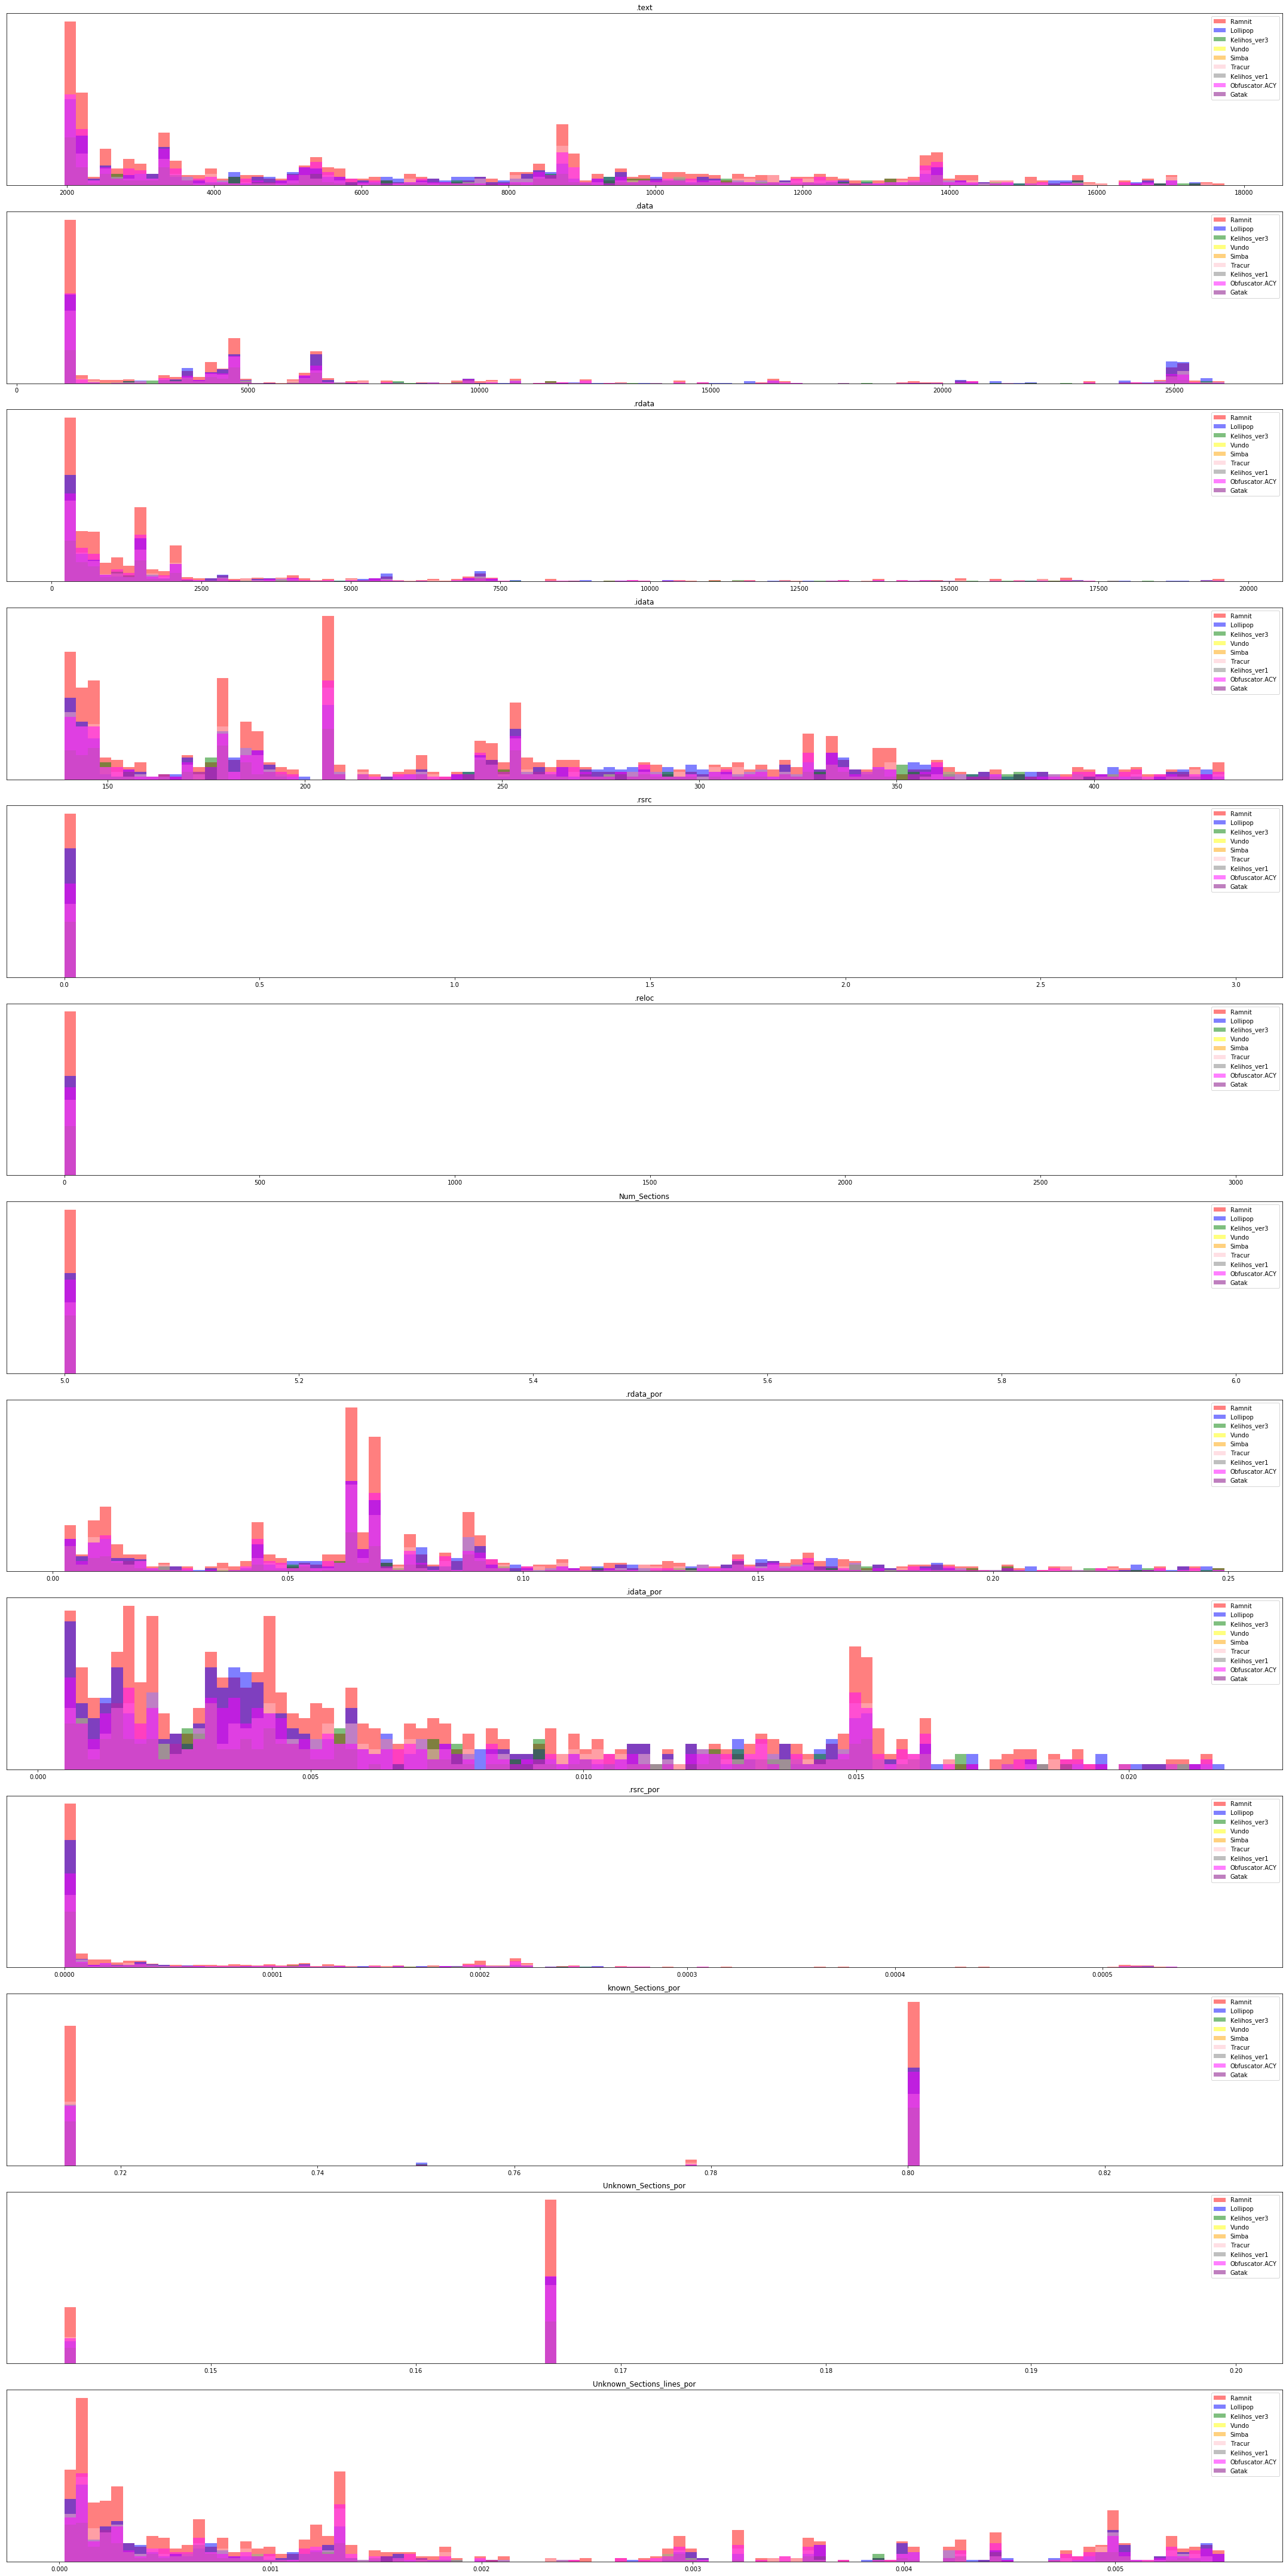

In [140]:
draw_histograms_rows_quantile( data = section_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1,3,5,6,8,9,-9,-7,-6,-3,-2,-1],
                              sections = 100, 
                              no_rows = 13, no_cols = 1, 
                              fig_x = 30, fig_y = 60,
                              i_want_whole_range = [False]*13)

#### _data define_
_DP_

In [39]:
# DATA DEFINE značajke
dd_features = features.iloc[:,782:806]
dd_features.head()

db_por    dd_por    dw_por    dc_por   db0_por  dbN0_por   dd_text  \
0  0.108934  0.083072  0.029781  0.221787  0.474820  0.525180  0.008065   
1  0.064309  0.048305  0.005262  0.117876  0.525150  0.474850  0.044414   
2  0.185570  0.057369  0.006857  0.249796  0.647119  0.352881  0.000540   
3  0.089382  0.017417  0.002178  0.108977  0.727589  0.272411  0.015506   
4  0.194687  0.015273  0.004814  0.214774  0.902320  0.097680  0.002584   

    db_text  dd_rdata  db3_rdata  ...    dd6   dd4_all   dd5_all   dd6_all  \
0  0.001344  0.287926   0.191950  ...    0.0  0.000000  0.002351  0.000000   
1  0.021744  0.000000   0.000000  ...    9.0  0.001068  0.000542  0.000139   
2  0.000540  0.250222   0.486263  ...    0.0  0.000252  0.000503  0.000000   
3  0.015775  0.000000   0.000000  ...  106.0  0.000337  0.000471  0.000458   
4  0.000470  0.270736   0.128326  ...    0.0  0.000238  0.000178  0.000000   

   db3_idata  db3_NdNt  dd4_NdNt  dd5_NdNt  dd6_NdNt  db3_all_zero  
0        0.0       0.0  0.000000  0.003822  0.000000      0.370787  
1        0.0       0.0  0.001561  0.000792  0.000204      0.396007  
2        0.0       0.0  0.000442  0.000884  0.000000      0.376826  
3        0.0       0.0  0.000619  0.000876  0.000852      0.435593  
4        0.0       0.0  0.000496  0.000372  0.000000      0.474631  

[5 rows x 24 columns]

In [40]:
dd_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

dd_rdata       -0.024129
dw_por         -0.012917
db3_all_zero   -0.010933
db0_por        -0.009924
db3_rdata      -0.009055
dd6            -0.007005
dd6_all        -0.003812
dd4_all        -0.001775
dd6_NdNt       -0.000537
dd4_NdNt       -0.000060
dd4             0.001594
db3_data        0.005775
dbN0_por        0.009179
db_por          0.010853
db3_all         0.011300
dd5             0.012640
db_text         0.012811
dd_por          0.016824
dd_text         0.018823
dd5_all         0.023018
dc_por          0.024433
dd5_NdNt        0.025442
dtype: float64

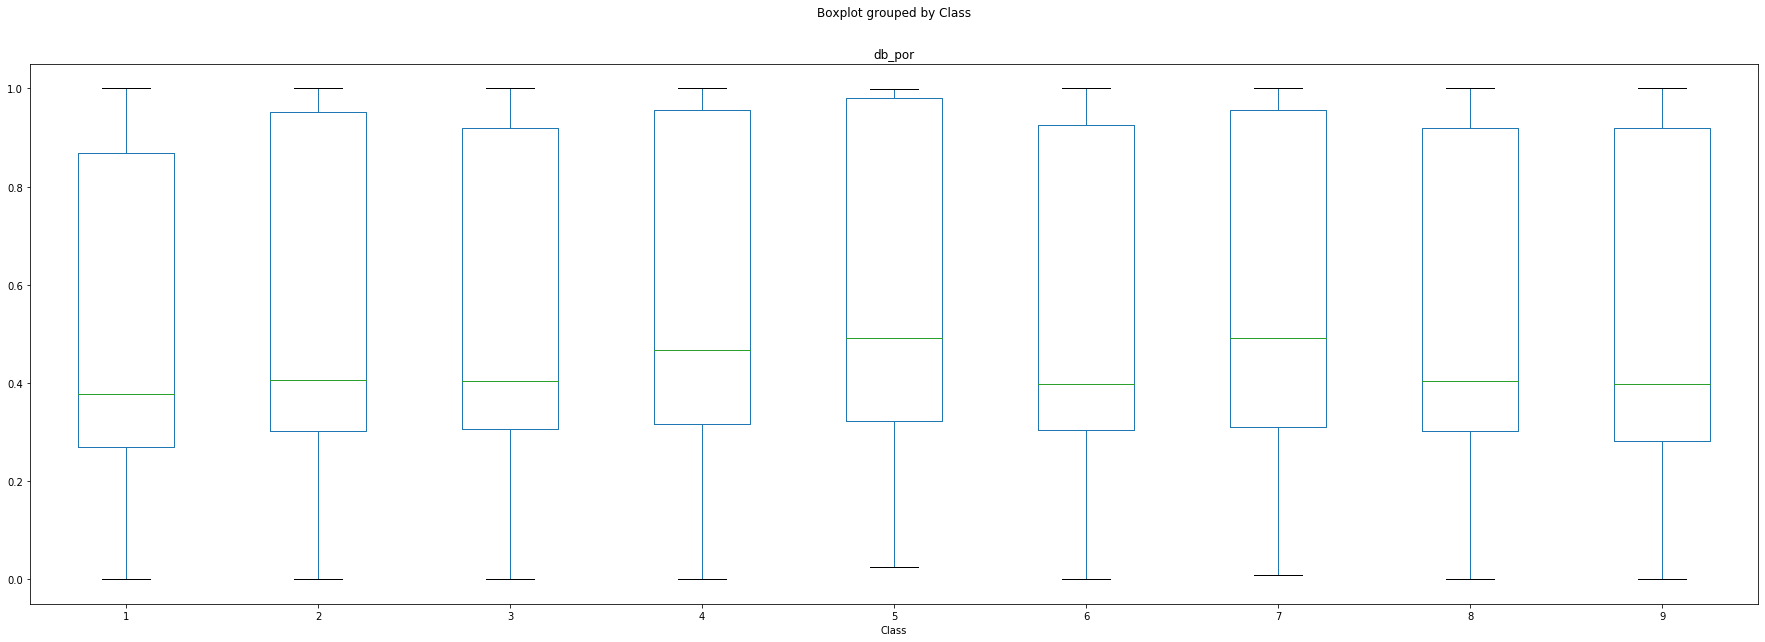

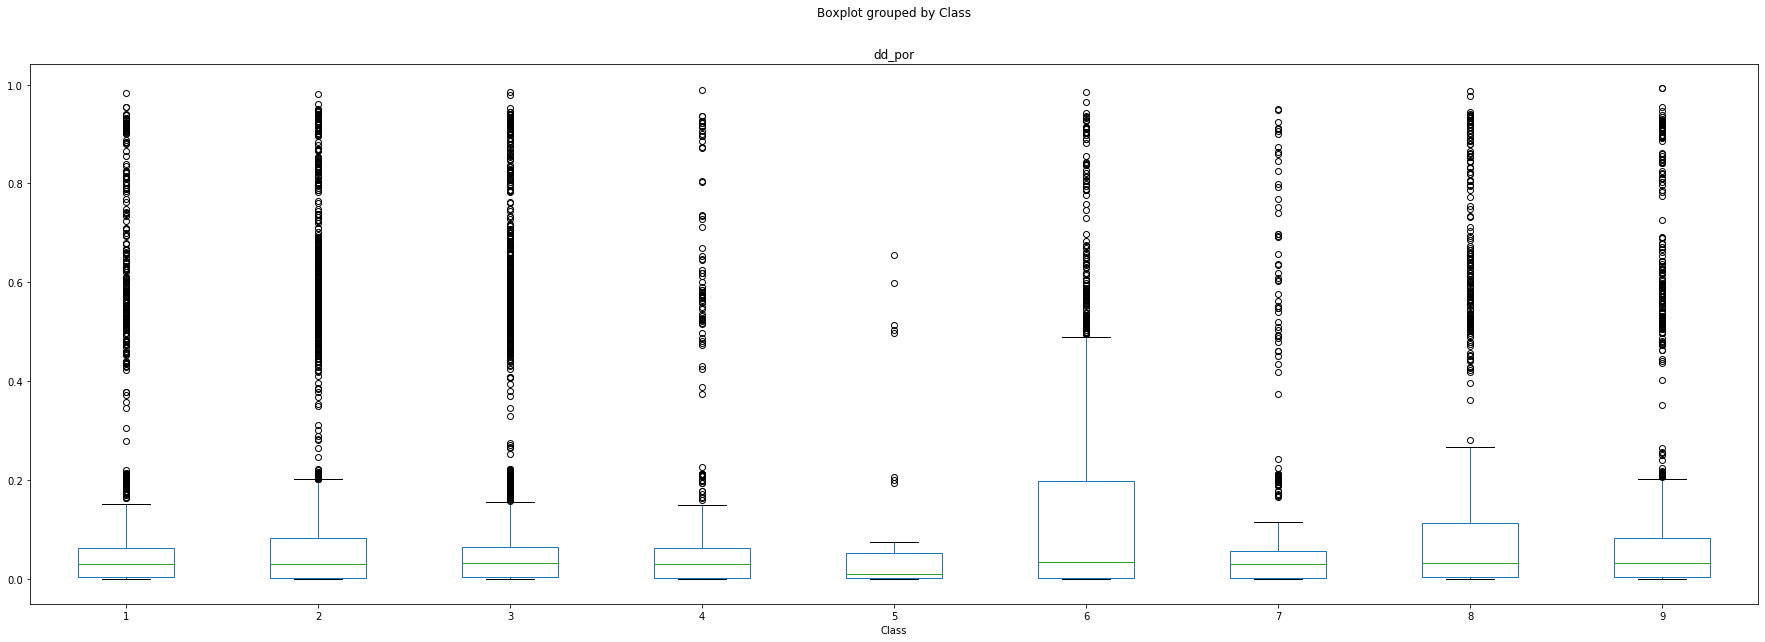

In [141]:
features.boxplot(column=[dd_features.columns.values[0]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))
features.boxplot(column=[dd_features.columns.values[1]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

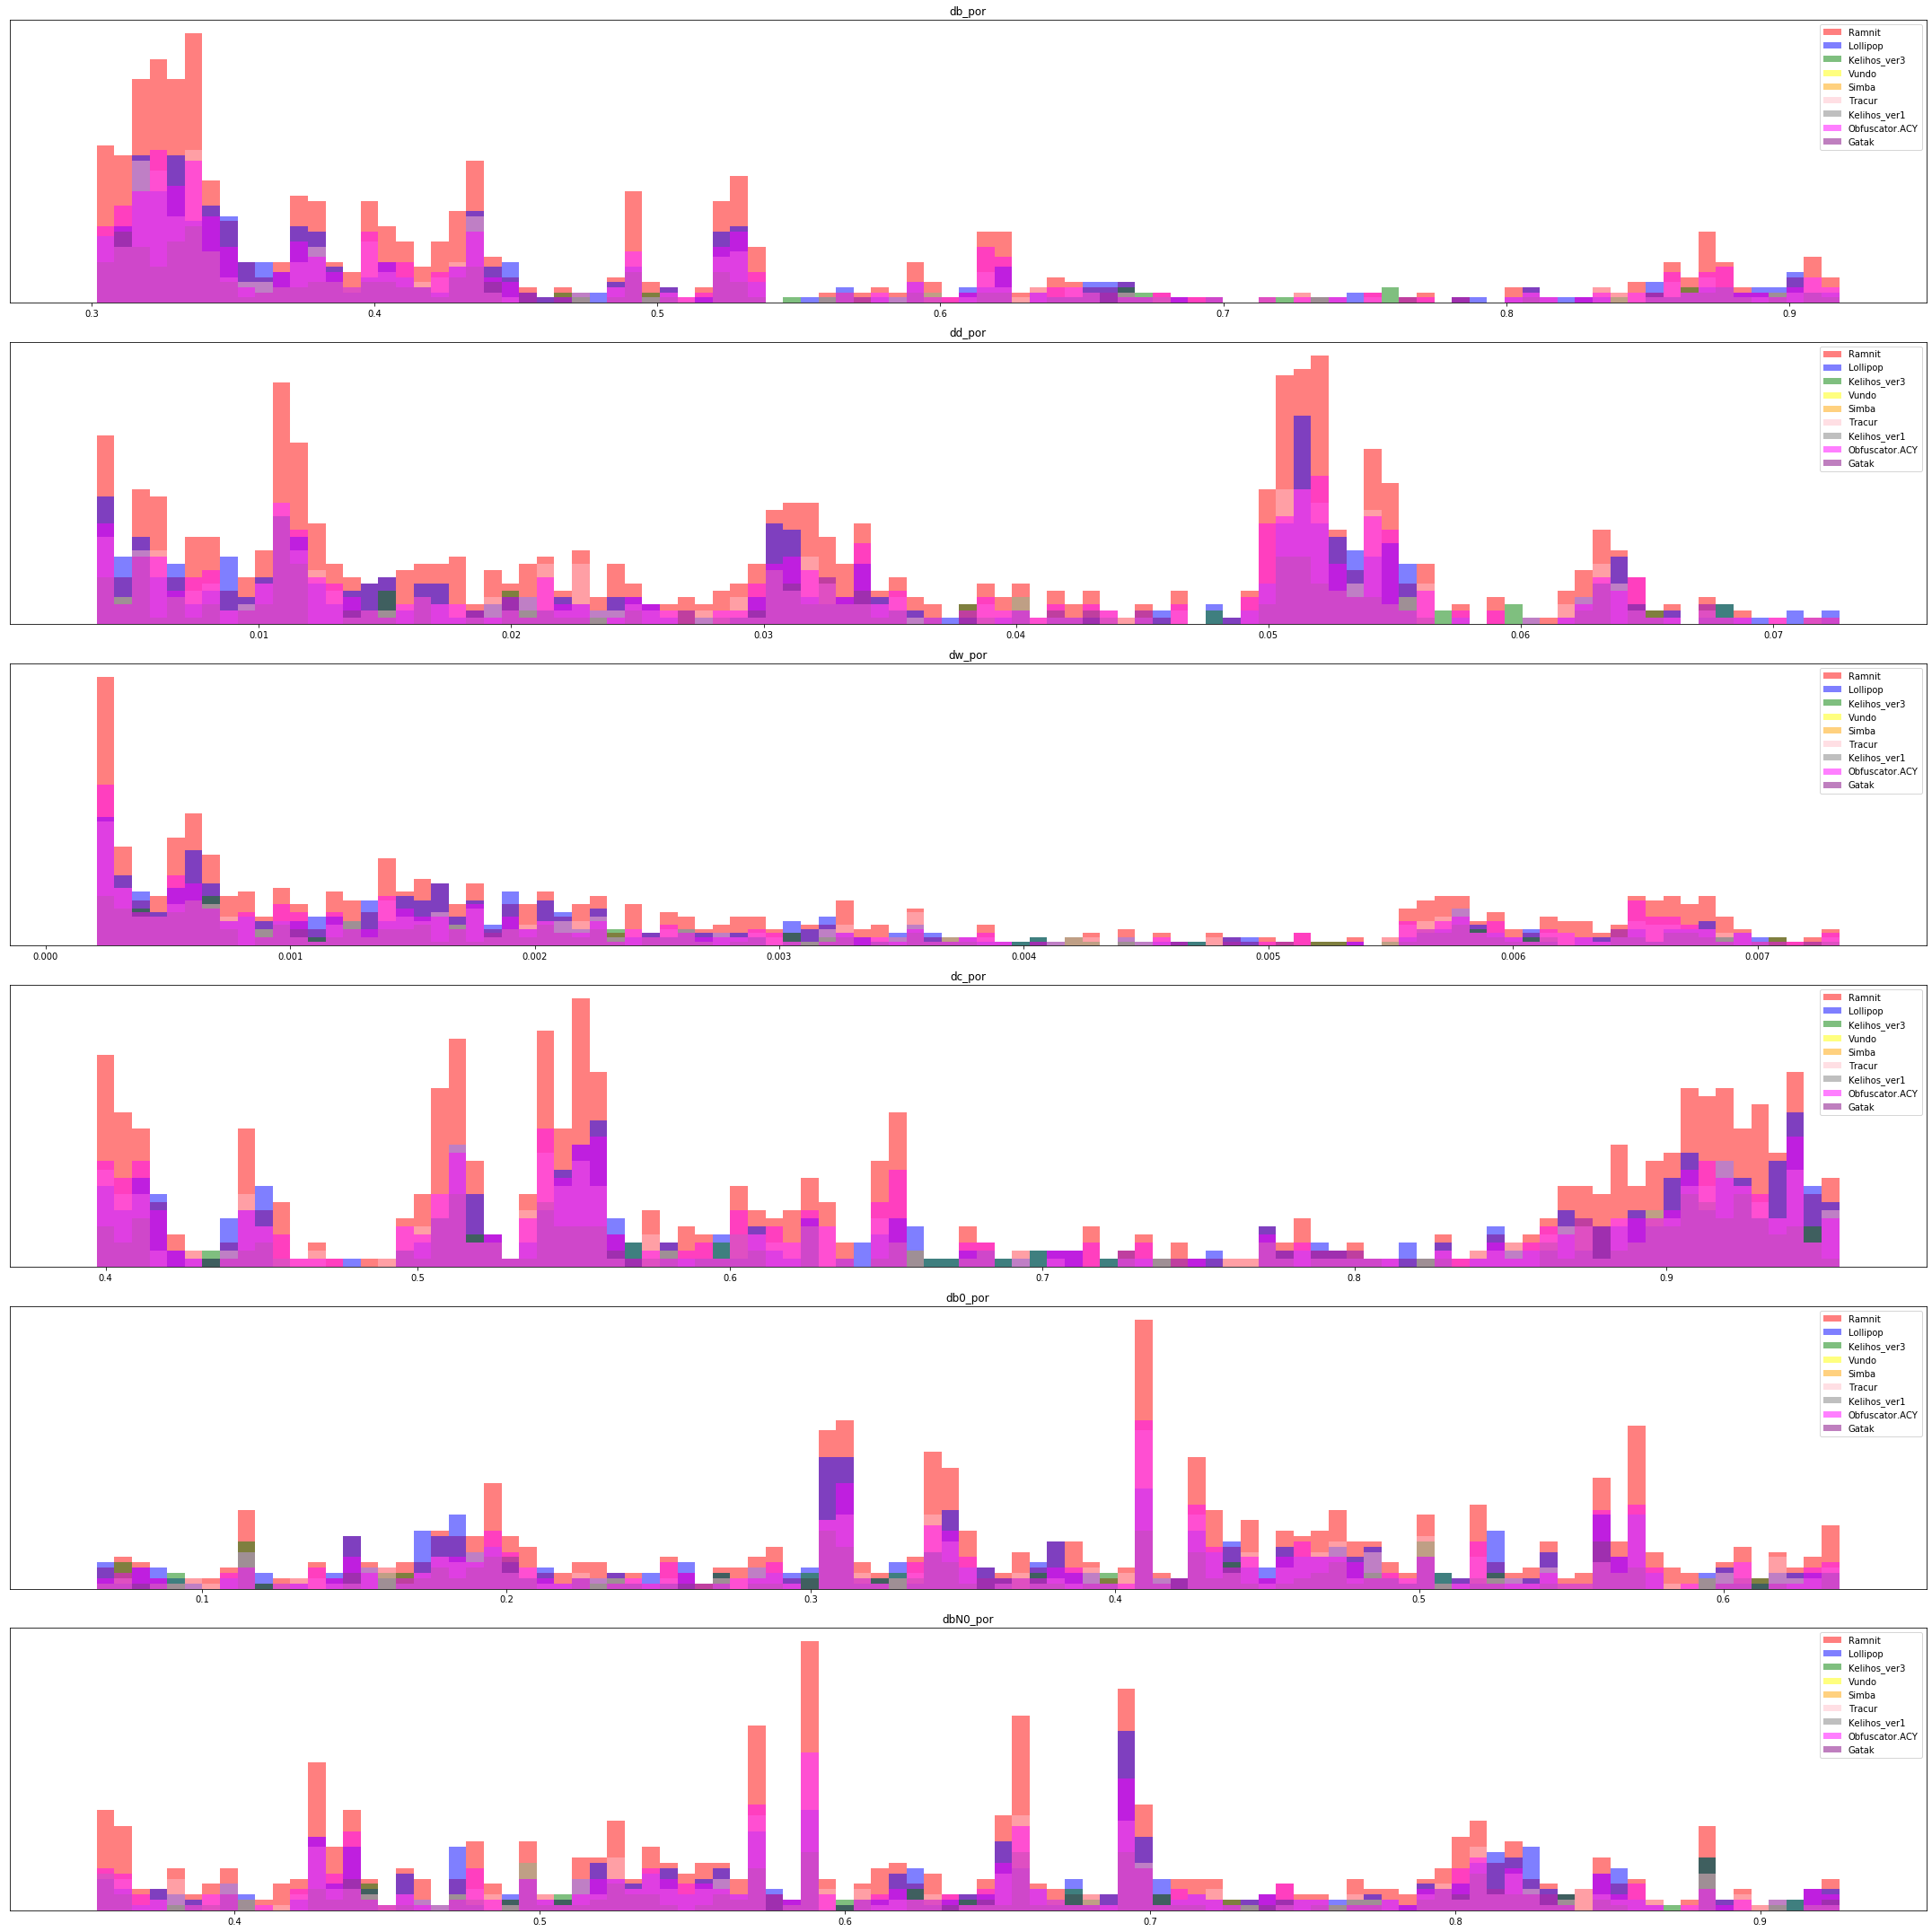

In [142]:
draw_histograms_rows_quantile( data = dd_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1,2,3,4,5],
                              sections = 100, 
                              no_rows = 6, no_cols = 1, 
                              fig_x = 30, fig_y = 30,
                              i_want_whole_range = [False]*6)

#### API
_API_

In [15]:
# API značajke
api_features = features.iloc[:,806:1600]
api_features.head()

wcslen  __vbaUI1I2  send  MoveFileExA  VariantCopyInd  __vbaStrI2  \
0       0           0     0            0               0           0   
1     123           0     0            0               0           0   
2       0           0     0            0               0           0   
3       0           0     2            0               0           0   
4       0           0     0            0               0           0   

   DispatchMessageW  WaitForMultipleObjects  CoGetClassObject  IsEqualGUID  \
0                 6                       0                 0            0   
1                 0                       0                 0           11   
2                 0                       0                 0            0   
3                 0                       5                57            0   
4                 0                       0                 0            0   

   ...  GetEnhMetaFilePaletteEntries  IsBadCodePtr  OpenMutexA  __vbaStrI4  \
0  ...                             0             0           0           0   
1  ...                             0             0           0           0   
2  ...                             0             0           0           0   
3  ...                             0             0           0           0   
4  ...                             0             0           0           0   

   __vbaVarCopy  CopyEnhMetaFileA  LocalReAlloc  srand  __vbaAryCopy  \
0             0                 0             0      0             0   
1             0                 0             0      0             0   
2             0                 0             0      0             0   
3             0                 0             0      0             0   
4             0                 0             0      0             0   

   CreateDCA  
0          0  
1          0  
2          0  
3          0  
4          0  

[5 rows x 794 columns]

In [41]:
api_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

HeapCreate                -0.510643
DispatchMessageA          -0.476598
FreeEnvironmentStringsA   -0.457051
FreeEnvironmentStringsW   -0.395712
TlsAlloc                  -0.377199
                             ...   
GetForegroundWindow        0.306939
_controlfp                 0.377833
_acmdln                    0.435661
__p__fmode                 0.543389
__setusermatherr           0.545979
Length: 751, dtype: float64

In [108]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( api_features.dropna(), features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
accuracy_test = model.score(malware_test,malware_classes_test) # Tocnost je default mjera za LogisticRegression()
print(accuracy_test)

0.9751609935602575


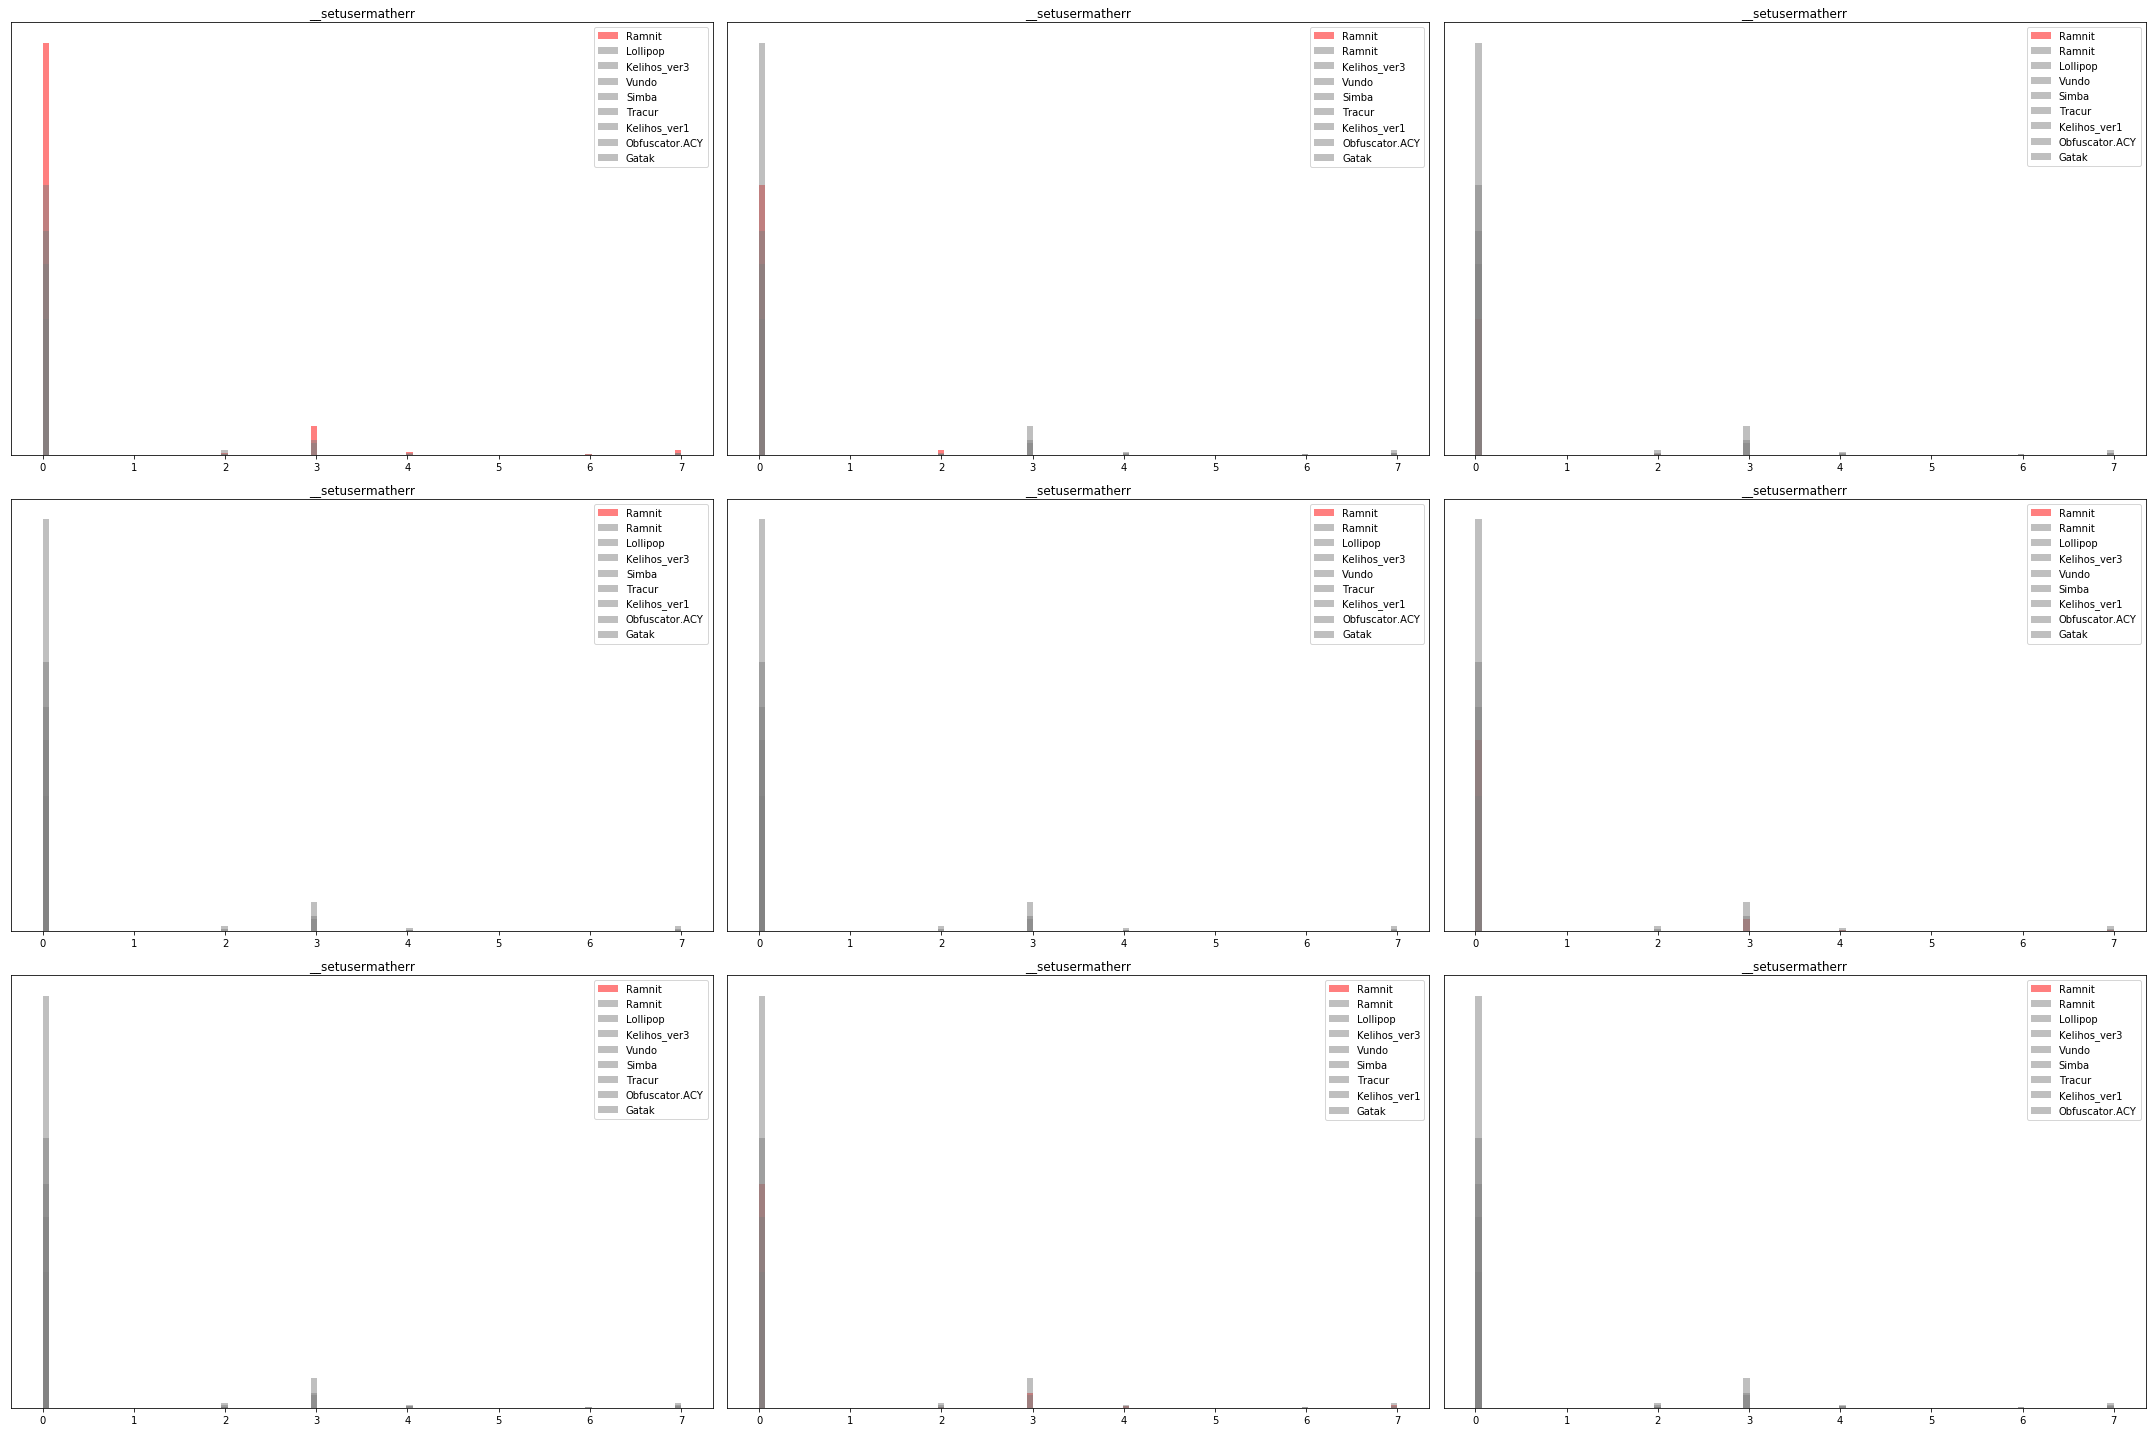

In [59]:
#polje = api_features.columns == '__setusermatherr'
#var = [i for i in range(len(polje)) if polje[i]]
#print(var)
draw_histograms_rows_quantile_one_vs_others(  data = api_features, 
                                              classes = classes_begining_and_end_in_features,
                                              features = [525],
                                              sections = 100, 
                                              no_rows = 3, no_cols = 3, 
                                              fig_x = 30, fig_y = 20,
                                              i_want_whole_range = [True]*9,
                                              one=[i for i in range(1,10)])

#### ključne riječi
_KEYW_

In [16]:
# KEYWORDS značajke
key_features = features.iloc[:,1600:1695]
key_features.head()

Virtual  Offset    loc  Import  Imports    var  Forwarder  UINT  LONG  \
0        9       3    124      15        0     66          4     2     0   
1       36       2   8198      28        0   3806          7     2    10   
2        9      19   1198      19        0    455          5     2     2   
3       28       6  30848      44        0  12694          8    76    30   
4       32      15   2428      16        0    559          4     2     1   

   BOOL  ...  visualc  ___security_cookie  assume  callvirtualalloc  \
0     4  ...        0                   0       0                 0   
1    16  ...        0                   0       0                 0   
2     3  ...        0                   0       0                 0   
3   114  ...        0                   0       2                 0   
4    10  ...        0                   0       0                 0   

   exportedentry  hardware  hkey_current_user  hkey_local_machine  \
0              0         0                  0                   0   
1              0         0                  0                   0   
2              0         0                  0                   0   
3              0         0                  0                   0   
4              0         0                  0                   0   

   sp-analysisfailed  unableto  
0                  0         0  
1                  0         0  
2                  0         0  
3                  0         0  
4                  0         0  

[5 rows x 95 columns]

In [42]:
key_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

Offset      -0.405891
BYTES       -0.310387
.text:      -0.244555
XREF        -0.233294
arg         -0.232161
               ...   
Forwarder    0.023953
proc         0.050287
byte         0.064705
BOOL         0.169173
assume       0.223028
Length: 70, dtype: float64

In [107]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( key_features.dropna(), features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
accuracy_test = model.score(malware_test,malware_classes_test) # Tocnost je default mjera za LogisticRegression()
print(accuracy_test)

0.889604415823367


C:\Users\sstan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


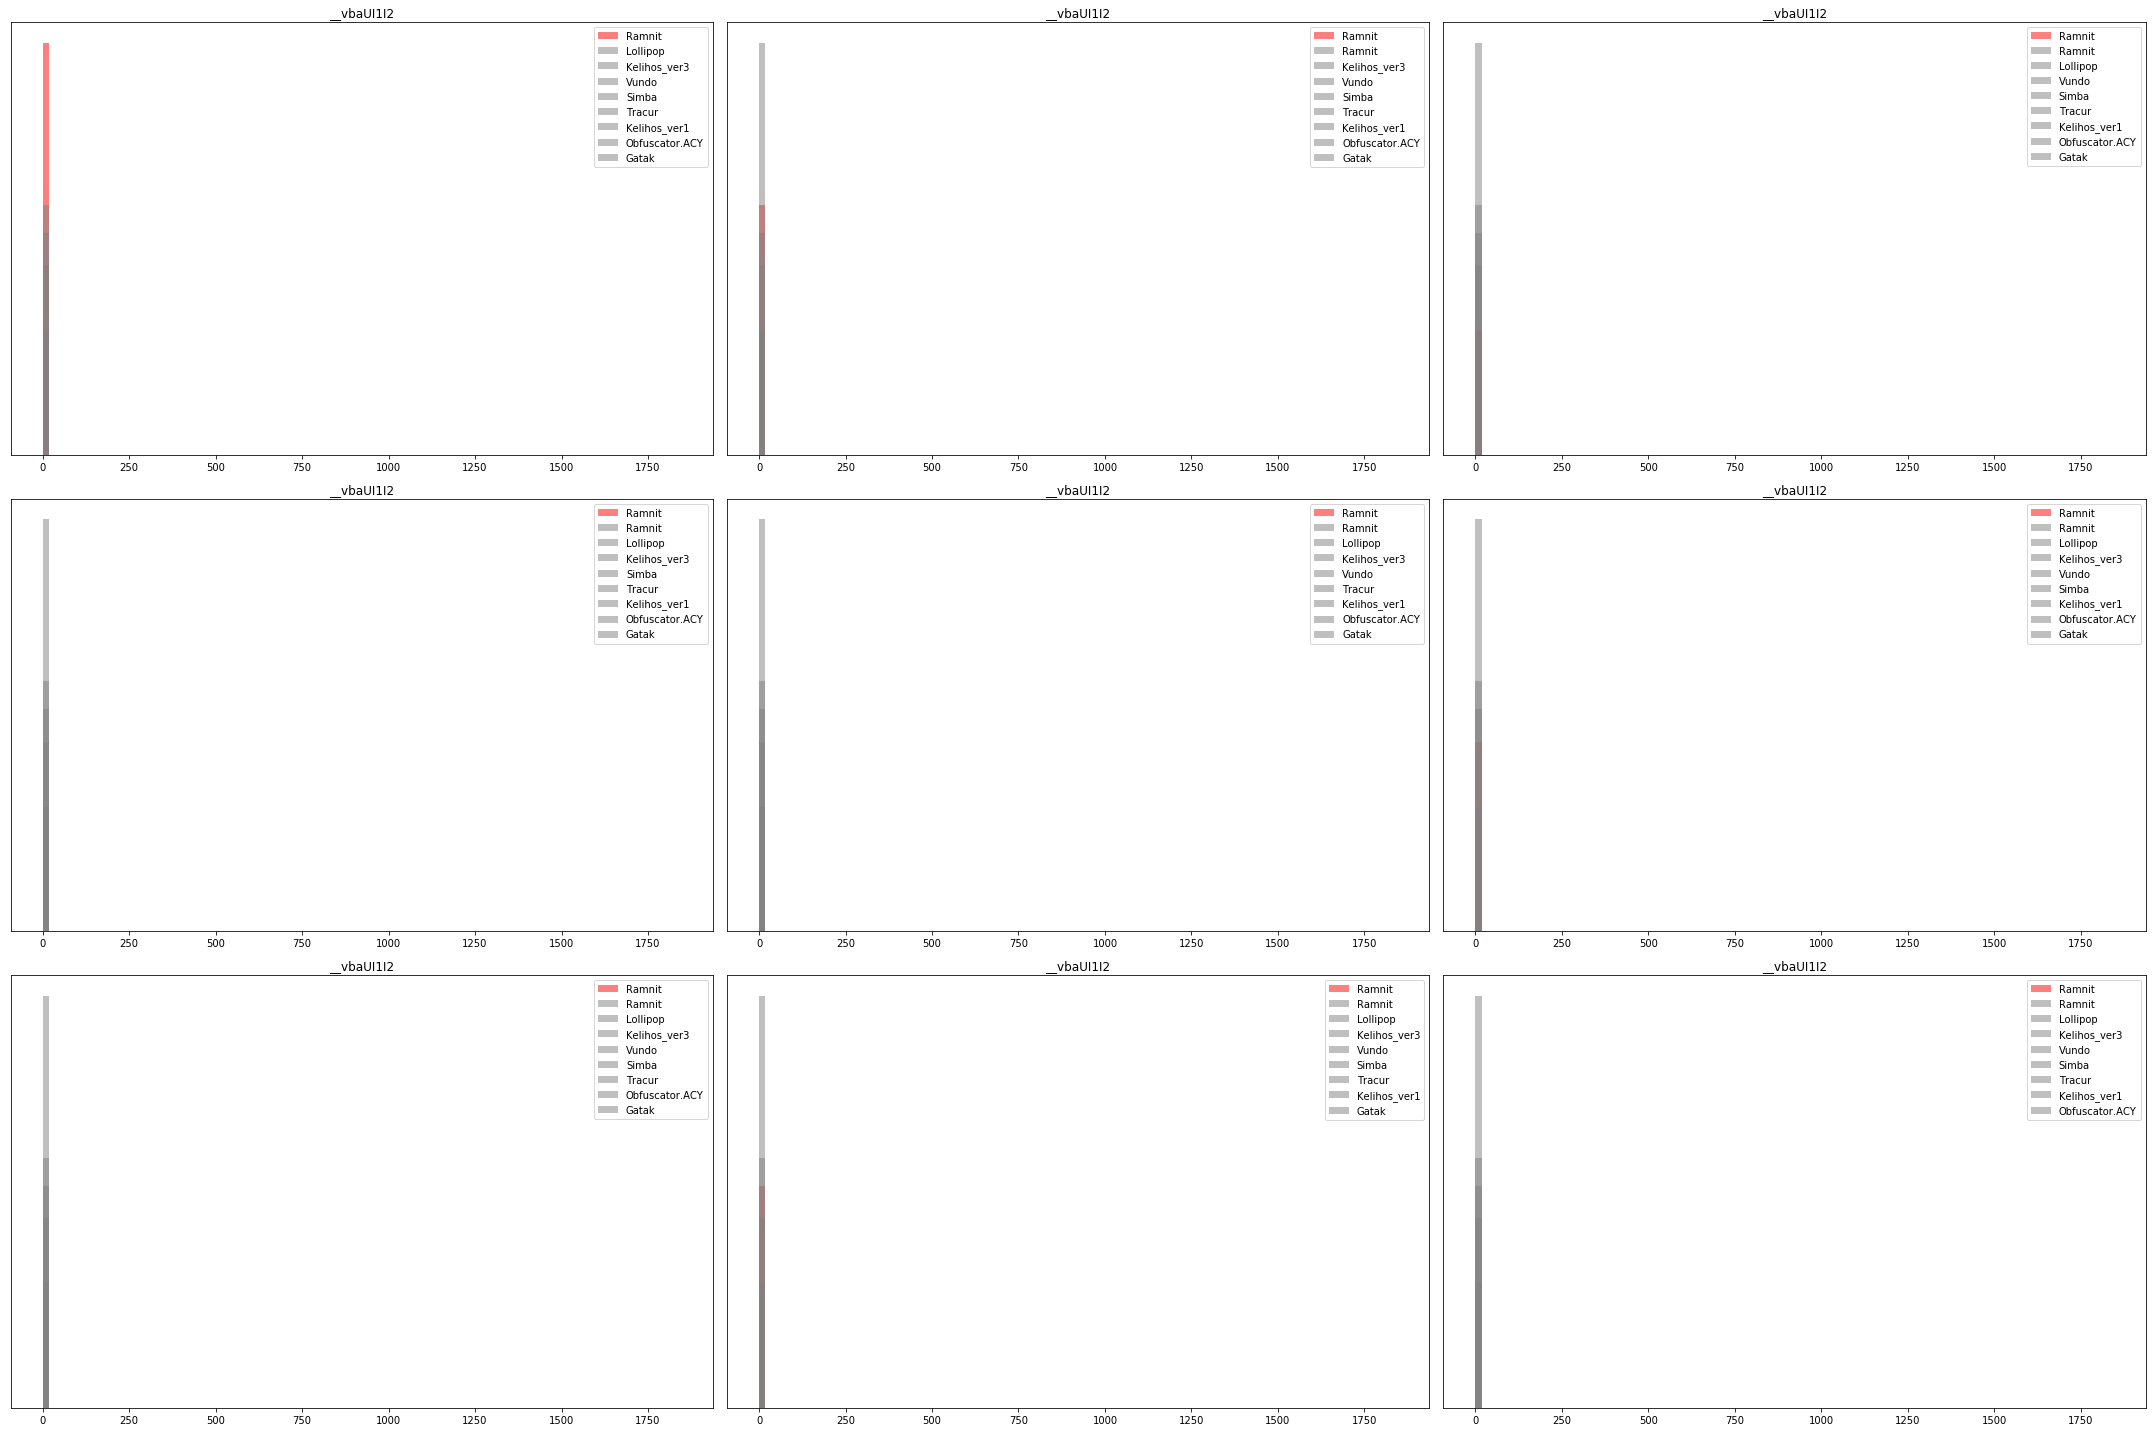

In [66]:
#polje = key_features.columns == 'Offset'
#var = [i for i in range(len(polje)) if polje[i]]
#print(var)
draw_histograms_rows_quantile_one_vs_others(  data = api_features, 
                                              classes = classes_begining_and_end_in_features,
                                              features = [1],
                                              sections = 100, 
                                              no_rows = 3, no_cols = 3, 
                                              fig_x = 30, fig_y = 20,
                                              i_want_whole_range = [False]*9,
                                              one=[i for i in range(1,10)])

<br>
<br>